<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/ml_models_unseen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
from matplotlib import pyplot
import seaborn as sns
from xgboost import XGBClassifier

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Mounted at /content/drive


In [ ]:
# Import user defined python functions. Used importlib as having stability issues with simple import and not picking up the files
spec = importlib.util.spec_from_file_location("create_model_results", "/content/drive/MyDrive/birkbeck_msc-project/python_files/create_model_results.py")
create_model_results = importlib.util.module_from_spec(spec)
spec.loader.exec_module(create_model_results)


In [ ]:
# Authentication credentials and keys
# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [ ]:
# Feature data for FA Cup

# Query Google Big Query
fa_cup_features_all = """
    SELECT * FROM preparation_layer.view_fa_cup_round_3_features
"""

fa_cup_features_all_df = client.query(fa_cup_features_all).to_dataframe()
display(fa_cup_features_all_df)


test_flag = 'Unseen'


season_year  match_id                         match_name  \
0         09/10    505337                 Chelsea vs Watford   
1         14/15   1138603                 Chelsea vs Watford   
2         16/17   1345813     Chelsea vs Peterborough United   
3         20/21    201912       Manchester United vs Watford   
4         09/10    505338  Manchester United vs Leeds United   
..          ...       ...                                ...   
345       14/15   1142554  Blyth Spartans vs Birmingham City   
346       17/18    949974       Yeovil Town vs Bradford City   
347       18/19     50205                  Woking vs Watford   
348       20/21    200806         Chorley FC vs Derby County   
349       21/22   1621149  Kidderminster Harriers vs Reading   

    match_final_score  arena_stadium_capacity  home_team_league_level  \
0                 5-0                   41837                       1   
1                 3-0                   41837                       1   
2                 4-1                   41837                       1   
3                 1-0                   74879                       1   
4                 0-1                   74879                       1   
..                ...                     ...                     ...   
345               2-3                    <NA>                       6   
346               2-0                    9527                       4   
347               0-2                    6064                       6   
348               2-0                    4100                       6   
349               2-1                    6238                       6   

     home_win  home_team_round_3_position  home_team_massey  home_team_colley  \
0           1                           1                 1                 1   
1           1                           1                 1                 1   
2           1                           1                 1                 1   
3           1                           1                 1                 1   
4           0                           2                 4                 7   
..        ...                         ...               ...               ...   
345         0                          64                58                64   
346         1                          64                58                64   
347         0                          64                58                64   
348         1                          64                58                64   
349         1                          64                58                64   

     ...  match_weather_data_hours_dew  match_weather_data_hours_precip  \
0    ...                           NaN                              NaN   
1    ...                         34.70                            0.000   
2    ...                         47.00                            0.000   
3    ...                         71.20                            0.000   
4    ...                           NaN                              NaN   
..   ...                           ...                              ...   
345  ...                           NaN                              NaN   
346  ...                         37.15                            0.000   
347  ...                         41.45                            0.000   
348  ...                         32.75                            0.001   
349  ...                         40.40                            0.000   

     match_weather_data_hours_snow  match_weather_data_hours_snowdepth  \
0                              NaN                                 NaN   
1                              0.0                                0.00   
2                              0.0                                0.00   
3                              NaN                                0.00   
4                              NaN                                 NaN   
..                             ...      

In [ ]:
# Function to calculate home advantage
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

In [ ]:
# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}


In [ ]:
def classifer_models_optimisation_single_split (fa_cup_features_all_df, model_name, home_advt, weighted, model_classifier, random_state):

    # Define the ranking systems
    ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

    # Split data into training and test sets
    fa_cup_features_train = fa_cup_features_all_df[~fa_cup_features_all_df['season_year'].isin(['21/22', '22/23'])]
    fa_cup_features_test = fa_cup_features_all_df[fa_cup_features_all_df['season_year'].isin(['21/22', '22/23'])]

    # Drop 'season_year, match id, match name' column from both sets so not included in model training but then retain for vlaidation set for futher analysis and comparision
    analysis_columns = ['season_year', 'match_id', 'match_name','match_final_score']

    fa_cup_features_train = fa_cup_features_train.drop(analysis_columns, axis=1)

    test_analysis_columns = fa_cup_features_test[analysis_columns].copy()
    fa_cup_features_test = fa_cup_features_test.drop(analysis_columns, axis=1)

    # Get all columns except the target and ranking columns
    target_variable = 'target_variable'
    base_features = [col for col in fa_cup_features_train.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

    # Identify numeric and categorical columns
    numeric_features = fa_cup_features_train[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = fa_cup_features_train[base_features].select_dtypes(include=['object']).columns.tolist()

    # Define preprocessing steps
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    ranking_transformer = Pipeline(steps=[
        ('scaler', MinMaxScaler())
    ])

    for ranking in ranking_systems:
        model_name_ranking = f"{model_name} {ranking}"
        print(model_name_ranking)

        # Initialize lists to store results for the model
        train_accuracies = []
        train_recalls = []
        test_accuracies = []
        test_recalls = []
        all_y_train_true = []
        all_y_train_pred = []
        all_y_train_pred_proba = []  # Store probabilities for ROC
        all_y_test_true = []
        all_y_test_pred = []
        all_y_test_pred_proba = []  # Store probabilities for ROC

        # Fetch parameter grid from BigQuery for model name ranking
        query = """
        SELECT param_grid FROM analysis_layer.view_ml_models_best_recall_param_grid
        WHERE model_name_ranking = @model_name_ranking
        """

        # Set up the query configuration with the parameter
        job_config = bigquery.QueryJobConfig(
            query_parameters=[
                bigquery.ScalarQueryParameter("model_name_ranking", "STRING", model_name_ranking)
            ]
        )

        # Execute the query
        query_job = client.query(query, job_config=job_config)
        results = query_job.result()

        # Process the results and remove 'Classifier__' prefix
        param_grid_raw = eval(next(iter(results)).param_grid)
        param_grid = {k.replace('classifier__', ''): v for k, v in param_grid_raw.items()}

        # Update the model_classifier with the fetched parameters
        model_classifier.set_params(**param_grid)

        print("Updated model parameters:")

        for param, value in model_classifier.get_params().items():
            print(f"  {param}: {value}")

        if  ranking == 'no_ranking':
            features = base_features
        else:
            features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']

        # Create X_train and y_train
        X_train = fa_cup_features_train[features]
        y_train = fa_cup_features_train[target_variable]

        # Create X_val and y_val
        X_test = fa_cup_features_test[features]
        y_test = fa_cup_features_test[target_variable]

        if home_advt == 'yes':
            X_train, home_advantage_column = add_home_advantage(X_train)
            X_test, _ = add_home_advantage(X_test)
            numeric_features = [home_advantage_column] + numeric_features

        # Drop home win and league level feature so not used in modelling as impact predictability be proviing the winner
        columns_to_drop = ['home_win', 'home_team_league_level', 'away_team_league_level']
        X_train = X_train.drop(columns_to_drop, axis=1)
        X_test = X_test.drop(columns_to_drop, axis=1)
        numeric_features = [feat for feat in numeric_features if feat not in columns_to_drop]
        print(f'numeric features {numeric_features}')

        # Create preprocessor
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features),
                ('cat', categorical_transformer, categorical_features)
            ])

        if  ranking != 'no_ranking':
            preprocessor.transformers.append(('rank', ranking_transformer, [f'home_team_{ranking}', f'away_team_{ranking}']))

        # Create pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_classifier)
        ])

        # Fit the model
        pipeline.fit(X_train, y_train)

        # Calculate train metrics

        y_train_pred = pipeline.predict(X_train).astype(int)
        y_train_pred_proba = pipeline.predict_proba(X_train)[:, 1]

        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_recall = recall_score(y_train, y_train_pred)

        train_accuracies.append(train_accuracy)
        train_recalls.append(train_recall)

        # Calculate test metrics
        y_test_pred = pipeline.predict(X_test).astype(int)
        y_test_pred_proba = pipeline.predict_proba(X_test)[:, 1]

        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)

        test_accuracies.append(test_accuracy)
        test_recalls.append(test_recall)

        # Store true and predicted testues for later analysis
        all_y_train_true.extend(y_train)
        all_y_train_pred.extend(y_train_pred)
        all_y_train_pred_proba.extend(y_train_pred_proba)
        all_y_test_true.extend(y_test)
        all_y_test_pred.extend(y_test_pred)
        all_y_test_pred_proba.extend(y_test_pred_proba)

        print(f"{model_name_ranking} Train Accuracy: {train_accuracy:.3f}, test Accuracy: {test_accuracy:.3f}")
        print(f"{model_name_ranking} Train Recall: {train_recall:.3f}, test Recall: {test_recall:.3f}")

        #results_df, cm_fig, roc_fig = create_model_results.create_model_results_df(y_test, y_pred, accuracy, recall, None, model_name_ranking)
        results_df, cm_fig, roc_fig = create_model_results.create_model_results_df (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, train_accuracies, train_recalls, test_accuracies, test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name_ranking, test_flag)
        results_df = results_df.reset_index()
        results_df['metric_id'] = results_df.index + 1
        results_df = results_df[['metric_id', 'metric', model_name_ranking]]
        results_df = results_df[~results_df['metric'].str.startswith('Cross')]

        # Create a DataFrame with features, actual target, and predicted target
        comparison_df = pd.DataFrame({
            'Actual': y_test,
            'Predicted': y_test_pred
        })

        validation_df = X_test.copy()

        for col in analysis_columns:
          if col in test_analysis_columns.columns:
            validation_df[col] =  test_analysis_columns[col]

        #display(X_val)

        comparison_df_reset = comparison_df.reset_index(drop=True)
        validation_data_reset = validation_df.reset_index(drop=True)

        all_data_act_pred_df = comparison_df_reset.merge(validation_data_reset, left_index=True, right_index=True)

    return results_df, all_data_act_pred_df



Standard LogisticRegression no_ranking
Updated model parameters:
  C: 1000.0
  class_weight: None
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 1000
  multi_class: auto
  n_jobs: None
  penalty: l1
  random_state: None
  solver: liblinear
  tol: 0.0001
  verbose: 0
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data_hours_c

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2                    Unseen Standard Deviation   
2           3                         Unseen Accuracy Mean   
3           4           Unseen Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6        Unseen rain Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Standard LogisticRegression local_kemeny_optimisation  
0                                               0.757     
1                                               0.000     
2                                               0.622     
3                                               0.000     
4                                               0.280     
5                                               0.000     
6                                               0.250     
7                                               0.000     
8                                               0.480     
9                                               1.108     
10                                              0.622     
11                                             24.000     
12                                              5.000     
13                                             12.000     
14                                              4.000     
15                                              0.667     
16                                              0.828     
17                                              0.738     
18                                              0.444     
19                                              0.250     
20                                              0.320     
21                                              0.556     
22                                              0.539     
23                                              0.529     
24                                              0.588     
25                                              0.622     
26                                              0.590     
27                                              0.494

Actual  Predicted  arena_stadium_capacity  home_lineup_strength  \
0        0          0                   53394                  0.69   
1        0          0                   41837                  0.67   
2        0          0                   62850                   NaN   
3        0          0                   62850                  0.88   
4        0          0                   32050                  0.88   
5        1          0                   42682                  0.82   
6        0          0                   39460                  0.82   
7        1          0                   11700                  0.82   
8        1          0                   52409                  0.72   
9        1          0                   21944                  0.81   
10       0          0                   18500                  0.77   
11       0          0                   26445                  0.85   
12       0          0                   34988                  0.89   
13       0          0                   26445                  0.87   
14       0          1                   10226                  0.79   
15       0          1                   30089                  0.73   
16       1          0                   30445                  0.81   
17       0          0                   20146                  0.71   
18       1          0                   32609                  0.83   
19       0          1                   25400                  0.82   
20       0          0                    <NA>                  0.79   
21       1          0                   29409                  0.61   
22       0          0                   25400                  0.76   
23       0          0                   15314                  0.83   
24       1          0                   17338                  0.83   
25       0          0                   23287                  0.76   
26       1          0                   25138                  0.82   
27       1          0                   39732                  0.76   
28       1          0                   29673                  0.78   
29       0          0                   27111                  0.69   
30       0          0                   12500                  0.72   
31       0          0                    9875                  0.82   
32       1          1                    5327                  0.79   
33       0          0                   15728                  0.85   
34       0          0                    5057                  0.76   
35       0          0                   10000                  0.69   
36       0          1                   18947                  0.78   
37       0          1                    5140                  0.75   
38       1          0                    7691                  0.76   
39       1          1                    9546                  0.75   
40       0          0                   11582                   NaN   
41       0          0                    7691                  0.62   
42       1          1                    4502                  0.70   
43       0          0                    9527                  0.72   
44       1          1                    6238                   NaN   

    home_team_league_form  home_team_league_form_home_and_away  \
0                    0.83                                 0.44   
1                    0.39                                 0.39   
2                    0.00                                 0.39   
3                    0.56                                 0.39   
4                    0.00                                 0.72   
5                    0.39                                 0.56   
6                    0.00                                 0.11   
7                    0.00                                 0.17   
8                    0.00                                 0.28   
9                    0.22                                 0.17   
10         

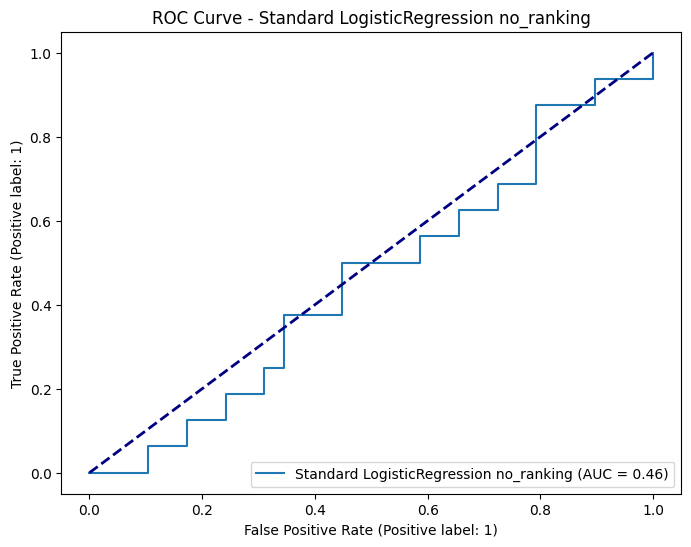

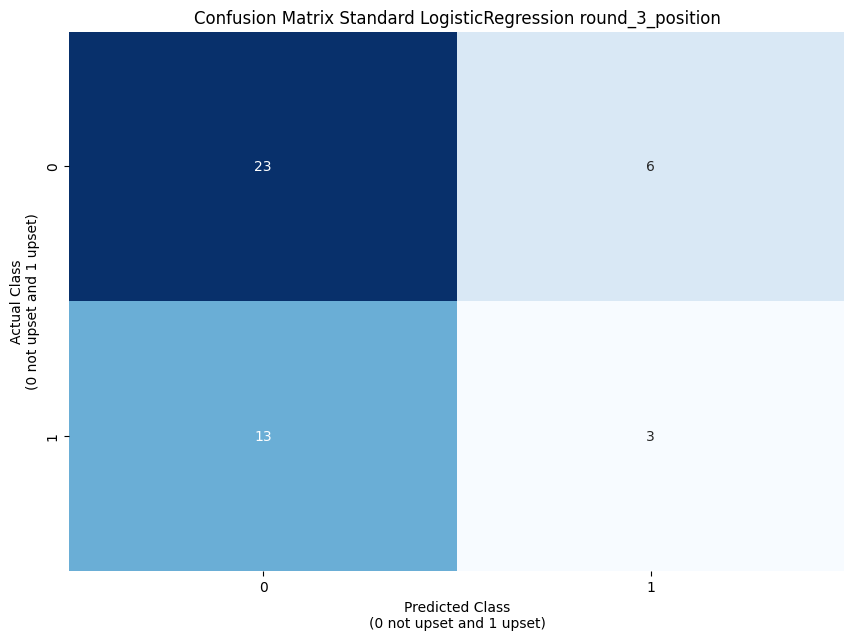

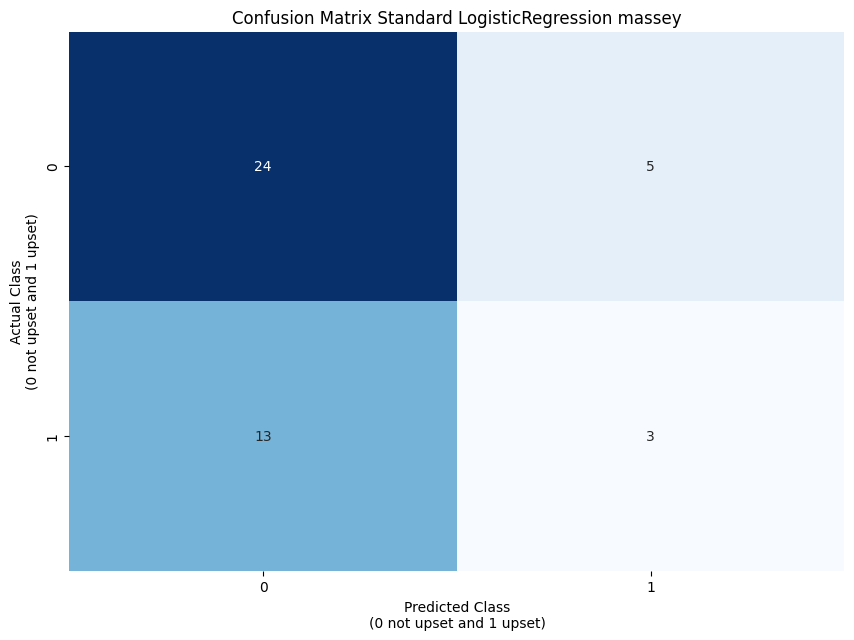

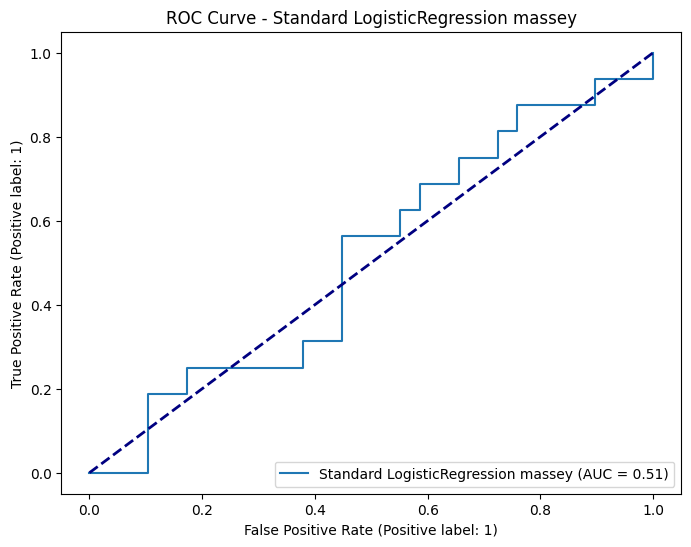

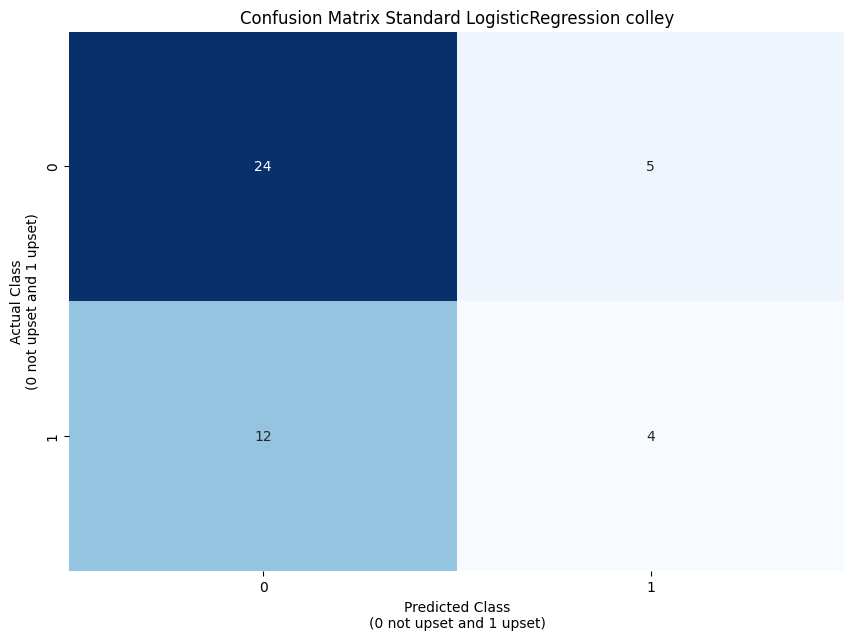

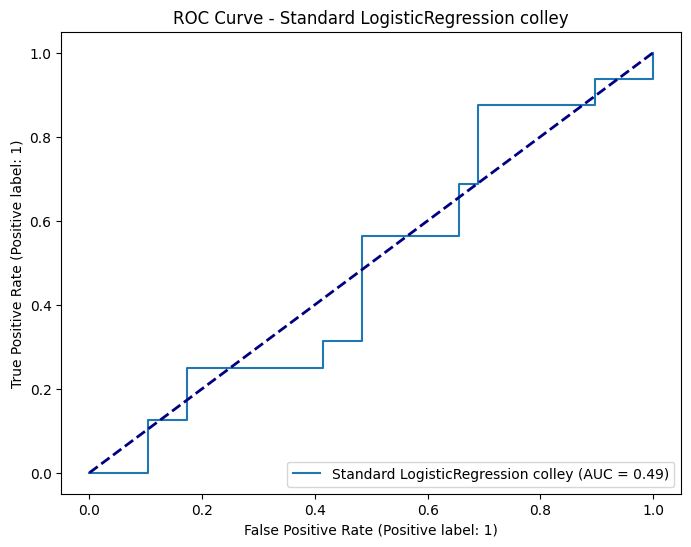

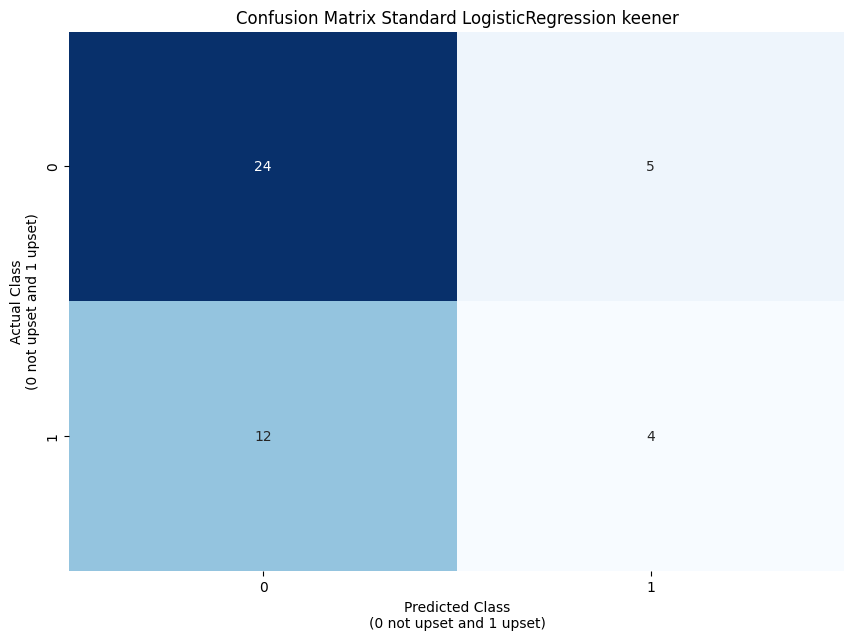

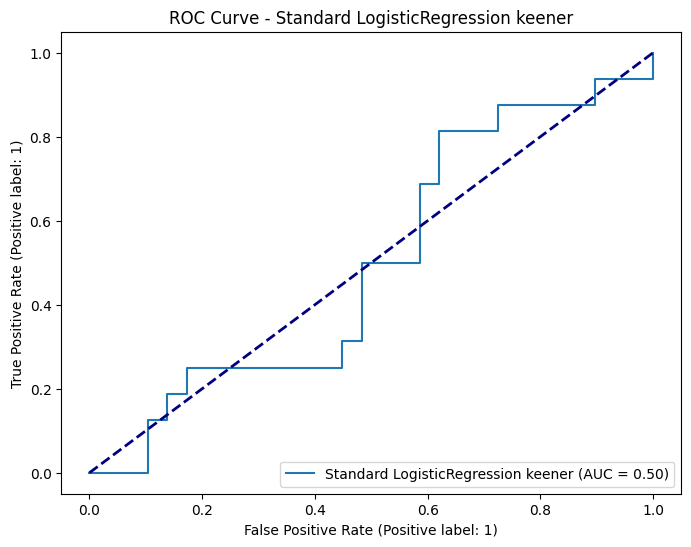

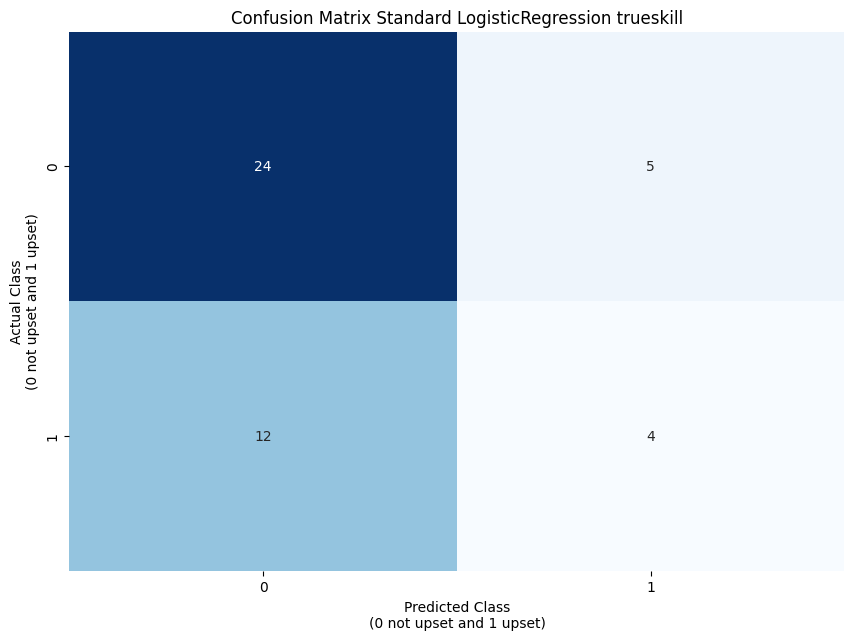

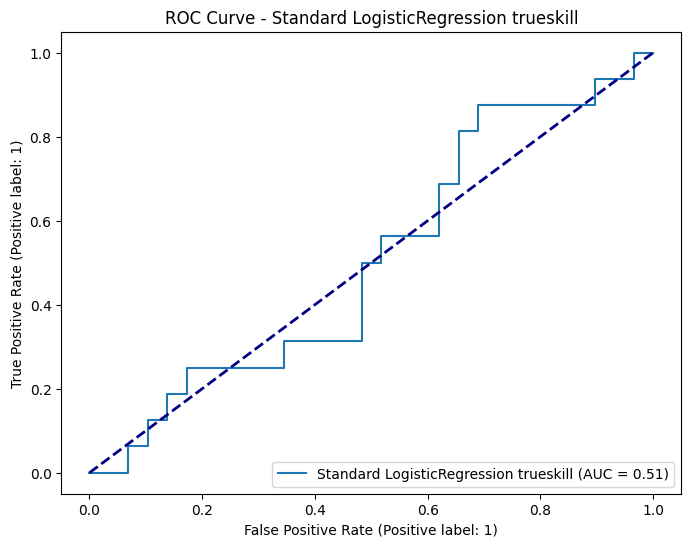

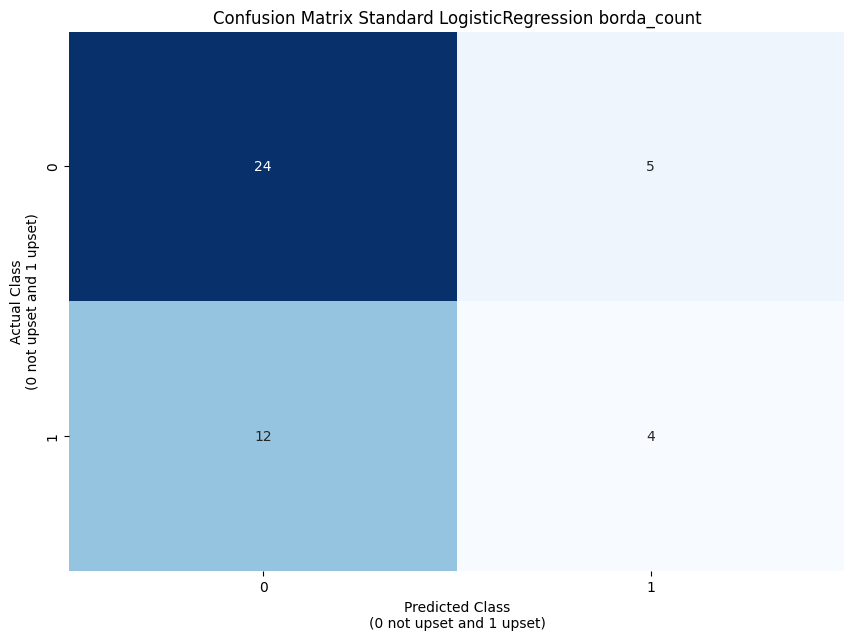

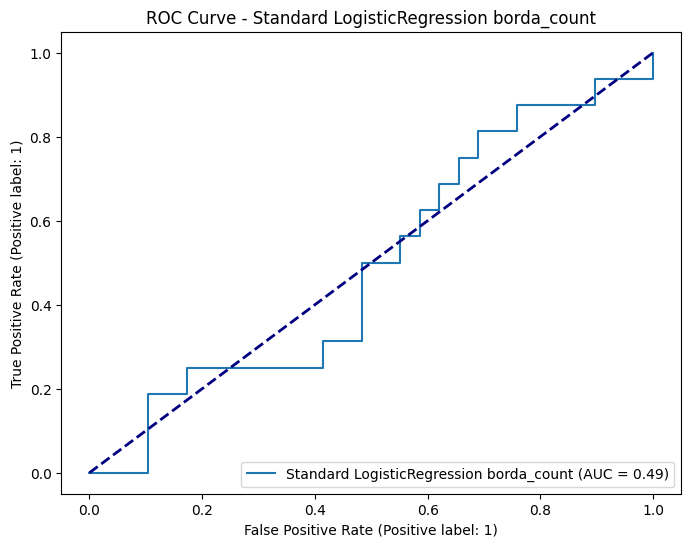

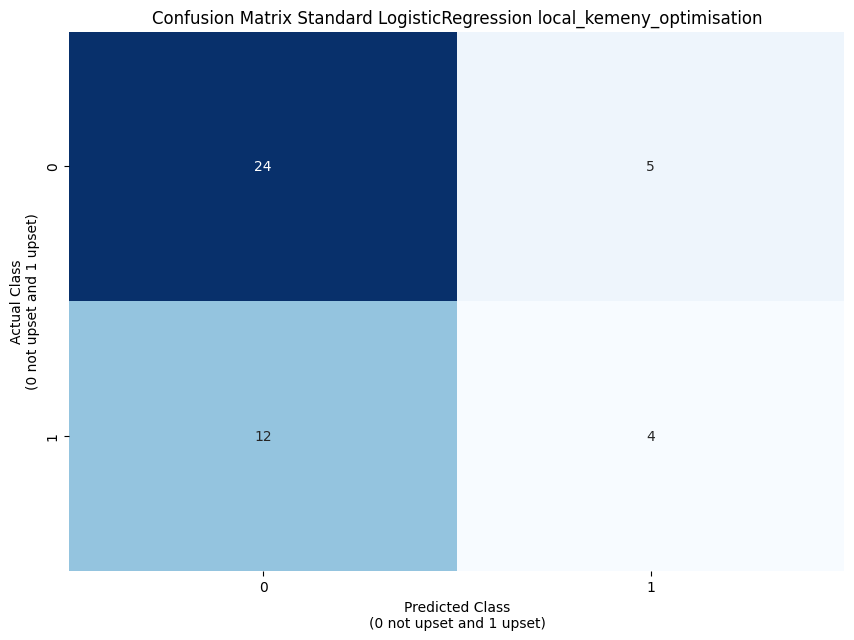

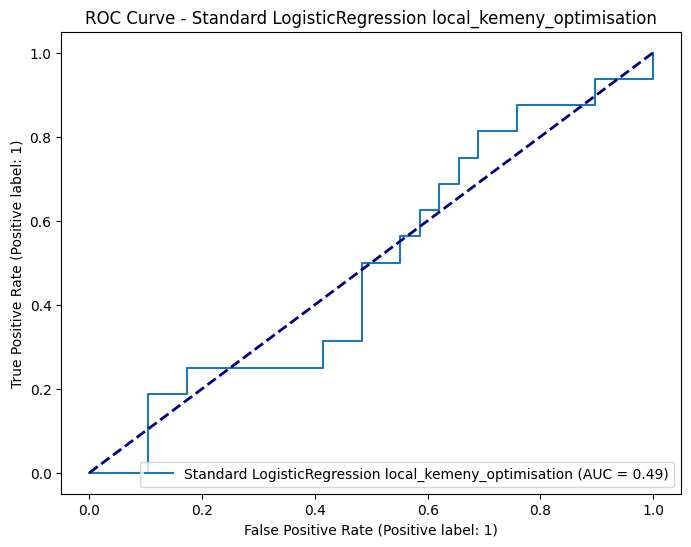

In [ ]:
# Standard, no weights
model_name = "Standard LogisticRegression"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)

all_results_df, fold_results_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_slr = all_results_df
display(all_results_df_slr)

fold_results_df_slr = fold_results_df
display(fold_results_df_slr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slr.to_excel("all_slr_results_unseen.xlsx")
fold_results_df_slr.to_excel("fold_results_slr_unseen.xlsx")



Standard LogisticRegression with home advantage no_ranking
Updated model parameters:
  C: 100.0
  class_weight: None
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 1000
  multi_class: auto
  n_jobs: None
  penalty: l1
  random_state: None
  solver: liblinear
  tol: 0.0001
  verbose: 0
  warm_start: False
numeric features ['home_win_factor', 'arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_vi

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2                    Unseen Standard Deviation   
2           3                         Unseen Accuracy Mean   
3           4           Unseen Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6        Unseen rain Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Standard LogisticRegression with home advantage local_kemeny_optimisation  
0                                               0.774                         
1                                               0.000                         
2                                               0.578                         
3                                               0.000                         
4                                               0.317                         
5                                               0.000                         
6                                               0.125                         
7                                               0.000                         
8                                               0.477                         
9                                               1.095                         
10                                              0.578                         
11                                             24.000                         
12                                              5.000                         
13                                             14.000                         
14                                              2.000                         
15                                              0.632                         
16                                              0.828                         
17                                              0.716                         
18                                              0.286                         
19                                              0.125                         
20                                              0.174                         
21                                              0.459                         
22                                              0.476                         
23                                              0.445                         
24                                              0.509                         
25                                              0.578                         
26                                              0.524                   

Actual  Predicted  arena_stadium_capacity  home_lineup_strength  \
0        0          0                   53394                  0.69   
1        0          0                   41837                  0.67   
2        0          0                   62850                   NaN   
3        0          0                   62850                  0.88   
4        0          0                   32050                  0.88   
5        1          0                   42682                  0.82   
6        0          0                   39460                  0.82   
7        1          0                   11700                  0.82   
8        1          0                   52409                  0.72   
9        1          0                   21944                  0.81   
10       0          0                   18500                  0.77   
11       0          0                   26445                  0.85   
12       0          0                   34988                  0.89   
13       0          0                   26445                  0.87   
14       0          0                   10226                  0.79   
15       0          1                   30089                  0.73   
16       1          0                   30445                  0.81   
17       0          0                   20146                  0.71   
18       1          0                   32609                  0.83   
19       0          1                   25400                  0.82   
20       0          0                    <NA>                  0.79   
21       1          0                   29409                  0.61   
22       0          0                   25400                  0.76   
23       0          0                   15314                  0.83   
24       1          0                   17338                  0.83   
25       0          0                   23287                  0.76   
26       1          0                   25138                  0.82   
27       1          0                   39732                  0.76   
28       1          0                   29673                  0.78   
29       0          0                   27111                  0.69   
30       0          0                   12500                  0.72   
31       0          0                    9875                  0.82   
32       1          0                    5327                  0.79   
33       0          0                   15728                  0.85   
34       0          0                    5057                  0.76   
35       0          0                   10000                  0.69   
36       0          1                   18947                  0.78   
37       0          1                    5140                  0.75   
38       1          0                    7691                  0.76   
39       1          0                    9546                  0.75   
40       0          0                   11582                   NaN   
41       0          0                    7691                  0.62   
42       1          1                    4502                  0.70   
43       0          1                    9527                  0.72   
44       1          1                    6238                   NaN   

    home_team_league_form  home_team_league_form_home_and_away  \
0                    0.83                                 0.44   
1                    0.39                                 0.39   
2                    0.00                                 0.39   
3                    0.56                                 0.39   
4                    0.00                                 0.72   
5                    0.39                                 0.56   
6                    0.00                                 0.11   
7                    0.00                                 0.17   
8                    0.00                                 0.28   
9                    0.22                                 0.17   
10         

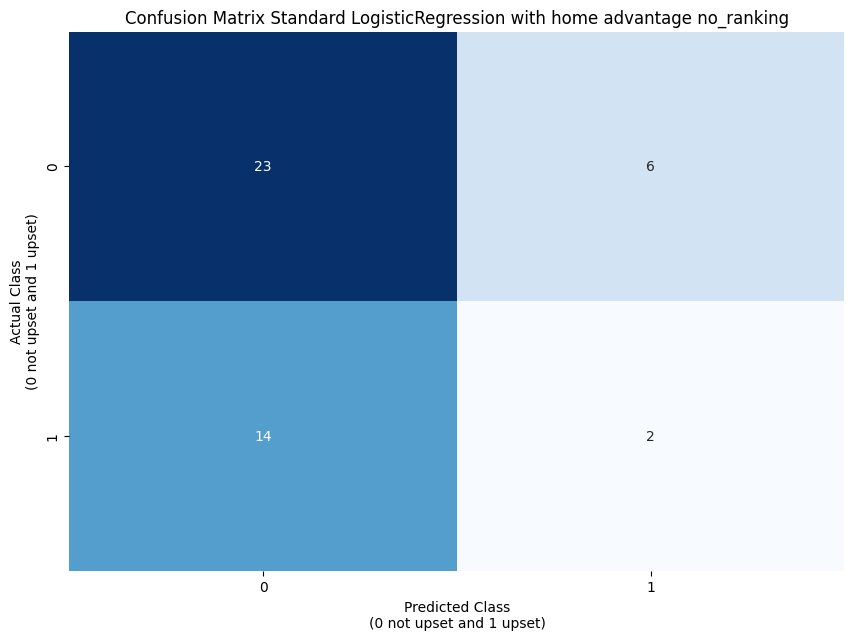

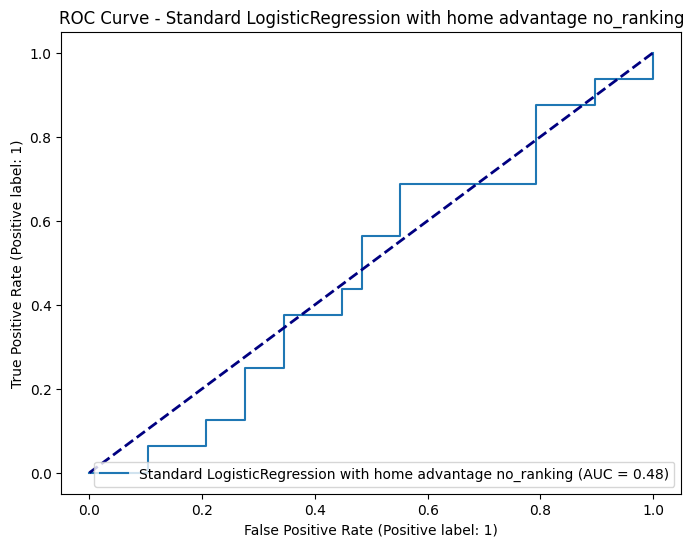

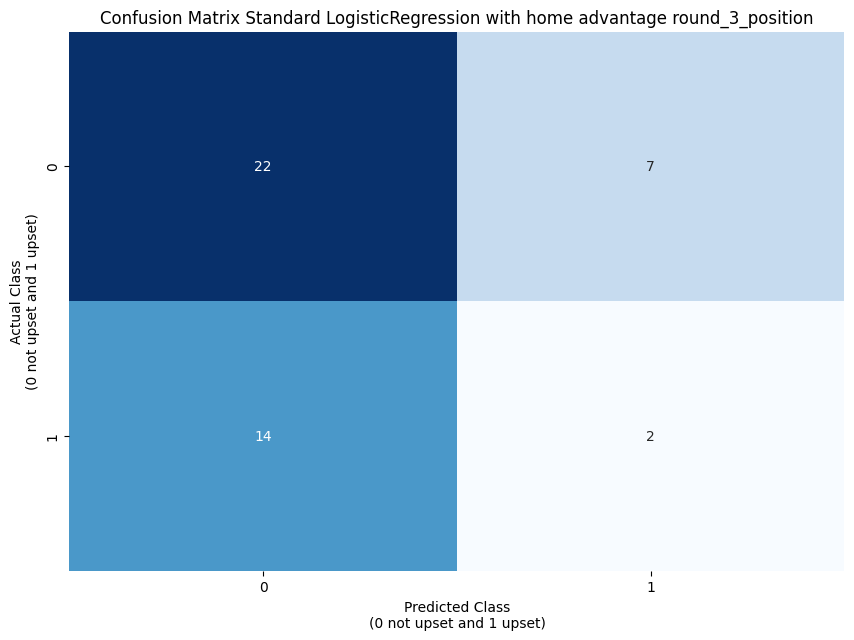

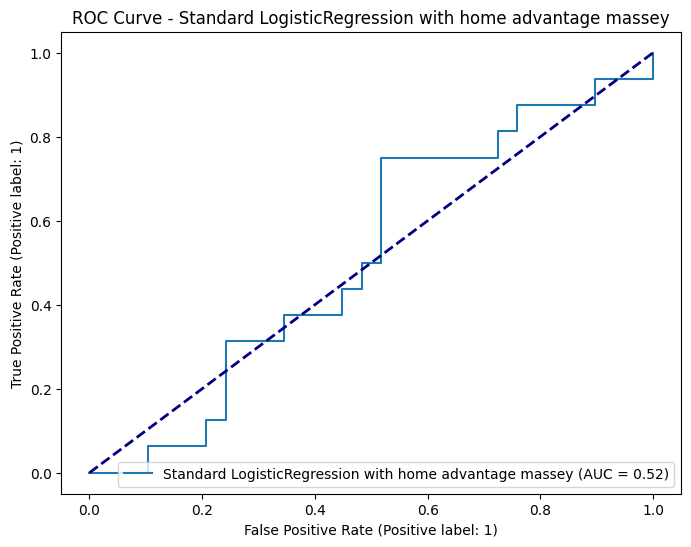

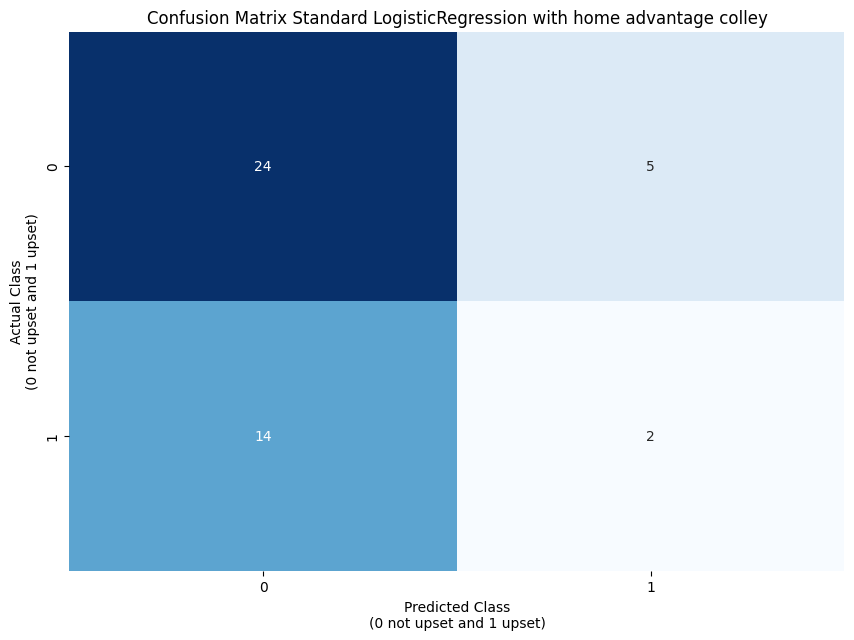

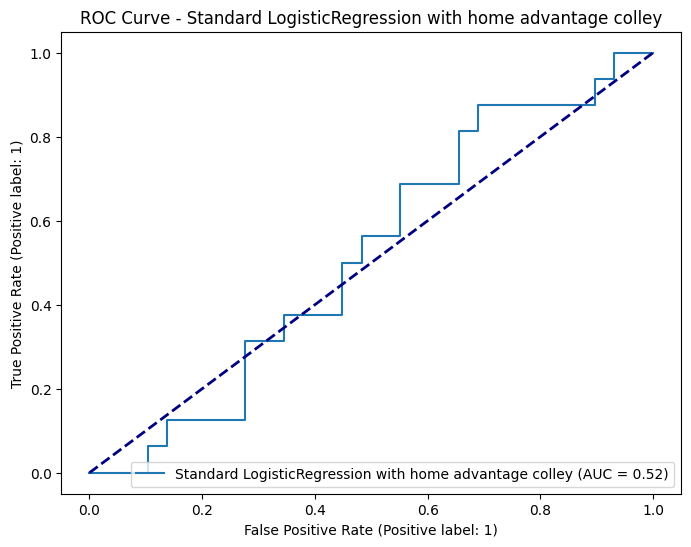

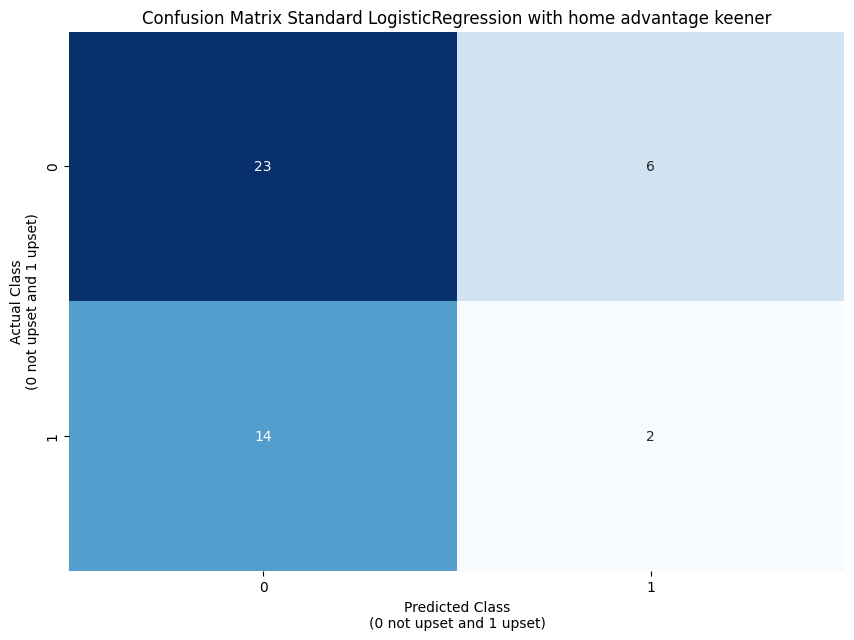

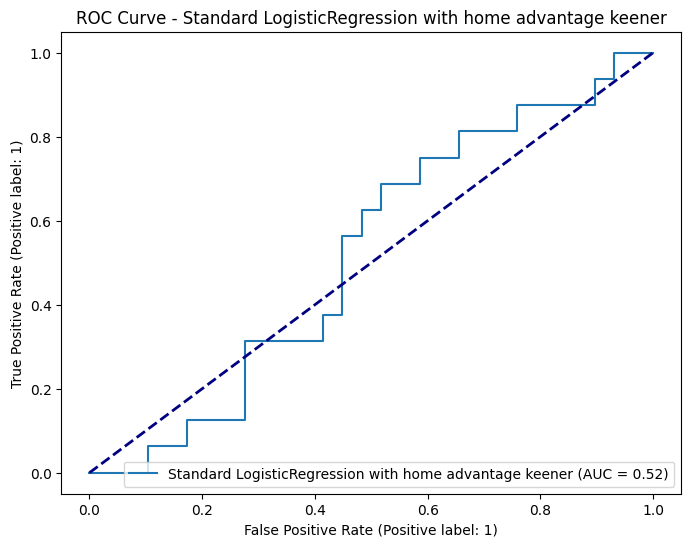

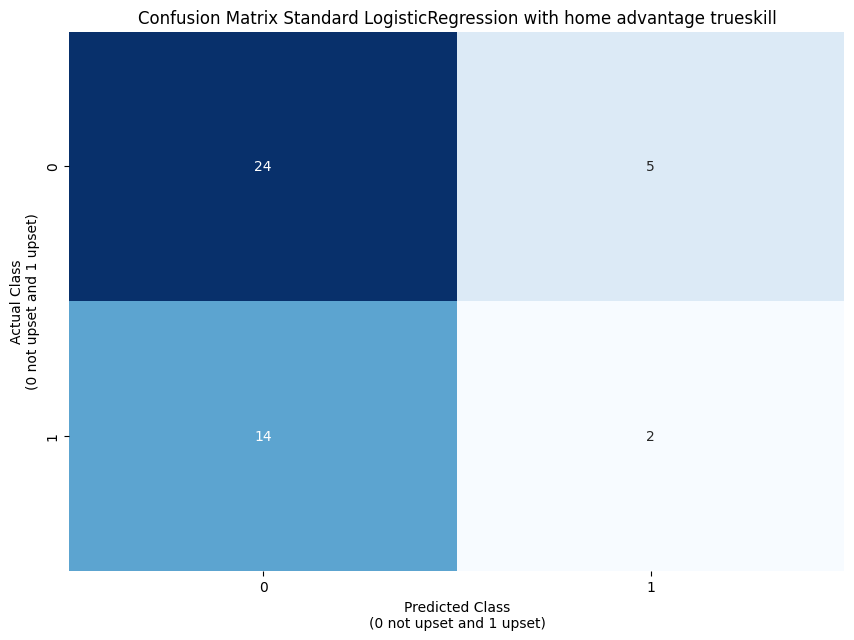

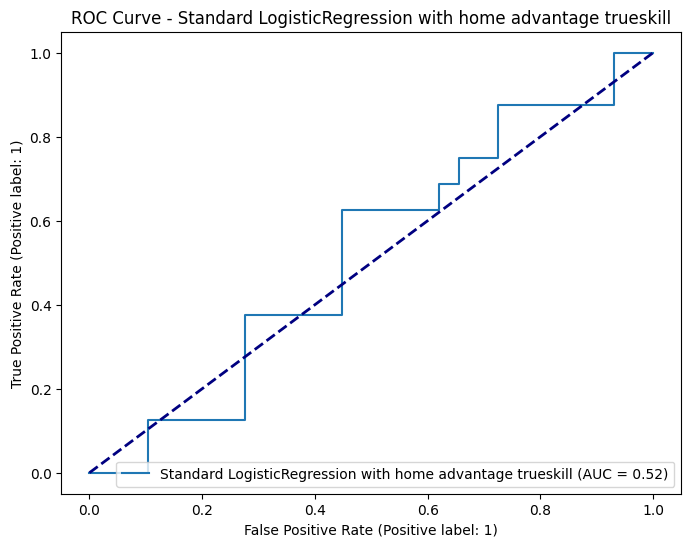

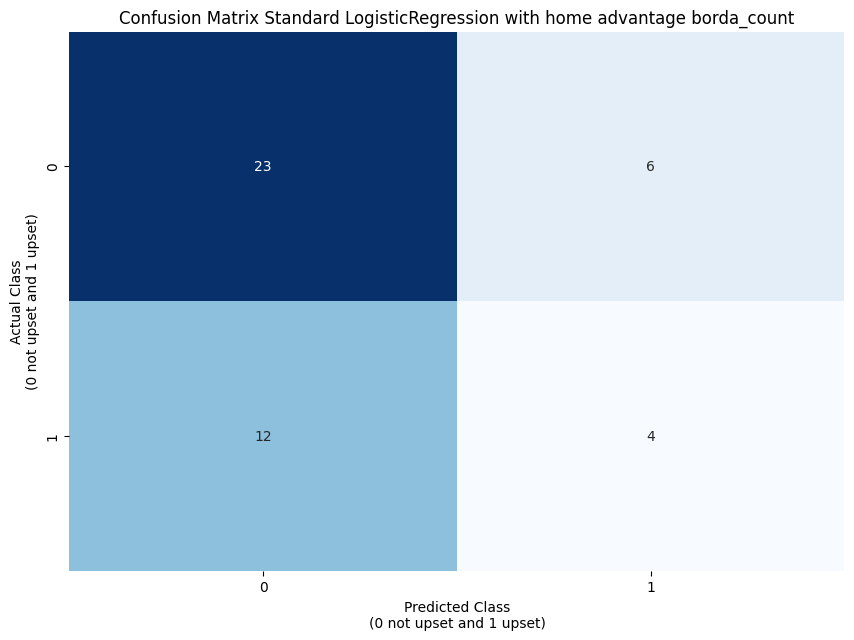

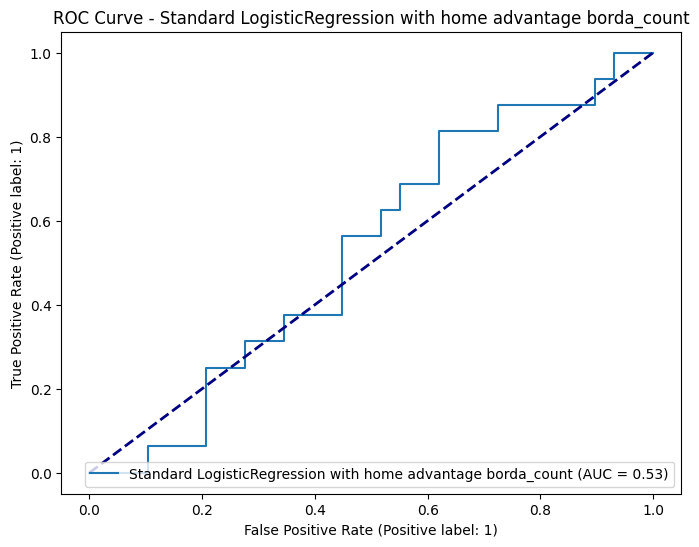

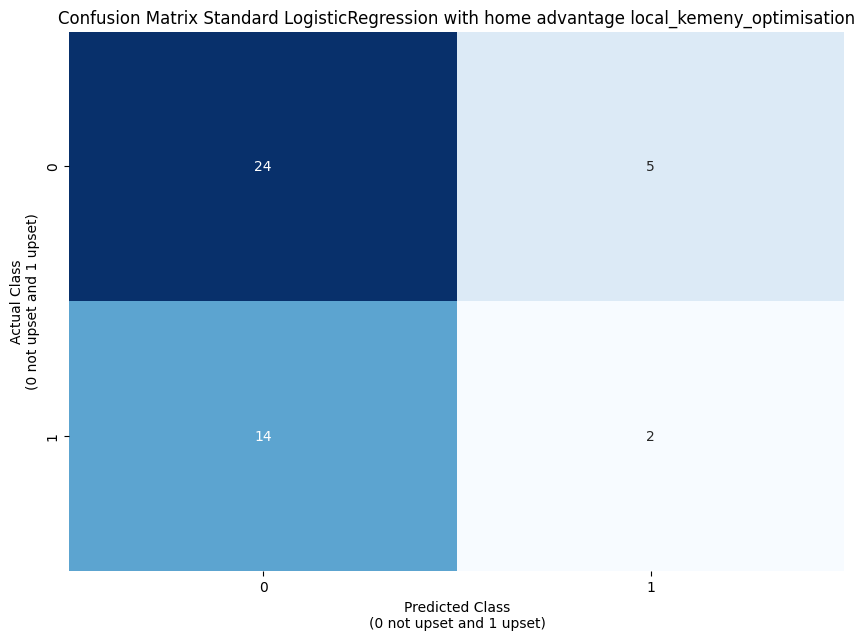

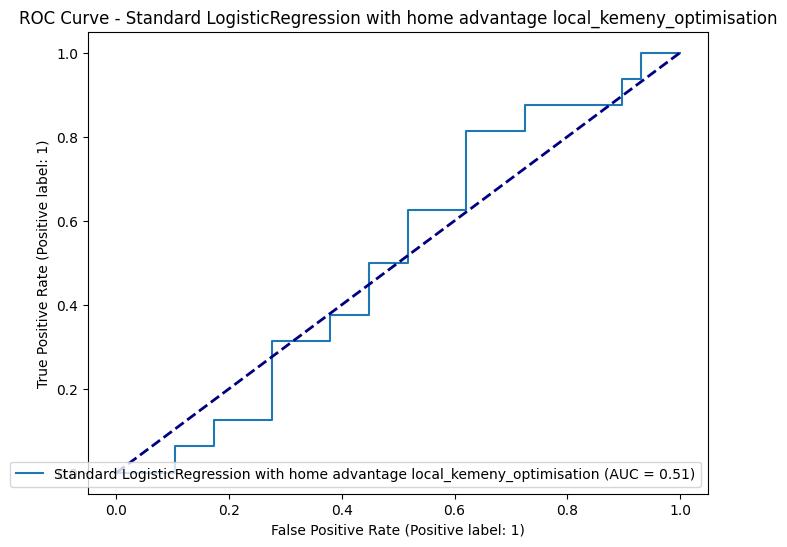

In [ ]:
# Standard, no weights with home advantage
model_name = "Standard LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)


all_results_df, fold_results_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_slrh = all_results_df
display(all_results_df_slrh)

fold_results_df_slrh = fold_results_df
display(fold_results_df_slrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slrh.to_excel("all_slrh_results_unseen.xlsx")
fold_results_df_slrh.to_excel("fold_results_slrh_unseen.xlsx")

Weighted LogisticRegression no_ranking
Updated model parameters:
  C: 10.0
  class_weight: {0: 50, 1: 50}
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 1000
  multi_class: auto
  n_jobs: None
  penalty: l1
  random_state: None
  solver: liblinear
  tol: 0.0001
  verbose: 0
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data_hours_visibility', 'match_weather_data

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2                    Unseen Standard Deviation   
2           3                         Unseen Accuracy Mean   
3           4           Unseen Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6        Unseen rain Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Weighted LogisticRegression local_kemeny_optimisation  
0                                               0.757     
1                                               0.000     
2                                               0.622     
3                                               0.000     
4                                               0.280     
5                                               0.000     
6                                               0.250     
7                                               0.000     
8                                               0.480     
9                                               1.056     
10                                              0.622     
11                                             24.000     
12                                              5.000     
13                                             12.000     
14                                              4.000     
15                                              0.667     
16                                              0.828     
17                                              0.738     
18                                              0.444     
19                                              0.250     
20                                              0.320     
21                                              0.556     
22                                              0.539     
23                                              0.529     
24                                              0.588     
25                                              0.622     
26                                              0.590     
27                                              0.502

Actual  Predicted  arena_stadium_capacity  home_lineup_strength  \
0        0          0                   53394                  0.69   
1        0          0                   41837                  0.67   
2        0          0                   62850                   NaN   
3        0          0                   62850                  0.88   
4        0          0                   32050                  0.88   
5        1          0                   42682                  0.82   
6        0          0                   39460                  0.82   
7        1          0                   11700                  0.82   
8        1          0                   52409                  0.72   
9        1          0                   21944                  0.81   
10       0          0                   18500                  0.77   
11       0          0                   26445                  0.85   
12       0          0                   34988                  0.89   
13       0          0                   26445                  0.87   
14       0          1                   10226                  0.79   
15       0          1                   30089                  0.73   
16       1          0                   30445                  0.81   
17       0          0                   20146                  0.71   
18       1          0                   32609                  0.83   
19       0          1                   25400                  0.82   
20       0          0                    <NA>                  0.79   
21       1          0                   29409                  0.61   
22       0          0                   25400                  0.76   
23       0          0                   15314                  0.83   
24       1          0                   17338                  0.83   
25       0          0                   23287                  0.76   
26       1          0                   25138                  0.82   
27       1          0                   39732                  0.76   
28       1          0                   29673                  0.78   
29       0          0                   27111                  0.69   
30       0          0                   12500                  0.72   
31       0          0                    9875                  0.82   
32       1          1                    5327                  0.79   
33       0          0                   15728                  0.85   
34       0          0                    5057                  0.76   
35       0          0                   10000                  0.69   
36       0          1                   18947                  0.78   
37       0          1                    5140                  0.75   
38       1          0                    7691                  0.76   
39       1          1                    9546                  0.75   
40       0          0                   11582                   NaN   
41       0          0                    7691                  0.62   
42       1          1                    4502                  0.70   
43       0          0                    9527                  0.72   
44       1          1                    6238                   NaN   

    home_team_league_form  home_team_league_form_home_and_away  \
0                    0.83                                 0.44   
1                    0.39                                 0.39   
2                    0.00                                 0.39   
3                    0.56                                 0.39   
4                    0.00                                 0.72   
5                    0.39                                 0.56   
6                    0.00                                 0.11   
7                    0.00                                 0.17   
8                    0.00                                 0.28   
9                    0.22                                 0.17   
10         

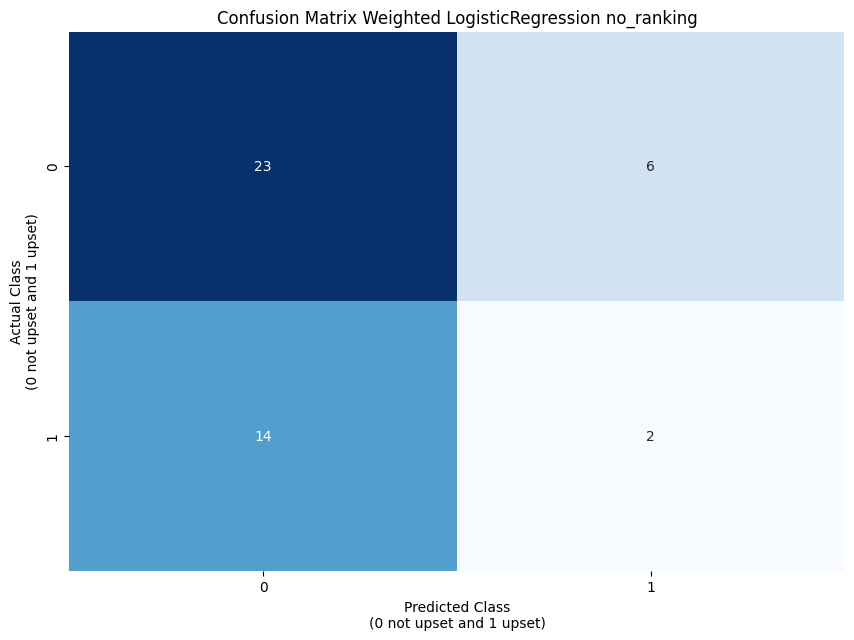

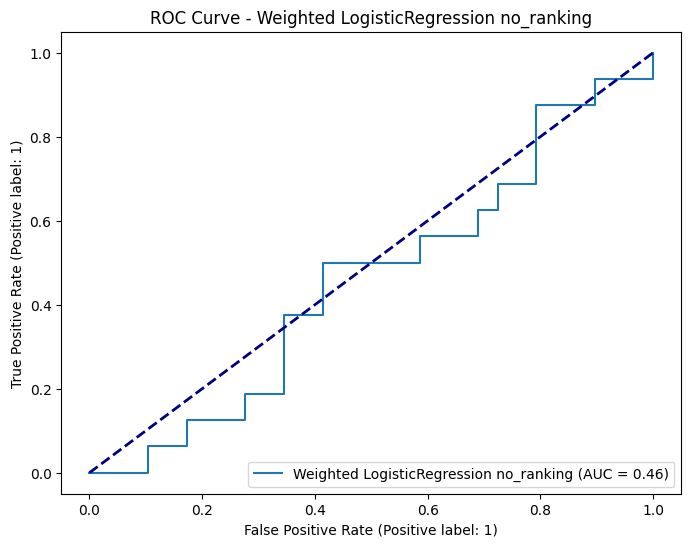

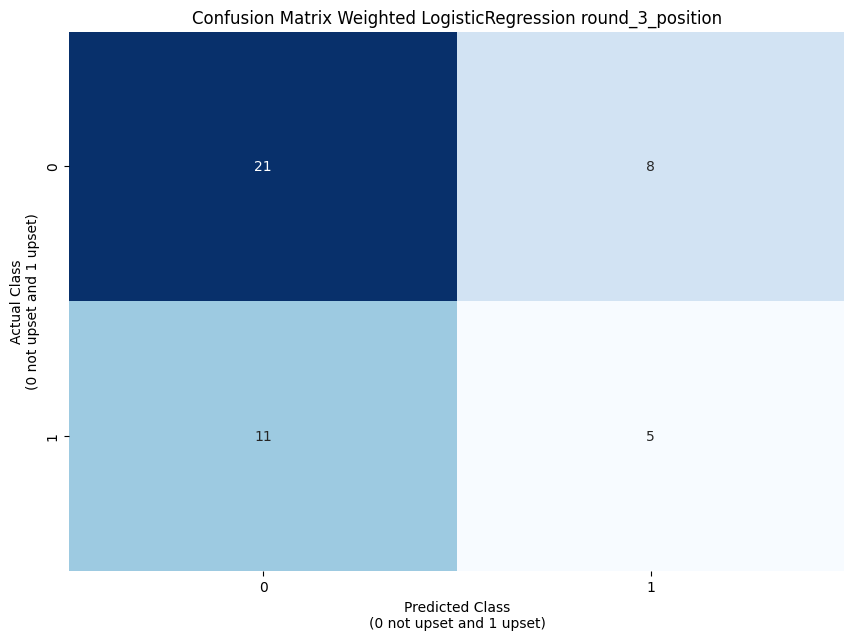

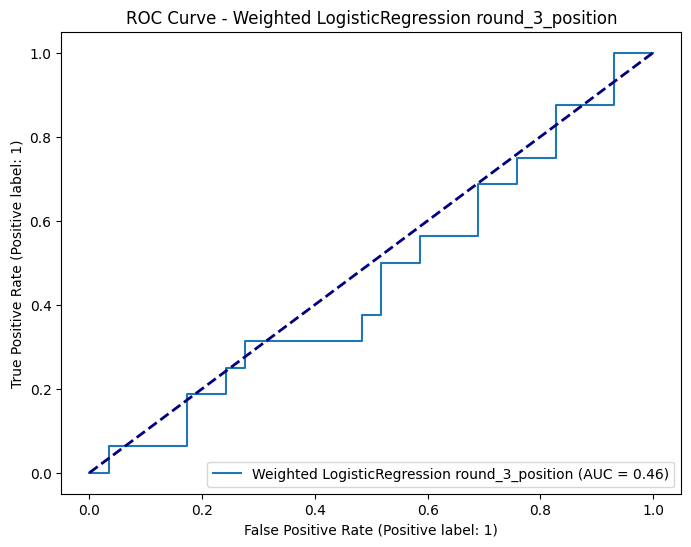

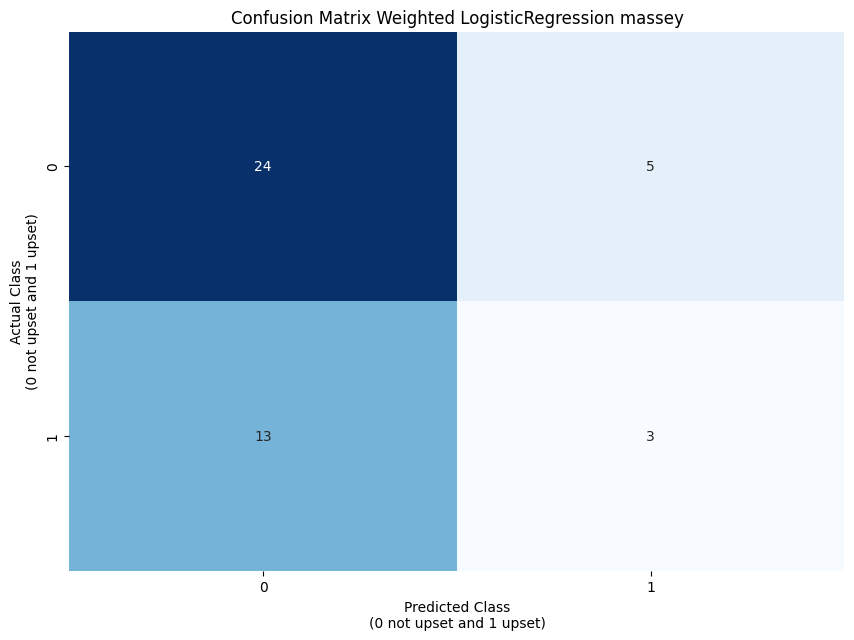

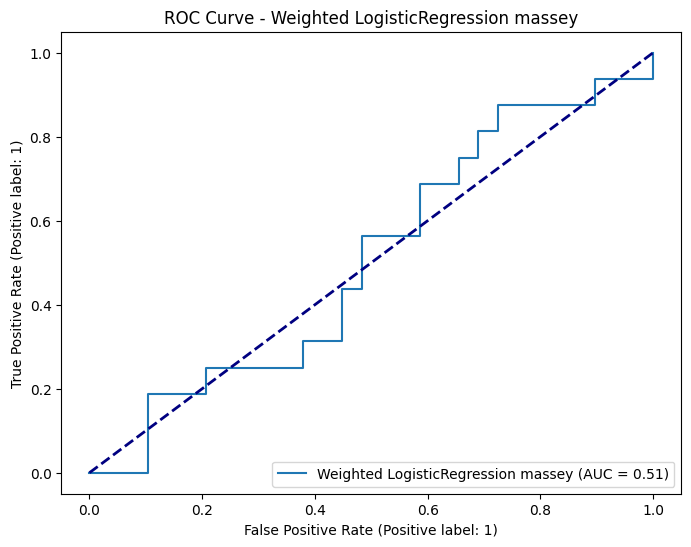

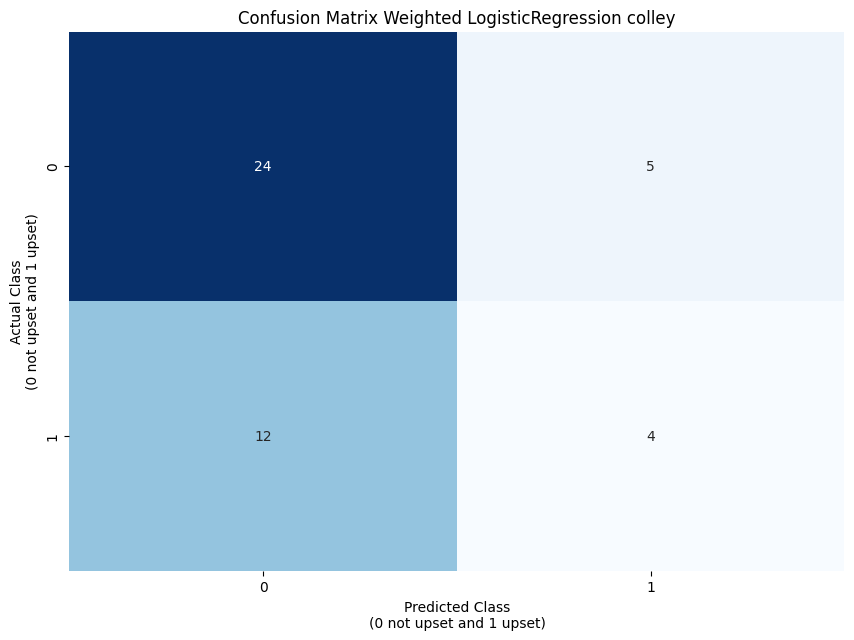

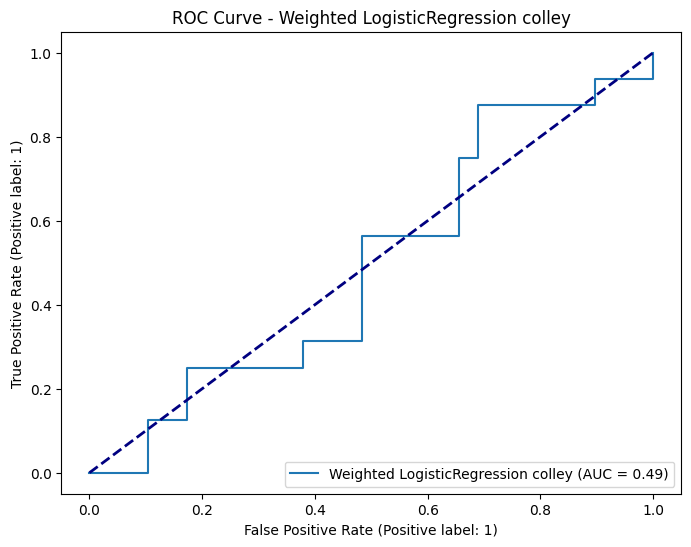

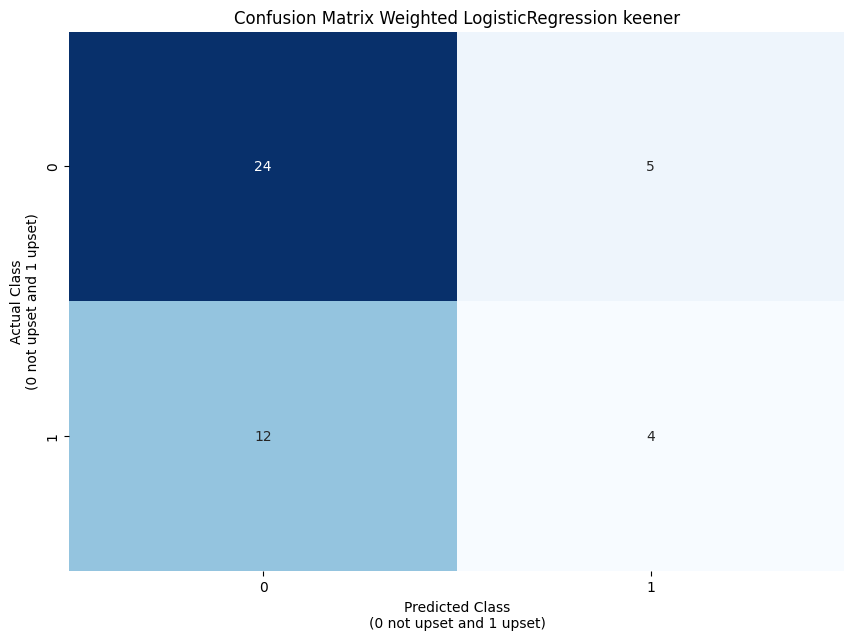

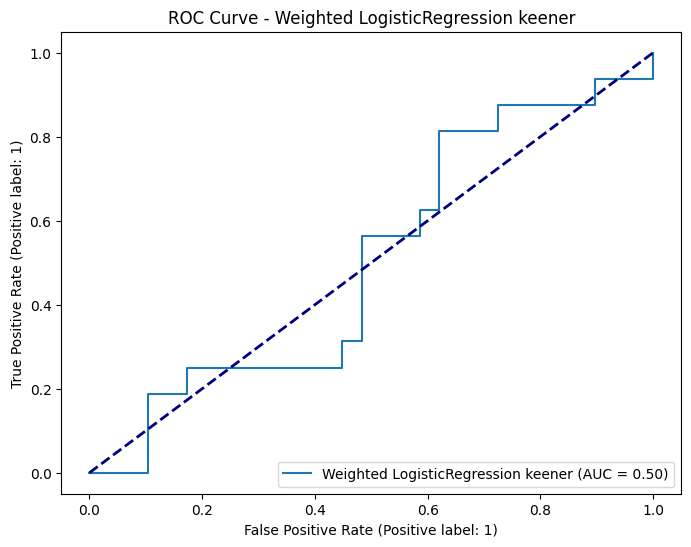

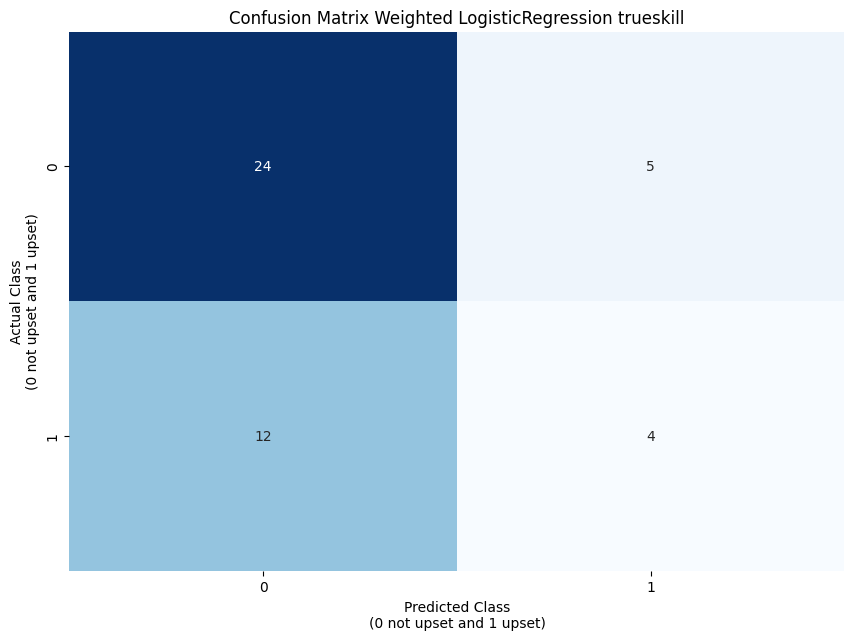

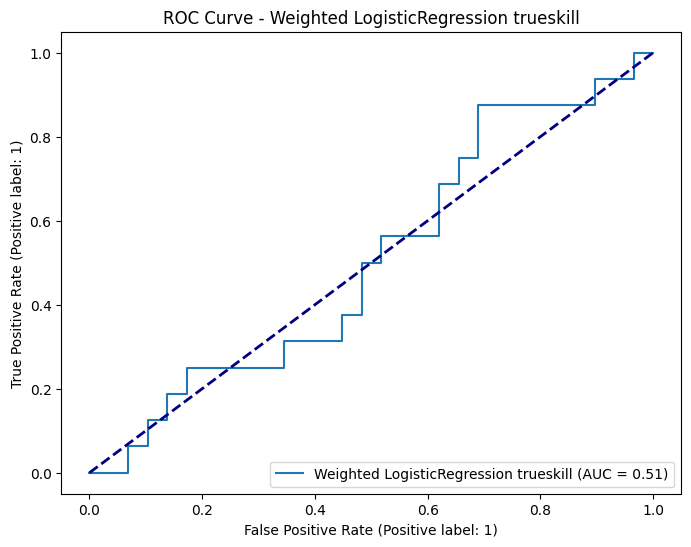

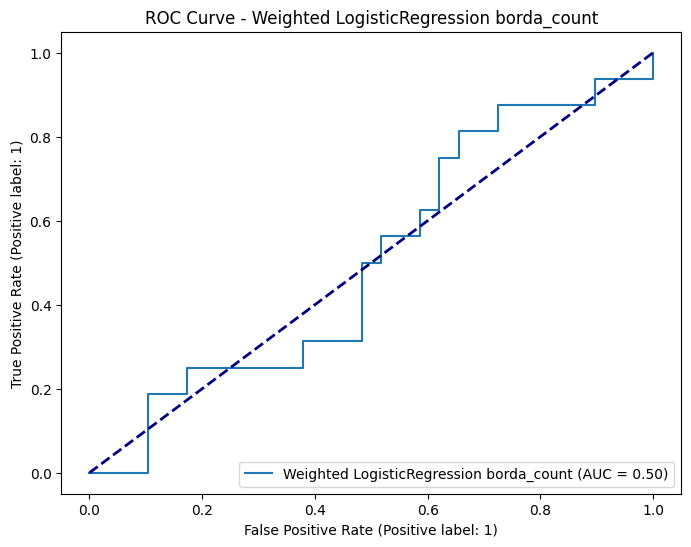

In [ ]:
0# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"
home_advt = 'no'
weighted = 'yes'
random_state = 47
weights = {0: 50, 1: 50} # intial value before recalauclating
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

all_results_df, fold_results_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_wlr = all_results_df
display(all_results_df_wlr)

fold_results_df_wlr = fold_results_df
display(fold_results_df_wlr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlr.to_excel("all_wlr_results_unseen.xlsx")
fold_results_df_wlr.to_excel("fold_results_wlr_unseen.xlsx")

Weighted LogisticRegression with home advantage no_ranking
Updated model parameters:
  C: 10.0
  class_weight: {0: 50, 1: 50}
  dual: False
  fit_intercept: True
  intercept_scaling: 1
  l1_ratio: None
  max_iter: 1000
  multi_class: auto
  n_jobs: None
  penalty: l1
  random_state: None
  solver: liblinear
  tol: 0.0001
  verbose: 0
  warm_start: False
numeric features ['home_win_factor', 'arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', 'match_weather_data_hours_pressure', 'match_weather_data

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2                    Unseen Standard Deviation   
2           3                         Unseen Accuracy Mean   
3           4           Unseen Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6        Unseen rain Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Weighted LogisticRegression with home advantage local_kemeny_optimisation  
0                                               0.770                         
1                                               0.000                         
2                                               0.578                         
3                                               0.000                         
4                                               0.305                         
5                                               0.000                         
6                                               0.125                         
7                                               0.000                         
8                                               0.477                         
9                                               1.077                         
10                                              0.578                         
11                                             24.000                         
12                                              5.000                         
13                                             14.000                         
14                                              2.000                         
15                                              0.632                         
16                                              0.828                         
17                                              0.716                         
18                                              0.286                         
19                                              0.125                         
20                                              0.174                         
21                                              0.459                         
22                                              0.476                         
23                                              0.445                         
24                                              0.509                         
25                                              0.578                         
26                                              0.524                   

Actual  Predicted  arena_stadium_capacity  home_lineup_strength  \
0        0          0                   53394                  0.69   
1        0          0                   41837                  0.67   
2        0          0                   62850                   NaN   
3        0          0                   62850                  0.88   
4        0          0                   32050                  0.88   
5        1          0                   42682                  0.82   
6        0          0                   39460                  0.82   
7        1          0                   11700                  0.82   
8        1          0                   52409                  0.72   
9        1          0                   21944                  0.81   
10       0          0                   18500                  0.77   
11       0          0                   26445                  0.85   
12       0          0                   34988                  0.89   
13       0          0                   26445                  0.87   
14       0          0                   10226                  0.79   
15       0          1                   30089                  0.73   
16       1          0                   30445                  0.81   
17       0          0                   20146                  0.71   
18       1          0                   32609                  0.83   
19       0          1                   25400                  0.82   
20       0          0                    <NA>                  0.79   
21       1          0                   29409                  0.61   
22       0          0                   25400                  0.76   
23       0          0                   15314                  0.83   
24       1          0                   17338                  0.83   
25       0          0                   23287                  0.76   
26       1          0                   25138                  0.82   
27       1          0                   39732                  0.76   
28       1          0                   29673                  0.78   
29       0          0                   27111                  0.69   
30       0          0                   12500                  0.72   
31       0          0                    9875                  0.82   
32       1          0                    5327                  0.79   
33       0          0                   15728                  0.85   
34       0          0                    5057                  0.76   
35       0          0                   10000                  0.69   
36       0          1                   18947                  0.78   
37       0          1                    5140                  0.75   
38       1          0                    7691                  0.76   
39       1          0                    9546                  0.75   
40       0          0                   11582                   NaN   
41       0          0                    7691                  0.62   
42       1          1                    4502                  0.70   
43       0          1                    9527                  0.72   
44       1          1                    6238                   NaN   

    home_team_league_form  home_team_league_form_home_and_away  \
0                    0.83                                 0.44   
1                    0.39                                 0.39   
2                    0.00                                 0.39   
3                    0.56                                 0.39   
4                    0.00                                 0.72   
5                    0.39                                 0.56   
6                    0.00                                 0.11   
7                    0.00                                 0.17   
8                    0.00                                 0.28   
9                    0.22                                 0.17   
10         

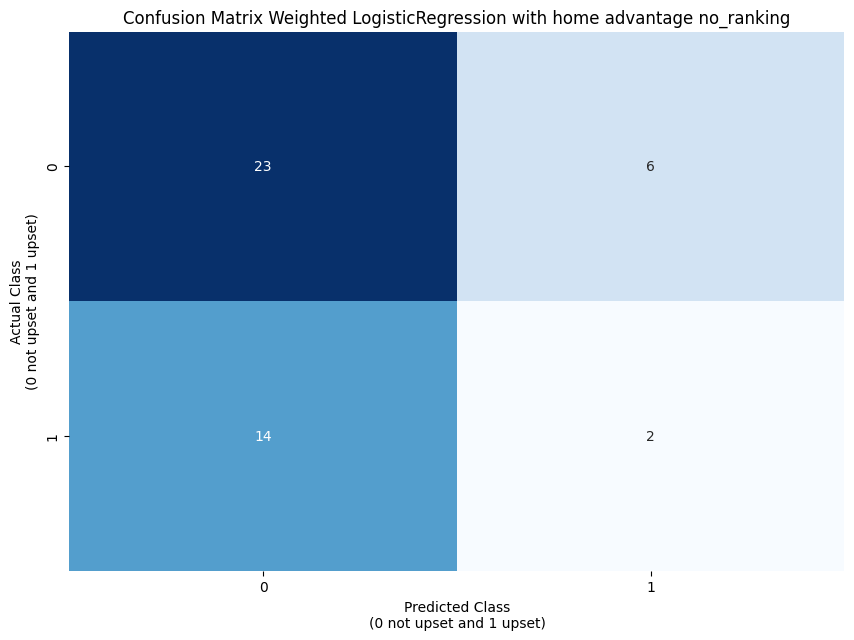

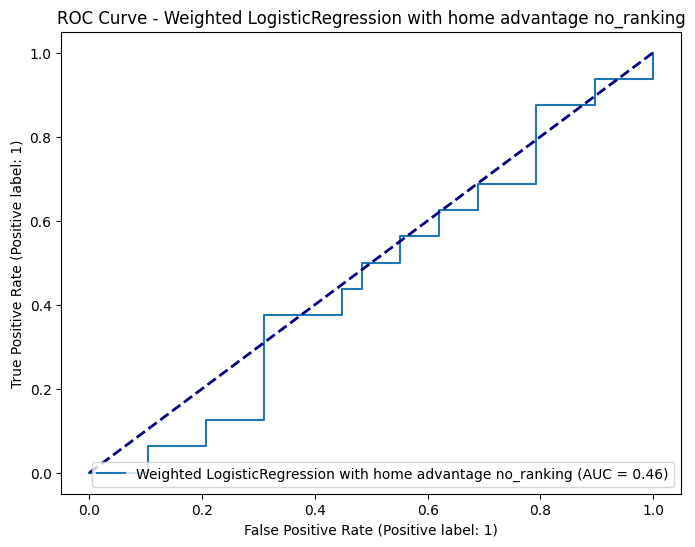

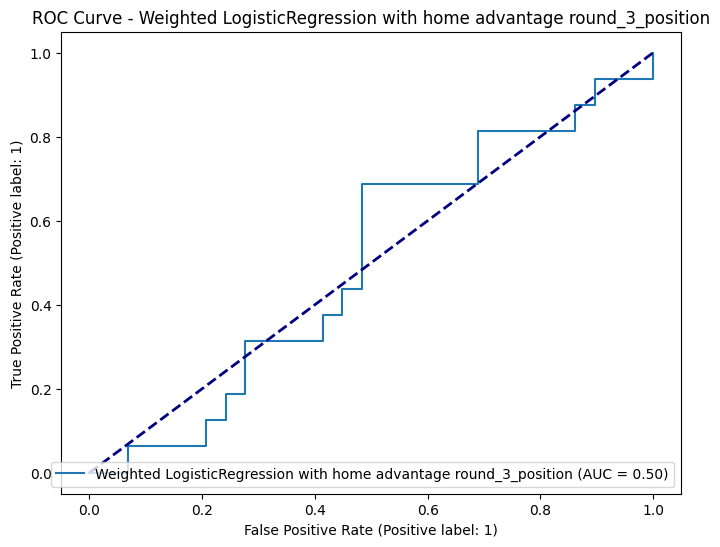

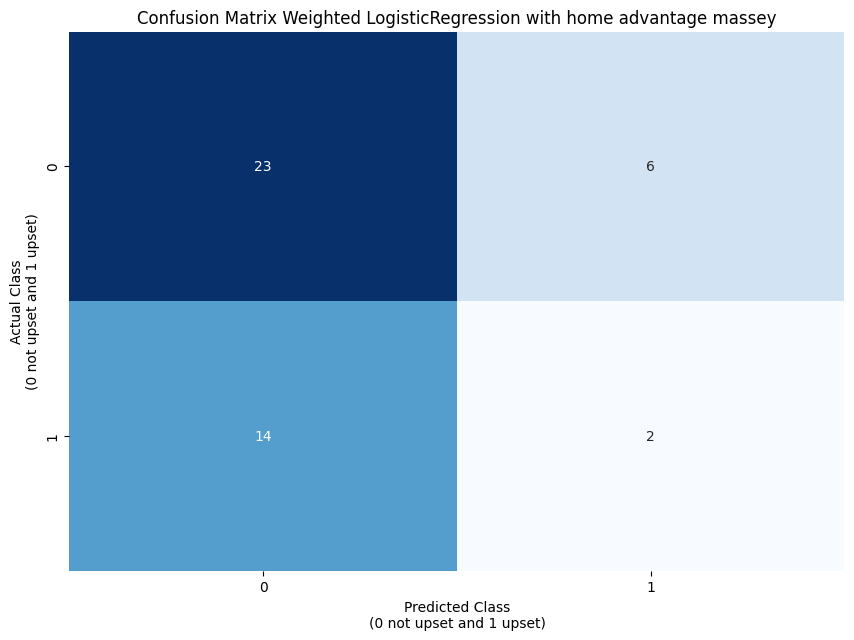

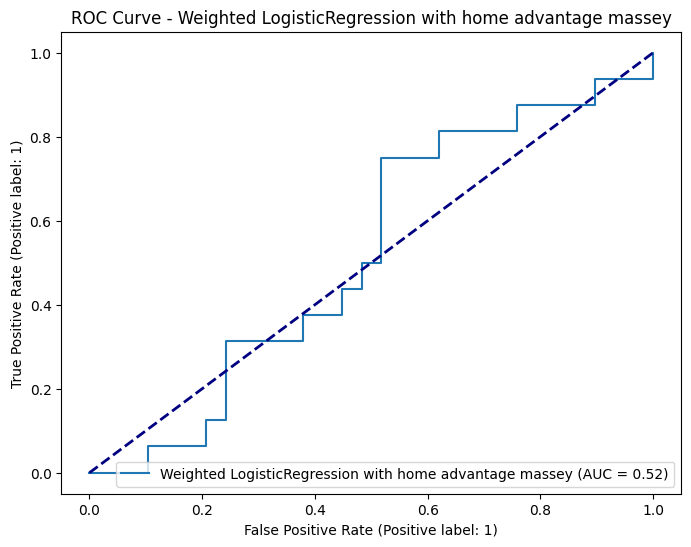

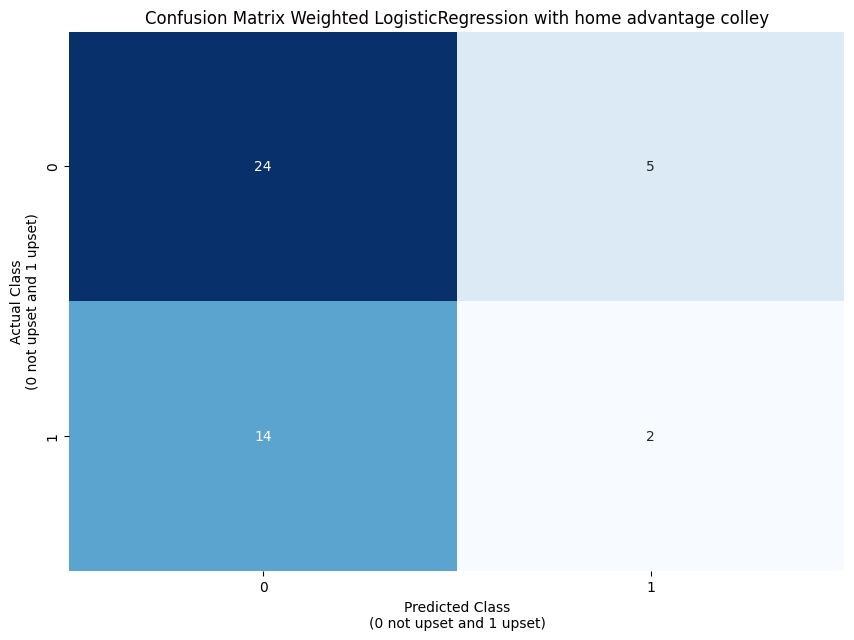

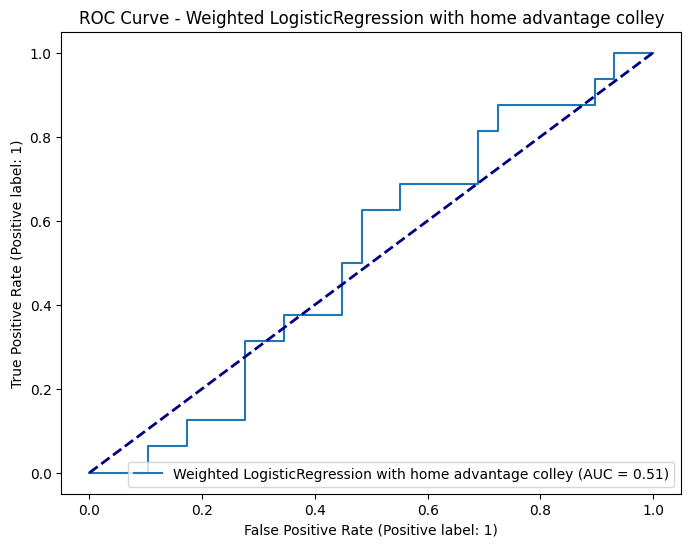

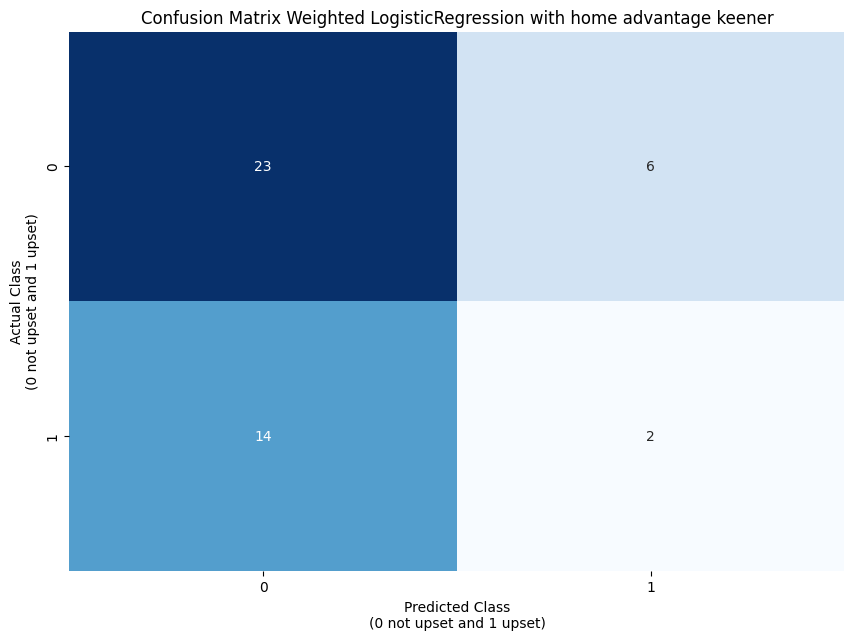

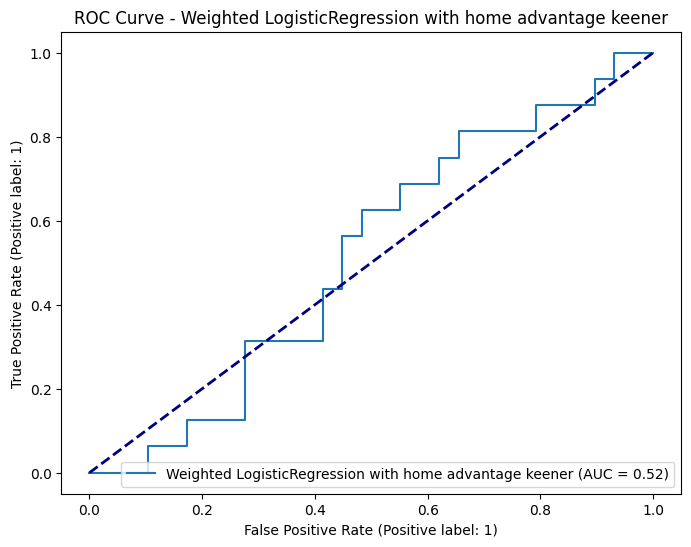

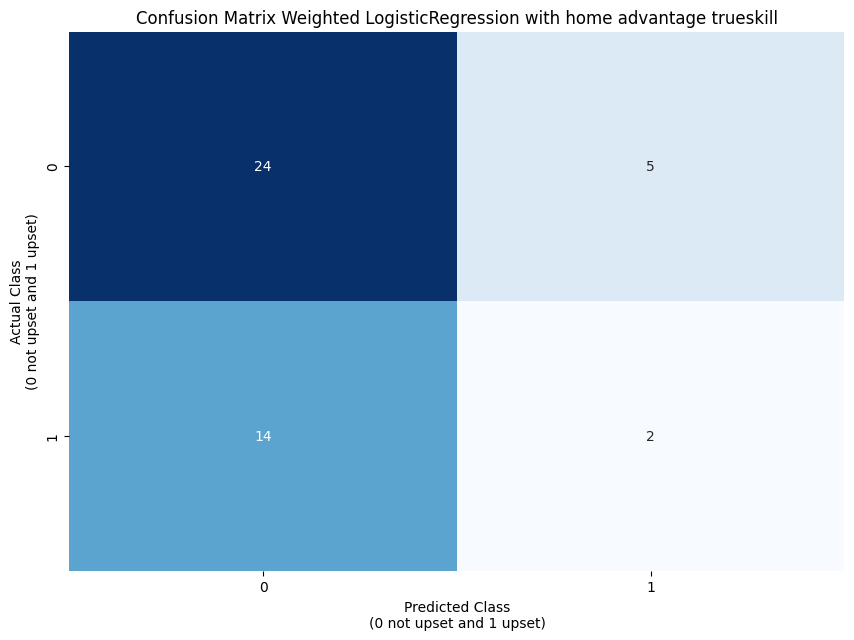

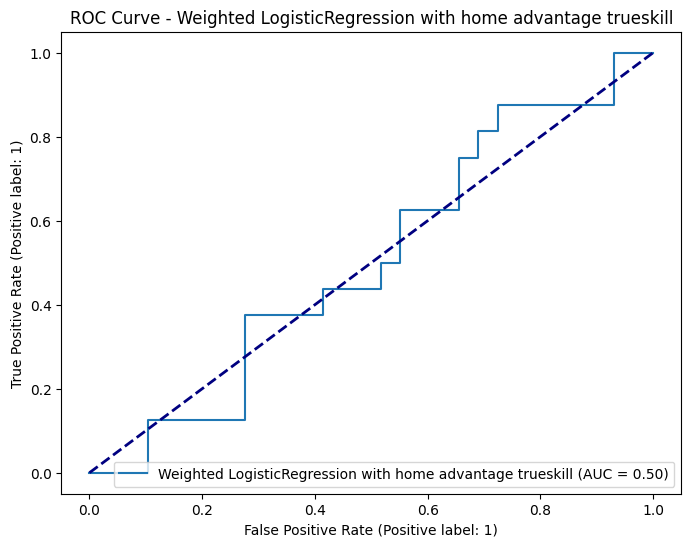

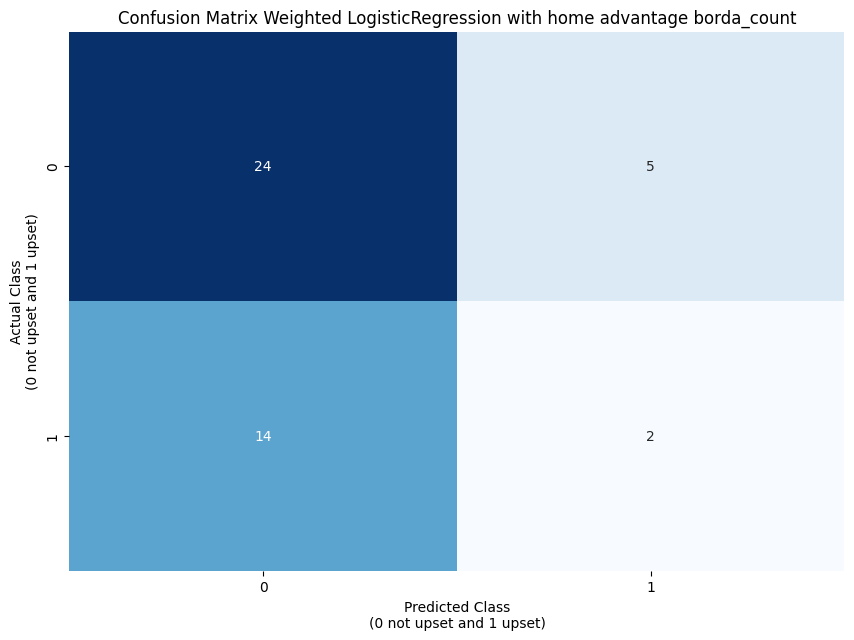

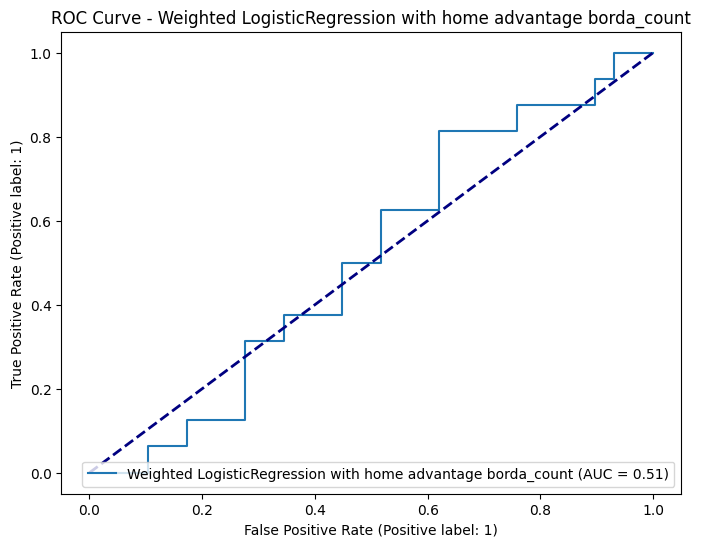

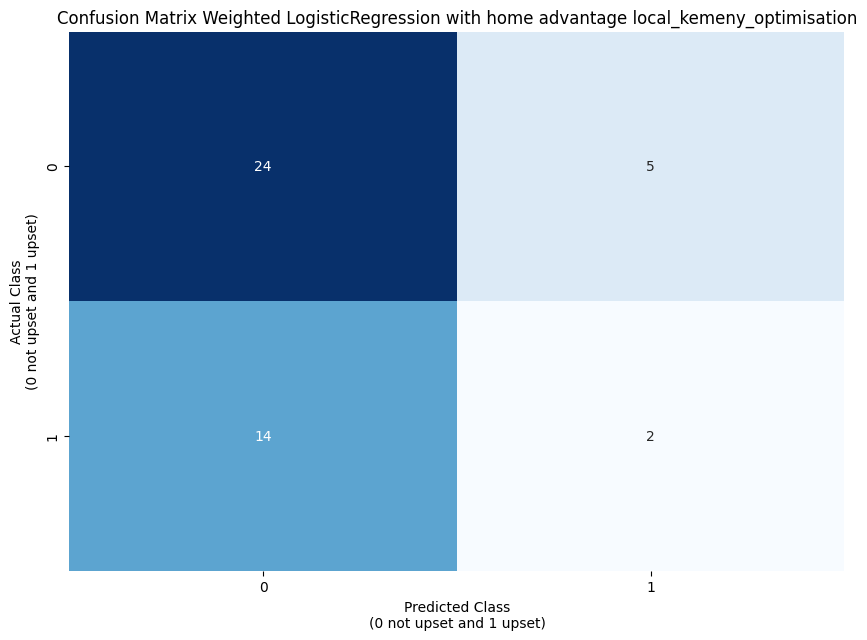

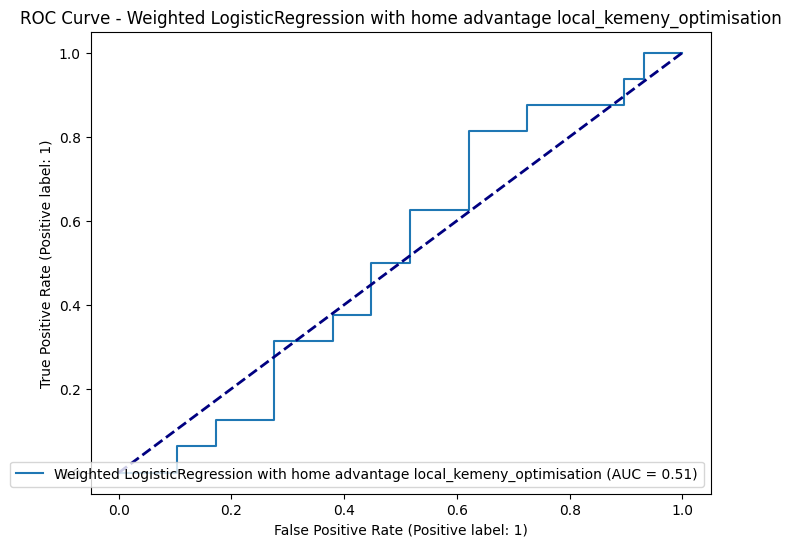

In [ ]:
# Weighted Logistc Regression with home advatange
model_name = "Weighted LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'yes'
random_state = 47
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

all_results_df, fold_results_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_wlrh = all_results_df
display(all_results_df_wlrh)

fold_results_df_wlrh = fold_results_df
display(fold_results_df_wlrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlrh.to_excel("all_wlrh_results.xlsx")
fold_results_df_wlrh.to_excel("fold_results_wlrh.xlsx")

MLP Classifier Neural Network no_ranking
Updated model parameters:
  activation: tanh
  alpha: 0.0001
  batch_size: auto
  beta_1: 0.9
  beta_2: 0.999
  early_stopping: False
  epsilon: 1e-08
  hidden_layer_sizes: (10, 10, 10)
  learning_rate: constant
  learning_rate_init: 0.01
  max_fun: 15000
  max_iter: 10000
  momentum: 0.9
  n_iter_no_change: 10
  nesterovs_momentum: True
  power_t: 0.5
  random_state: 47
  shuffle: True
  solver: adam
  tol: 0.0001
  validation_fraction: 0.1
  verbose: False
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_d

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2                    Unseen Standard Deviation   
2           3                         Unseen Accuracy Mean   
3           4           Unseen Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6        Unseen rain Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   MLP Classifier Neural Network local_kemeny_optimisation  
0                                               0.957       
1                                               0.000       
2                                               0.533       
3                                               0.000       
4                                               0.878       
5                                               0.000       
6                                               0.250       
7                                               0.000       
8                                               0.104       
9                                               4.865       
10                                              0.533       
11                                             20.000       
12                                              9.000       
13                                             12.000       
14                                              4.000       
15                                              0.625       
16                                              0.690       
17                                              0.656       
18                                              0.308       
19                                              0.250       
20                                              0.276       
21                                              0.466       
22                                              0.470       
23                                              0.466       
24                                              0.512       
25                                              0.533       
26                                              0.521       
27                                              0.392

Actual  Predicted  arena_stadium_capacity  home_lineup_strength  \
0        0          0                   53394                  0.69   
1        0          0                   41837                  0.67   
2        0          0                   62850                   NaN   
3        0          0                   62850                  0.88   
4        0          0                   32050                  0.88   
5        1          0                   42682                  0.82   
6        0          0                   39460                  0.82   
7        1          0                   11700                  0.82   
8        1          0                   52409                  0.72   
9        1          0                   21944                  0.81   
10       0          0                   18500                  0.77   
11       0          0                   26445                  0.85   
12       0          1                   34988                  0.89   
13       0          0                   26445                  0.87   
14       0          0                   10226                  0.79   
15       0          1                   30089                  0.73   
16       1          0                   30445                  0.81   
17       0          1                   20146                  0.71   
18       1          0                   32609                  0.83   
19       0          0                   25400                  0.82   
20       0          0                    <NA>                  0.79   
21       1          0                   29409                  0.61   
22       0          0                   25400                  0.76   
23       0          0                   15314                  0.83   
24       1          1                   17338                  0.83   
25       0          0                   23287                  0.76   
26       1          0                   25138                  0.82   
27       1          0                   39732                  0.76   
28       1          0                   29673                  0.78   
29       0          0                   27111                  0.69   
30       0          1                   12500                  0.72   
31       0          0                    9875                  0.82   
32       1          0                    5327                  0.79   
33       0          0                   15728                  0.85   
34       0          1                    5057                  0.76   
35       0          0                   10000                  0.69   
36       0          1                   18947                  0.78   
37       0          1                    5140                  0.75   
38       1          0                    7691                  0.76   
39       1          1                    9546                  0.75   
40       0          0                   11582                   NaN   
41       0          1                    7691                  0.62   
42       1          1                    4502                  0.70   
43       0          1                    9527                  0.72   
44       1          1                    6238                   NaN   

    home_team_league_form  home_team_league_form_home_and_away  \
0                    0.83                                 0.44   
1                    0.39                                 0.39   
2                    0.00                                 0.39   
3                    0.56                                 0.39   
4                    0.00                                 0.72   
5                    0.39                                 0.56   
6                    0.00                                 0.11   
7                    0.00                                 0.17   
8                    0.00                                 0.28   
9                    0.22                                 0.17   
10         

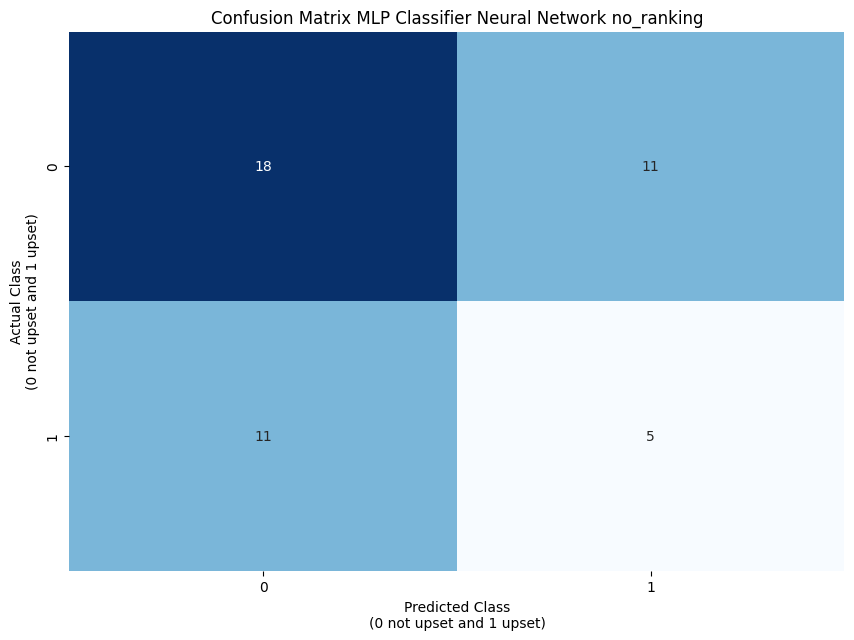

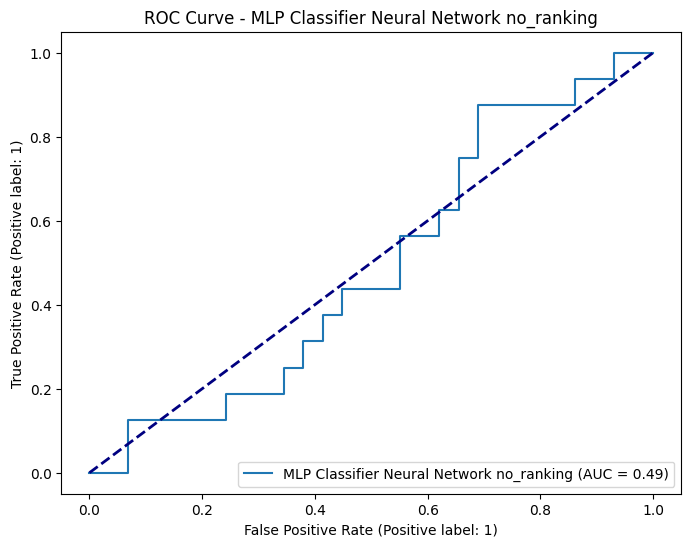

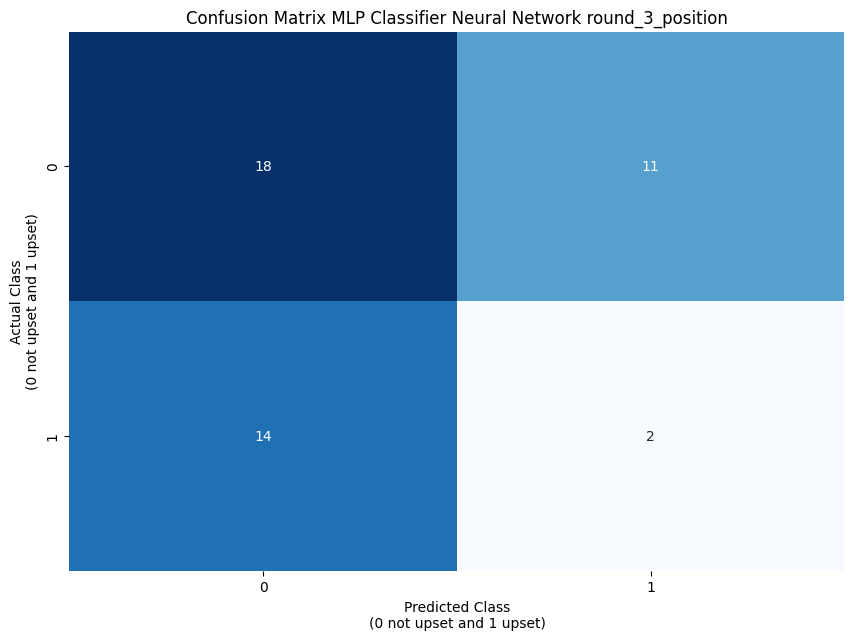

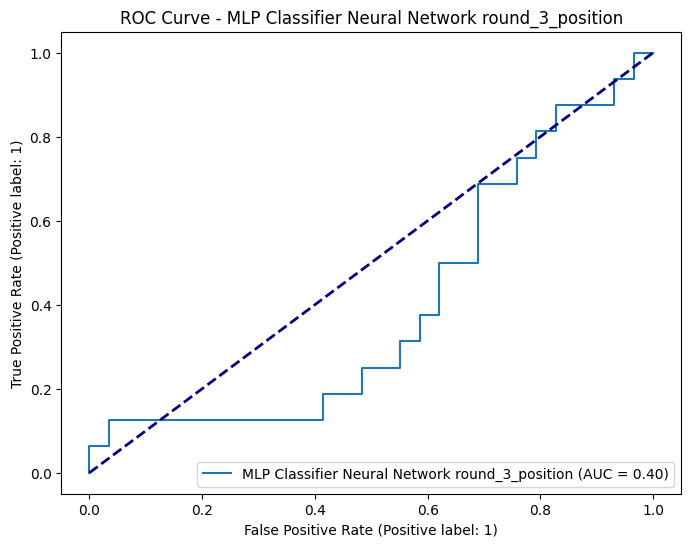

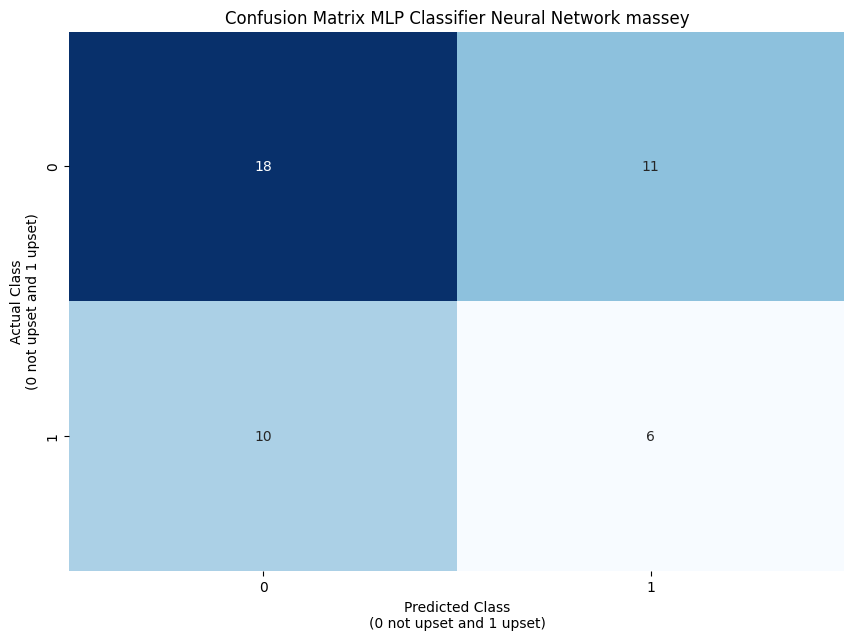

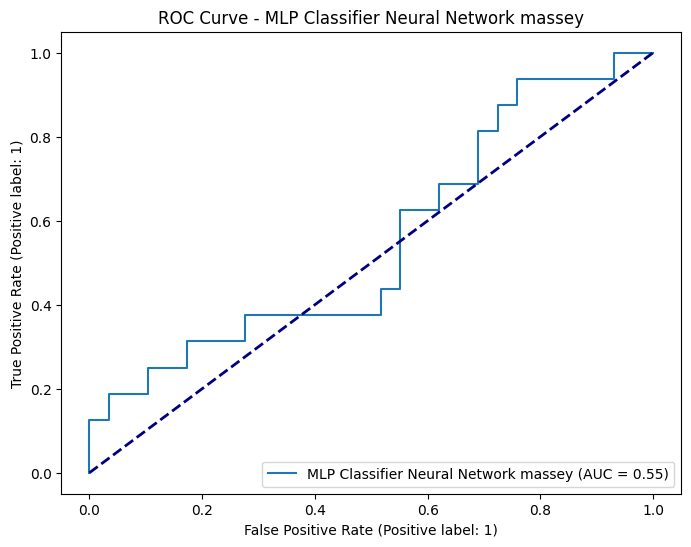

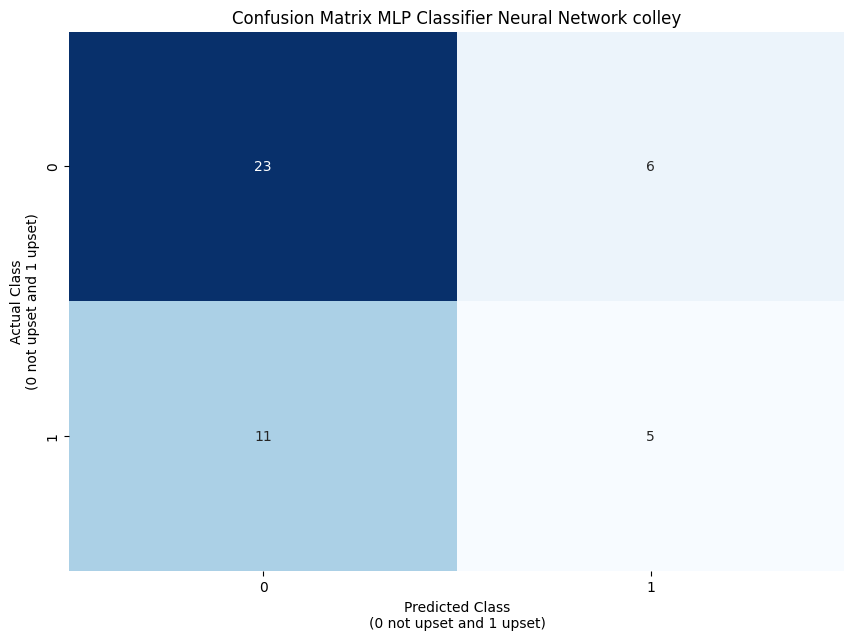

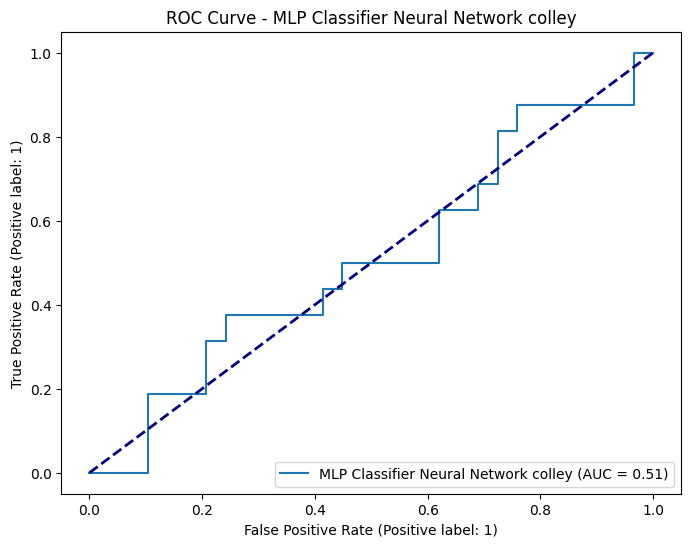

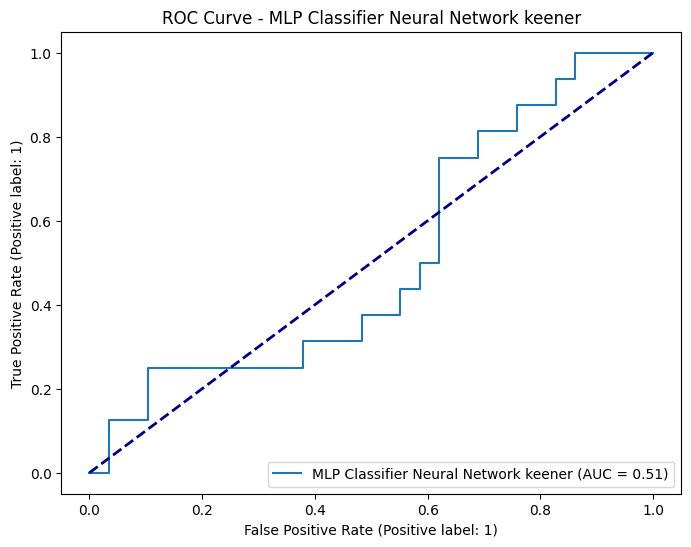

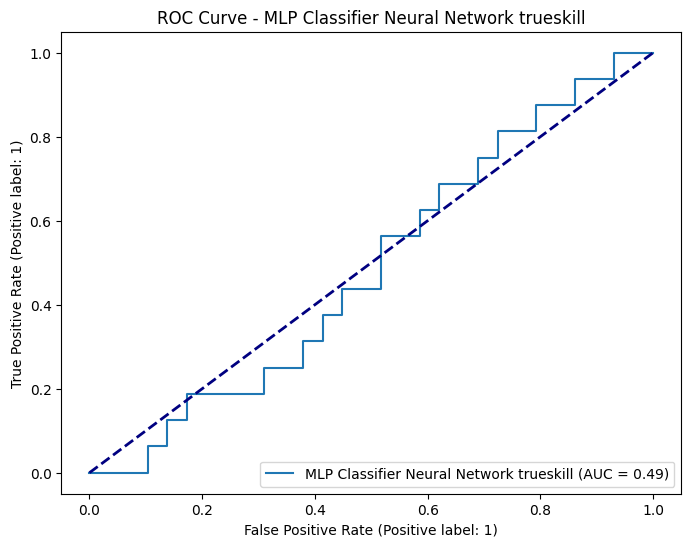

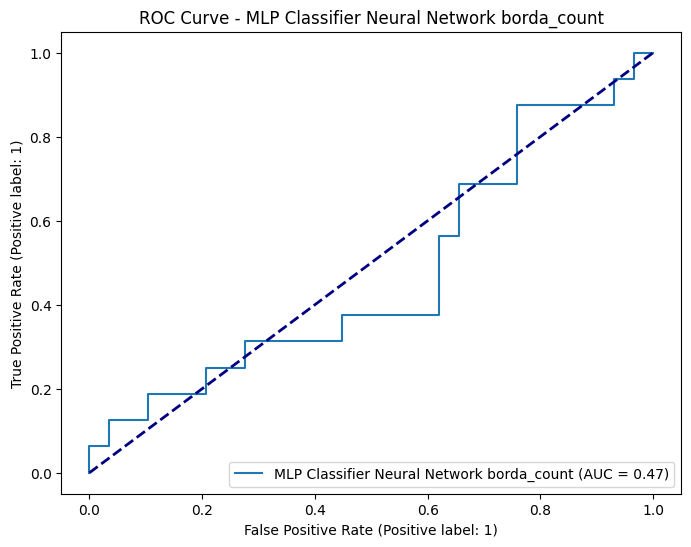

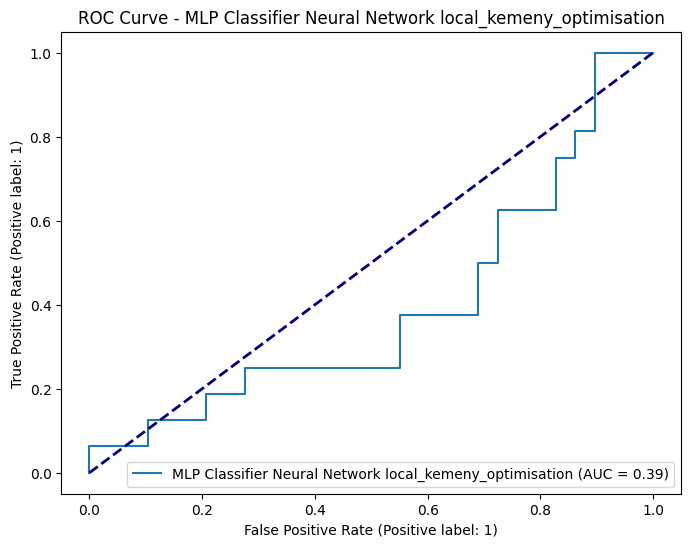

In [ ]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = MLPClassifier(max_iter = 10000)

all_results_df, fold_results_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_nn = all_results_df
display(all_results_df_nn)

fold_results_df_nn = fold_results_df
display(fold_results_df_nn)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nn.to_excel("all_nn_results.xlsx")
fold_results_df_nn.to_excel("fold_results_nn.xlsx")

MLP Classifier Neural Network with home advantage no_ranking
Updated model parameters:
  activation: relu
  alpha: 0.0001
  batch_size: auto
  beta_1: 0.9
  beta_2: 0.999
  early_stopping: False
  epsilon: 1e-08
  hidden_layer_sizes: (20, 20)
  learning_rate: constant
  learning_rate_init: 0.01
  max_fun: 15000
  max_iter: 10000
  momentum: 0.9
  n_iter_no_change: 10
  nesterovs_momentum: True
  power_t: 0.5
  random_state: 47
  shuffle: True
  solver: adam
  tol: 0.0001
  validation_fraction: 0.1
  verbose: False
  warm_start: False
numeric features ['home_win_factor', 'arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_d

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2                    Unseen Standard Deviation   
2           3                         Unseen Accuracy Mean   
3           4           Unseen Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6        Unseen rain Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   MLP Classifier Neural Network with home advantage local_kemeny_optimisation  
0                                               0.915                           
1                                               0.000                           
2                                               0.622                           
3                                               0.000                           
4                                               0.756                           
5                                               0.000                           
6                                               0.188                           
7                                               0.000                           
8                                               0.267                           
9                                               3.550                           
10                                              0.622                           
11                                             25.000                           
12                                              4.000                           
13                                             13.000                           
14                                              3.000                           
15                                              0.658                           
16                                              0.862                           
17                                              0.746                           
18                                              0.429                           
19                                              0.188                           
20                                              0.261                           
21                                              0.543                           
22                                              0.525                           
23                                              0.504                           
24                                              0.576                           
25                                              0.622                           
26                

Actual  Predicted  arena_stadium_capacity  home_lineup_strength  \
0        0          0                   53394                  0.69   
1        0          0                   41837                  0.67   
2        0          0                   62850                   NaN   
3        0          0                   62850                  0.88   
4        0          0                   32050                  0.88   
5        1          0                   42682                  0.82   
6        0          0                   39460                  0.82   
7        1          0                   11700                  0.82   
8        1          1                   52409                  0.72   
9        1          0                   21944                  0.81   
10       0          0                   18500                  0.77   
11       0          0                   26445                  0.85   
12       0          0                   34988                  0.89   
13       0          0                   26445                  0.87   
14       0          0                   10226                  0.79   
15       0          1                   30089                  0.73   
16       1          0                   30445                  0.81   
17       0          0                   20146                  0.71   
18       1          0                   32609                  0.83   
19       0          1                   25400                  0.82   
20       0          0                    <NA>                  0.79   
21       1          0                   29409                  0.61   
22       0          0                   25400                  0.76   
23       0          0                   15314                  0.83   
24       1          0                   17338                  0.83   
25       0          0                   23287                  0.76   
26       1          0                   25138                  0.82   
27       1          0                   39732                  0.76   
28       1          0                   29673                  0.78   
29       0          0                   27111                  0.69   
30       0          0                   12500                  0.72   
31       0          0                    9875                  0.82   
32       1          1                    5327                  0.79   
33       0          0                   15728                  0.85   
34       0          0                    5057                  0.76   
35       0          0                   10000                  0.69   
36       0          1                   18947                  0.78   
37       0          1                    5140                  0.75   
38       1          0                    7691                  0.76   
39       1          0                    9546                  0.75   
40       0          0                   11582                   NaN   
41       0          0                    7691                  0.62   
42       1          0                    4502                  0.70   
43       0          0                    9527                  0.72   
44       1          1                    6238                   NaN   

    home_team_league_form  home_team_league_form_home_and_away  \
0                    0.83                                 0.44   
1                    0.39                                 0.39   
2                    0.00                                 0.39   
3                    0.56                                 0.39   
4                    0.00                                 0.72   
5                    0.39                                 0.56   
6                    0.00                                 0.11   
7                    0.00                                 0.17   
8                    0.00                                 0.28   
9                    0.22                                 0.17   
10         

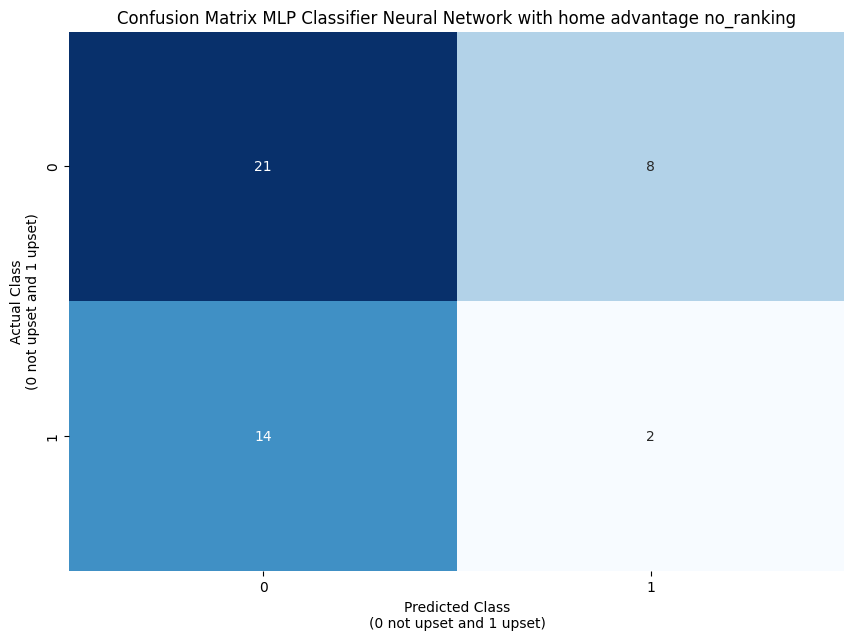

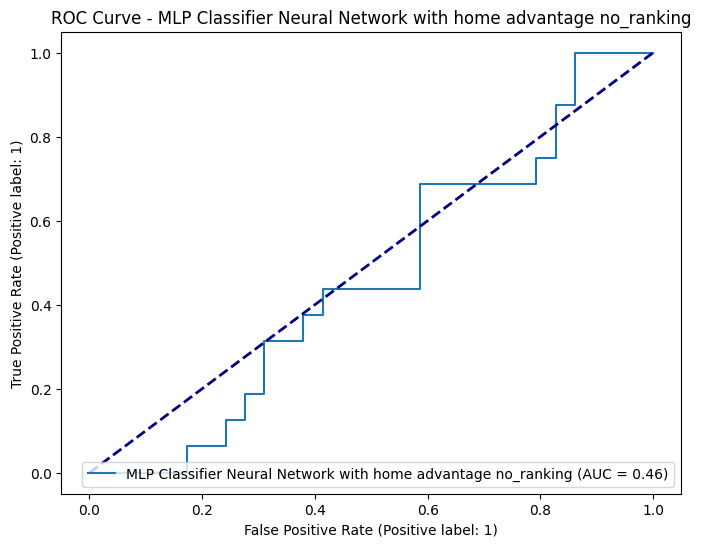

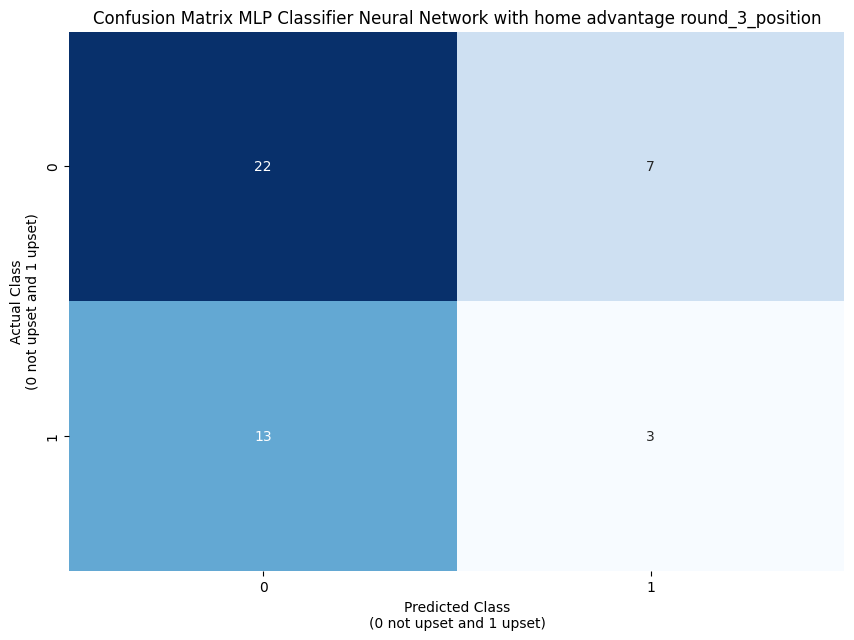

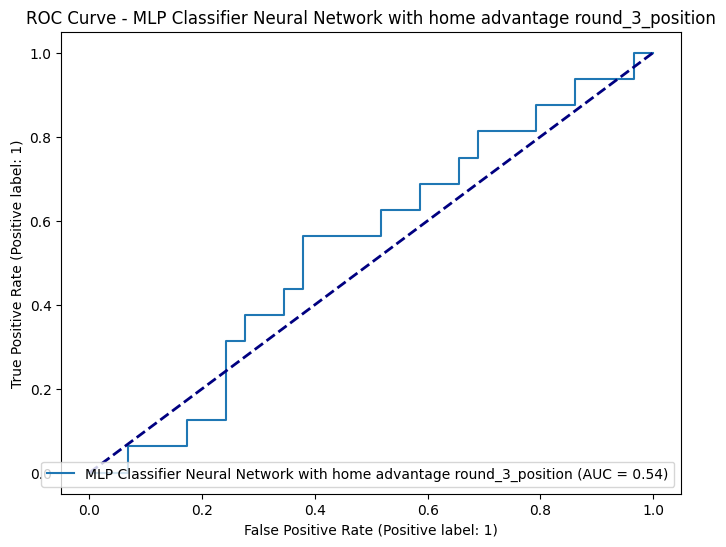

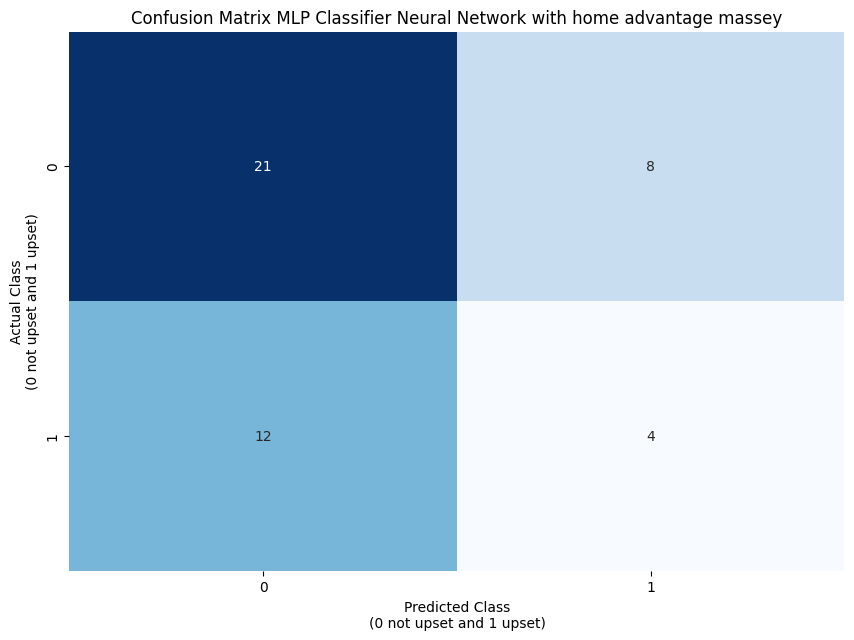

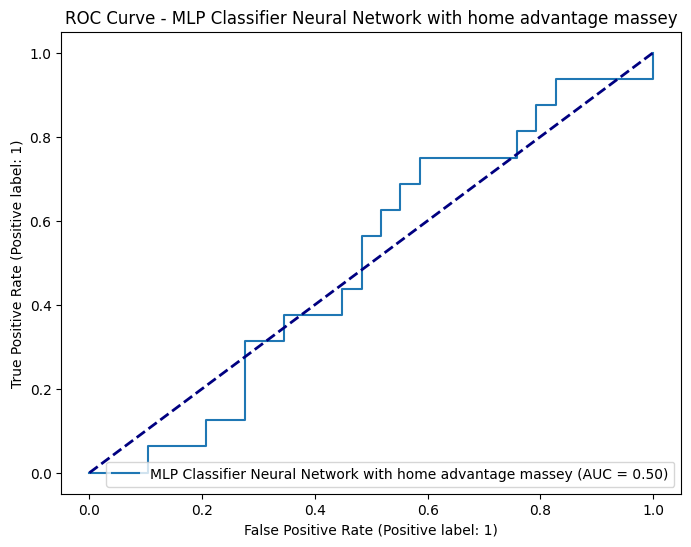

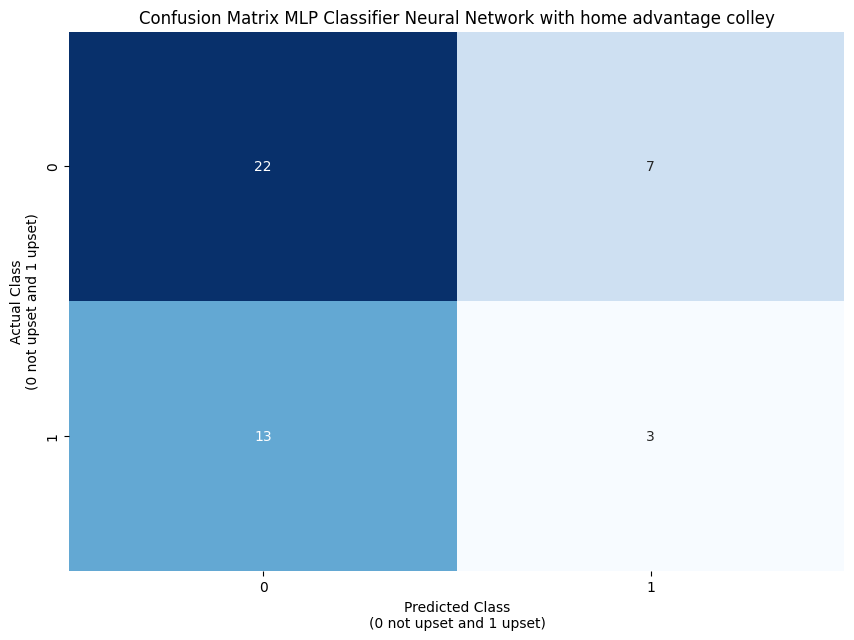

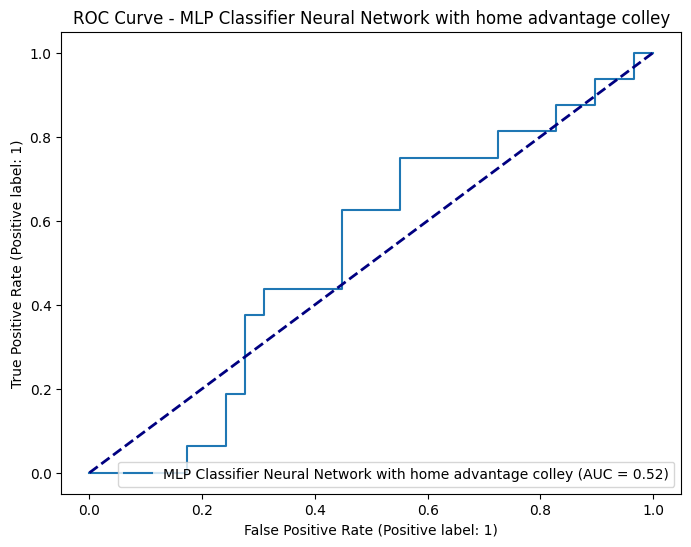

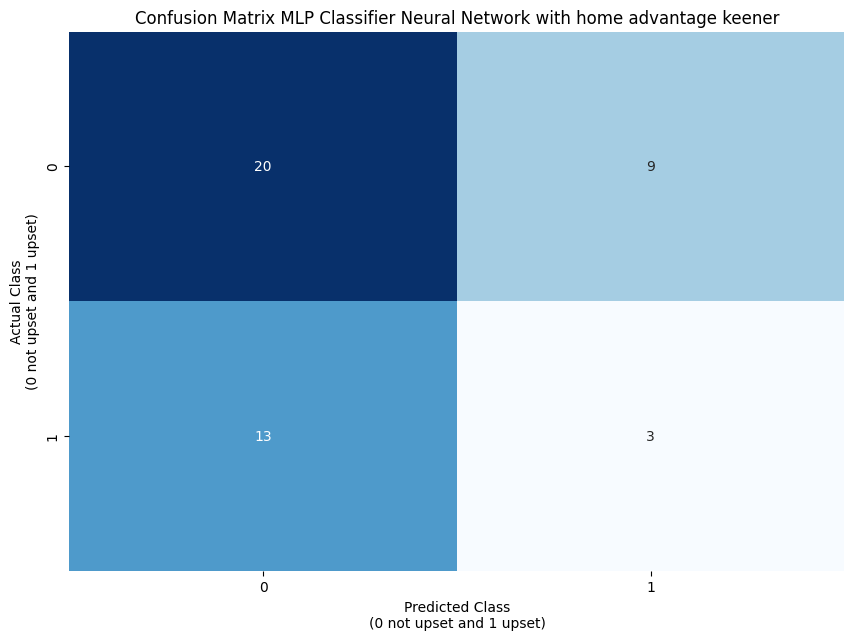

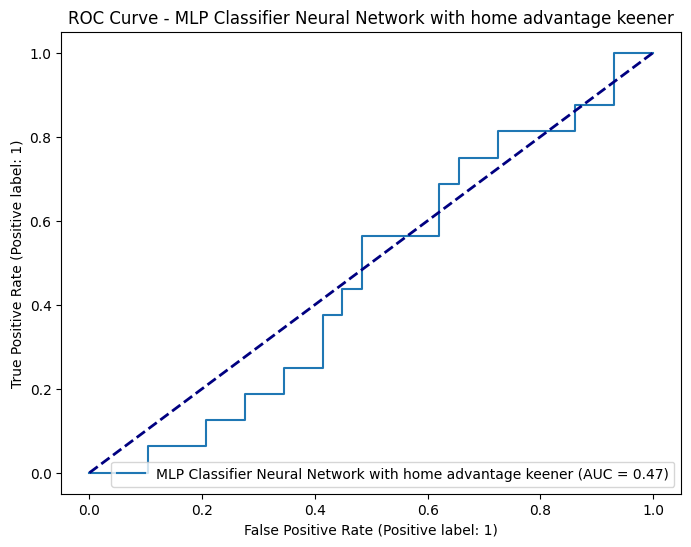

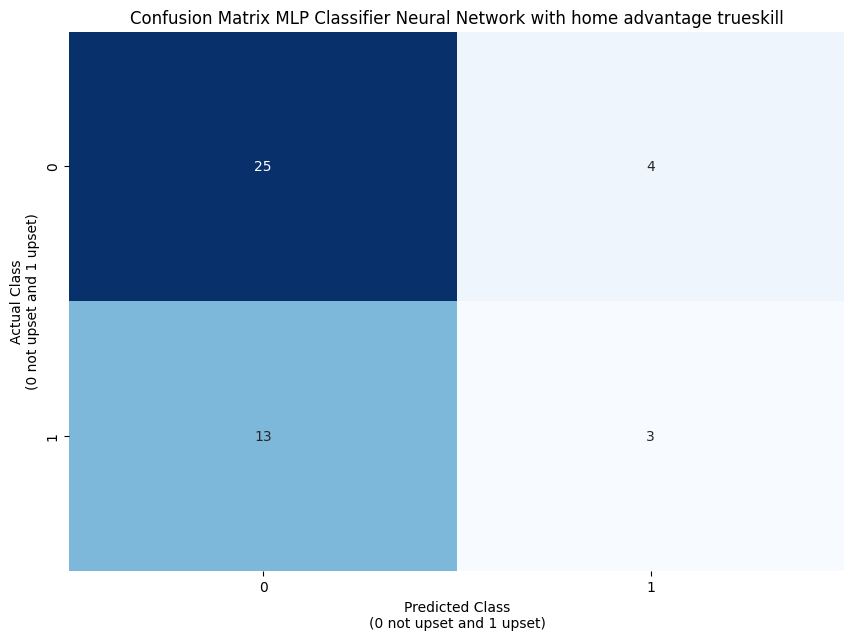

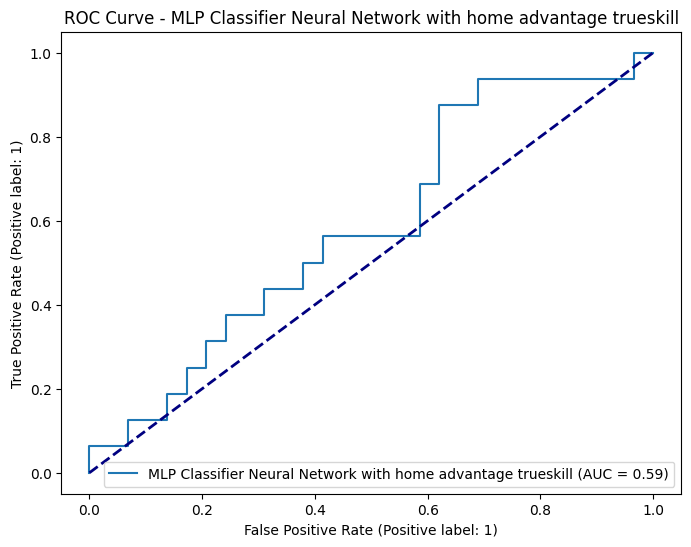

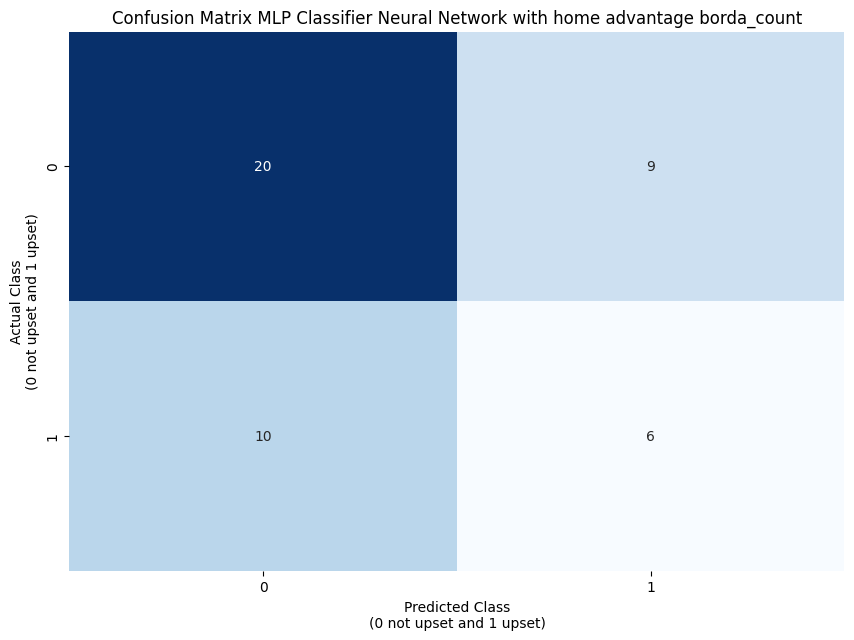

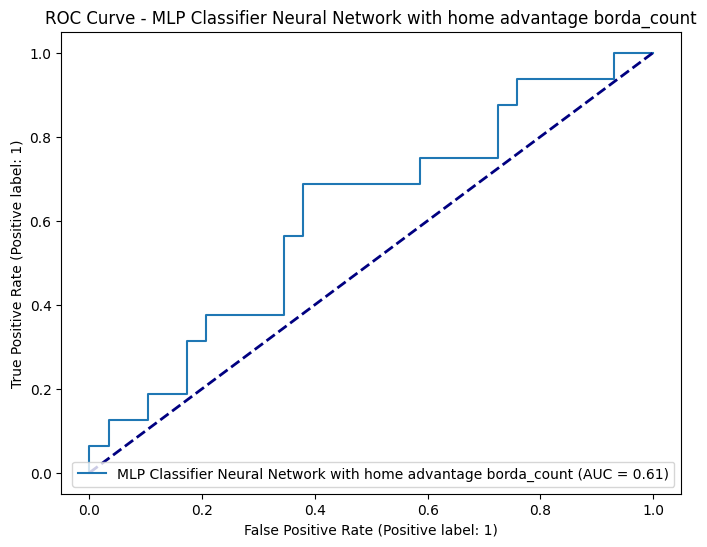

In [ ]:
# MCP Neural Network with home advantage
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = MLPClassifier(max_iter = 10000)

all_results_df, fold_results_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_nnh = all_results_df
display(all_results_df_nnh)

fold_results_df_nnh = fold_results_df
display(fold_results_df_nnh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nnh.to_excel("all_nnh_results.xlsx")
fold_results_df_nnh.to_excel("fold_results_nnh.xlsx")

Random Forest Classifier no_ranking
Updated model parameters:
  bootstrap: True
  ccp_alpha: 0.0
  class_weight: None
  criterion: gini
  max_depth: None
  max_features: None
  max_leaf_nodes: None
  max_samples: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 1
  min_samples_split: 2
  min_weight_fraction_leaf: 0.0
  n_estimators: 200
  n_jobs: None
  oob_score: False
  random_state: 47
  verbose: 0
  warm_start: False
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 'match_weather_data_hours_windspeed', '

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2                    Unseen Standard Deviation   
2           3                         Unseen Accuracy Mean   
3           4           Unseen Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6        Unseen rain Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Random Forest Classifier local_kemeny_optimisation  
0                                               1.000  
1                                               0.000  
2                                               0.644  
3                                               0.000  
4                                               1.000  
5                                               0.000  
6                                               0.312  
7                                               0.000  
8                                               0.147  
9                                               0.647  
10                                              0.644  
11                                             24.000  
12                                              5.000  
13                                             11.000  
14                                              5.000  
15                                              0.686  
16                                              0.828  
17                                              0.750  
18                                              0.500  
19                                              0.312  
20                                              0.385  
21                                              0.593  
22                                              0.570  
23                                              0.567  
24                                              0.620  
25                                              0.644  
26                                              0.620  
27                                              0.562

Actual  Predicted  arena_stadium_capacity  home_lineup_strength  \
0        0          0                   53394                  0.69   
1        0          0                   41837                  0.67   
2        0          0                   62850                   NaN   
3        0          0                   62850                  0.88   
4        0          0                   32050                  0.88   
5        1          0                   42682                  0.82   
6        0          0                   39460                  0.82   
7        1          0                   11700                  0.82   
8        1          0                   52409                  0.72   
9        1          0                   21944                  0.81   
10       0          0                   18500                  0.77   
11       0          0                   26445                  0.85   
12       0          0                   34988                  0.89   
13       0          0                   26445                  0.87   
14       0          0                   10226                  0.79   
15       0          1                   30089                  0.73   
16       1          0                   30445                  0.81   
17       0          0                   20146                  0.71   
18       1          0                   32609                  0.83   
19       0          0                   25400                  0.82   
20       0          0                    <NA>                  0.79   
21       1          0                   29409                  0.61   
22       0          1                   25400                  0.76   
23       0          0                   15314                  0.83   
24       1          0                   17338                  0.83   
25       0          0                   23287                  0.76   
26       1          1                   25138                  0.82   
27       1          0                   39732                  0.76   
28       1          0                   29673                  0.78   
29       0          0                   27111                  0.69   
30       0          0                   12500                  0.72   
31       0          0                    9875                  0.82   
32       1          1                    5327                  0.79   
33       0          0                   15728                  0.85   
34       0          0                    5057                  0.76   
35       0          1                   10000                  0.69   
36       0          0                   18947                  0.78   
37       0          1                    5140                  0.75   
38       1          0                    7691                  0.76   
39       1          1                    9546                  0.75   
40       0          0                   11582                   NaN   
41       0          1                    7691                  0.62   
42       1          1                    4502                  0.70   
43       0          0                    9527                  0.72   
44       1          1                    6238                   NaN   

    home_team_league_form  home_team_league_form_home_and_away  \
0                    0.83                                 0.44   
1                    0.39                                 0.39   
2                    0.00                                 0.39   
3                    0.56                                 0.39   
4                    0.00                                 0.72   
5                    0.39                                 0.56   
6                    0.00                                 0.11   
7                    0.00                                 0.17   
8                    0.00                                 0.28   
9                    0.22                                 0.17   
10         

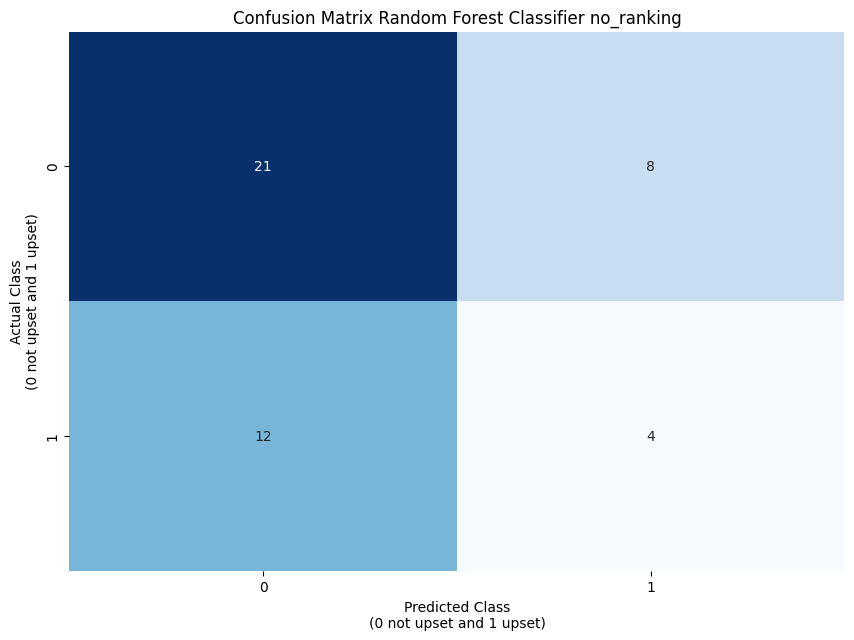

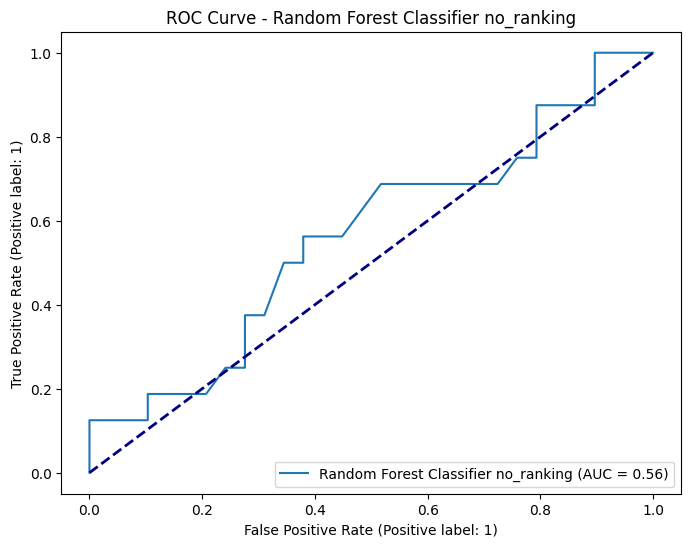

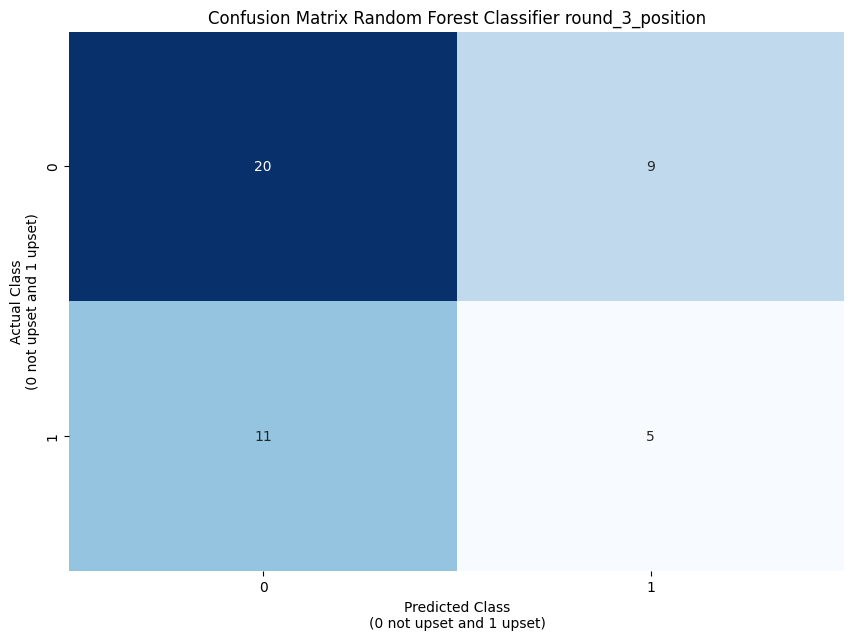

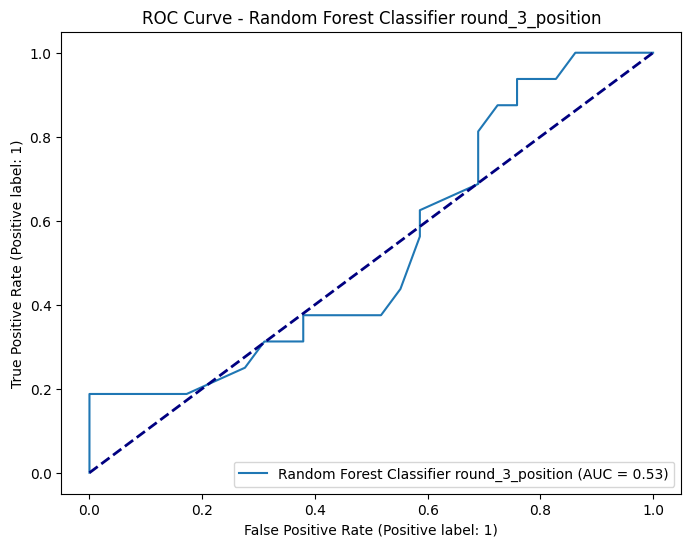

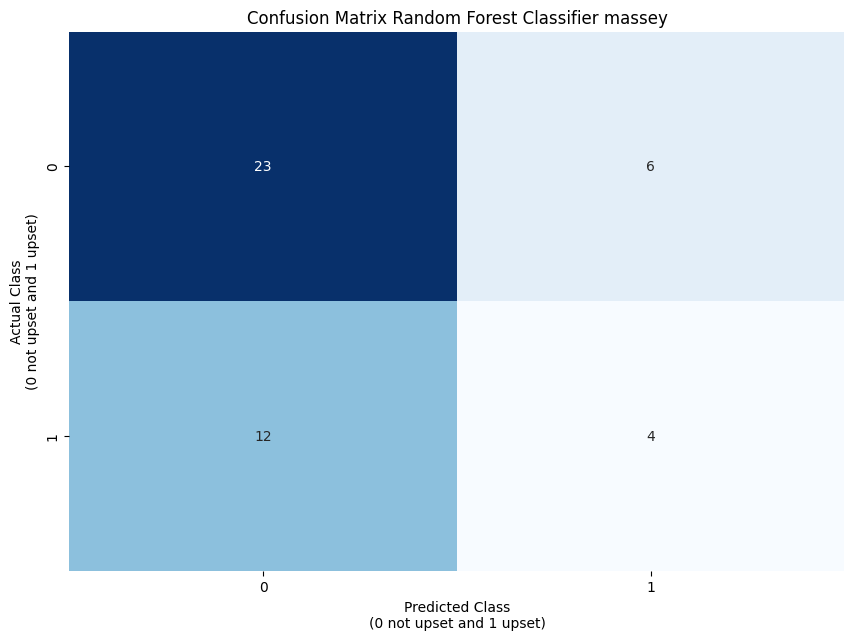

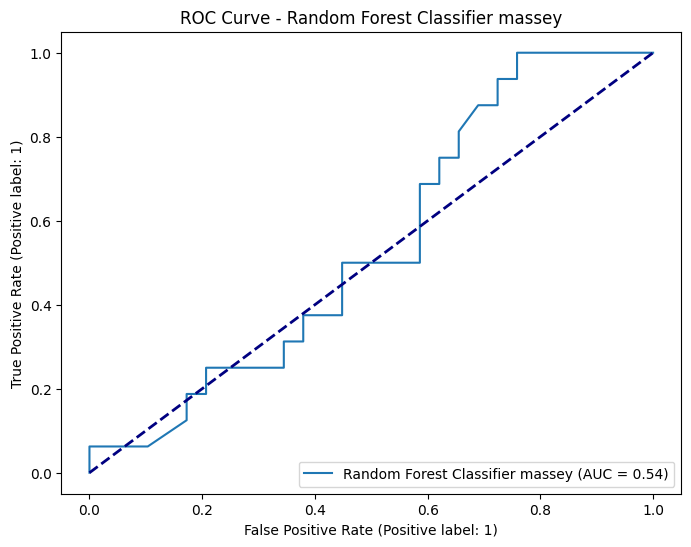

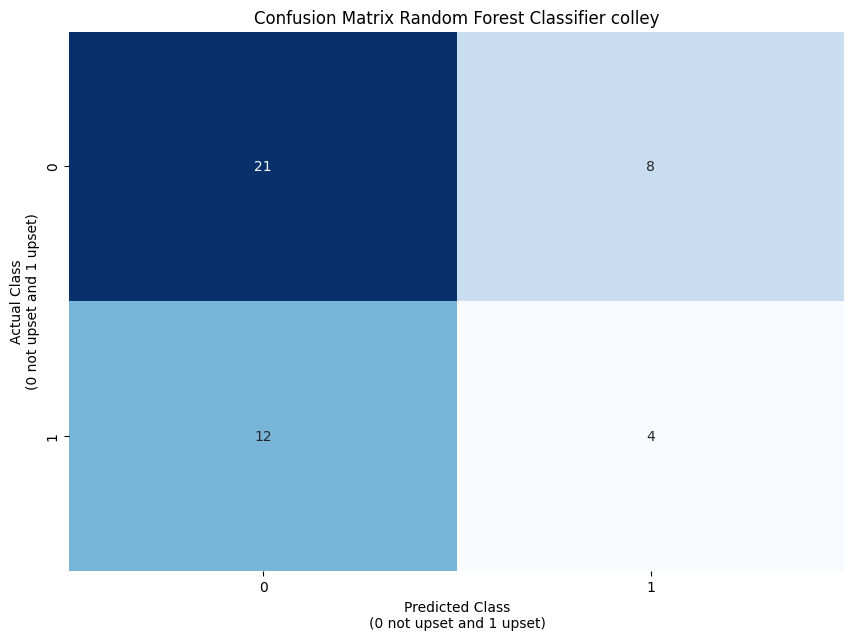

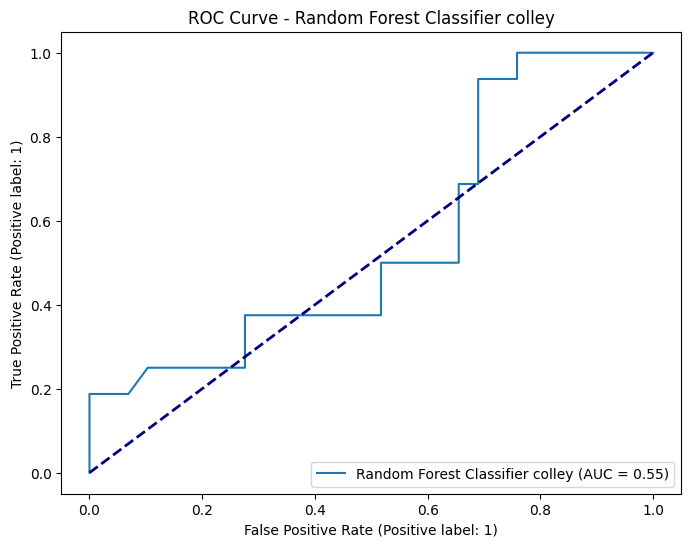

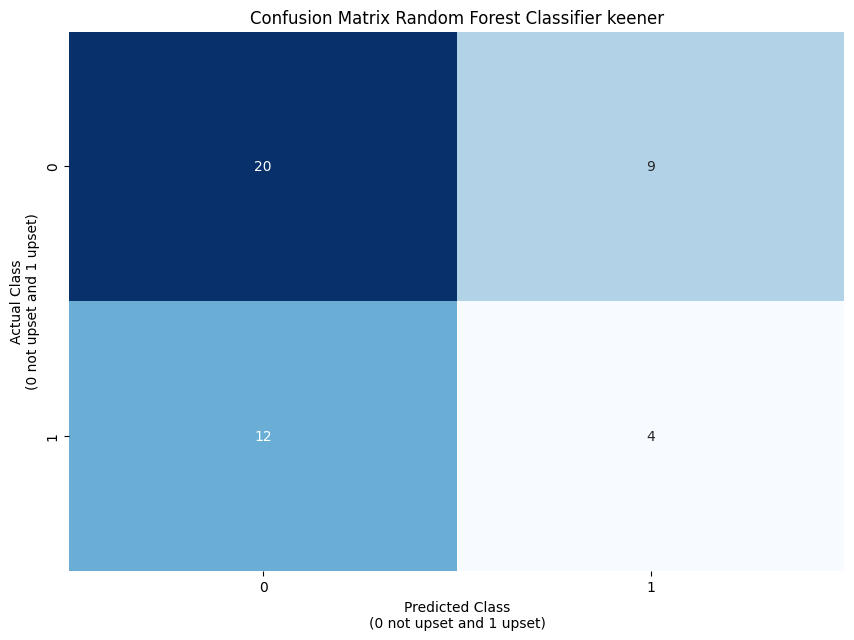

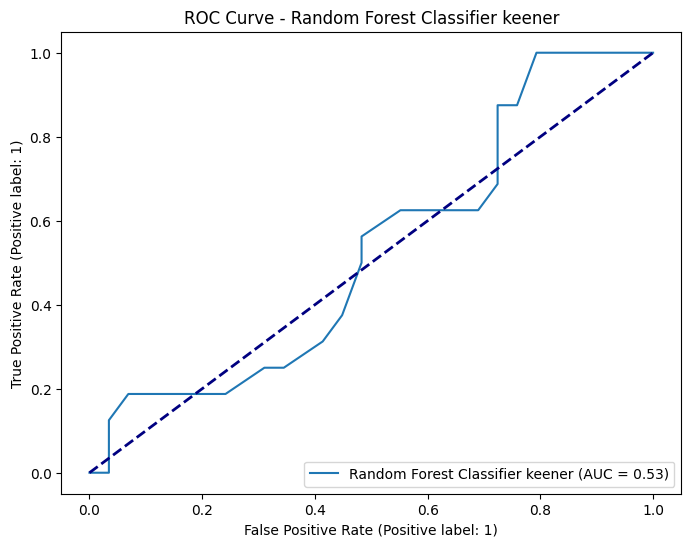

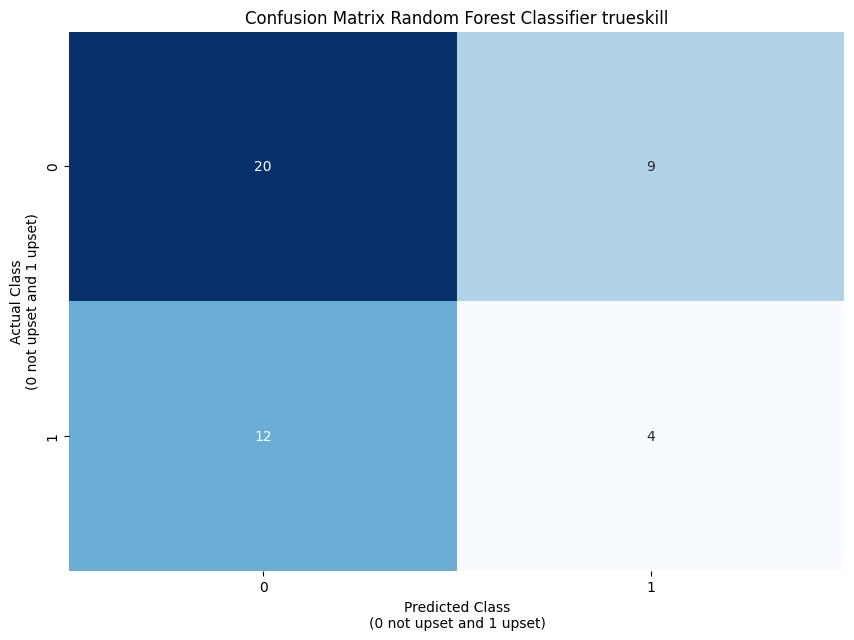

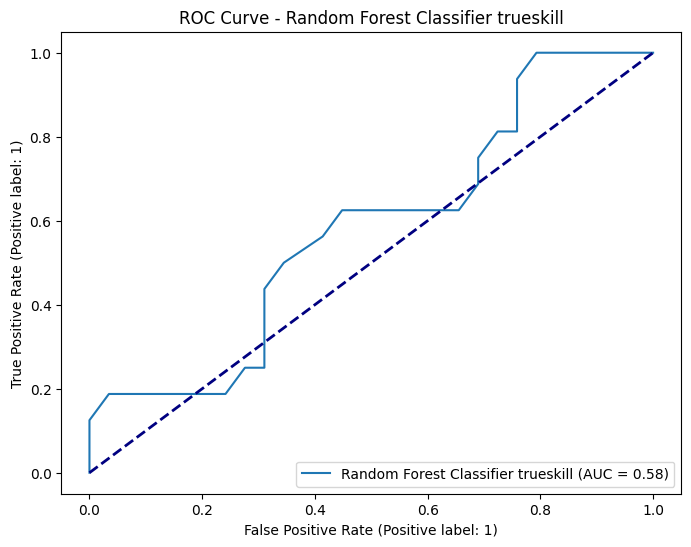

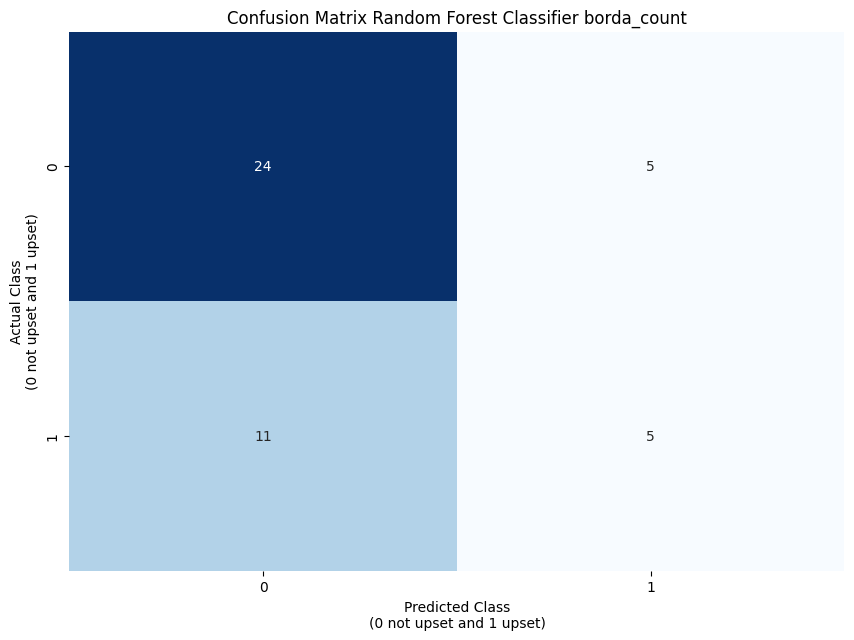

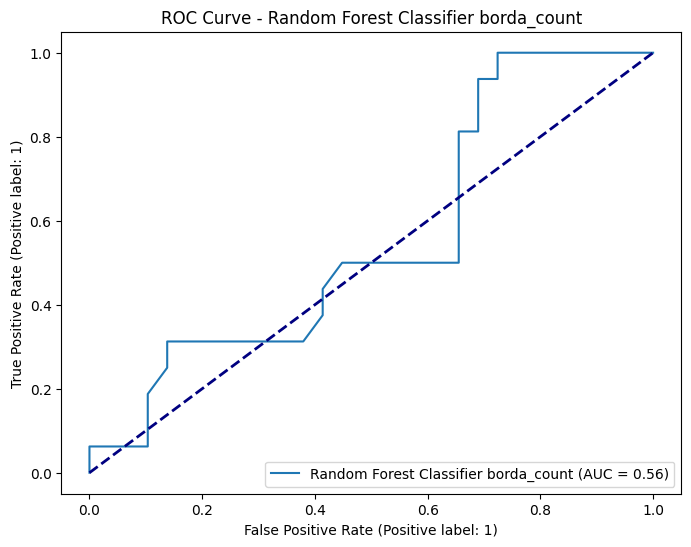

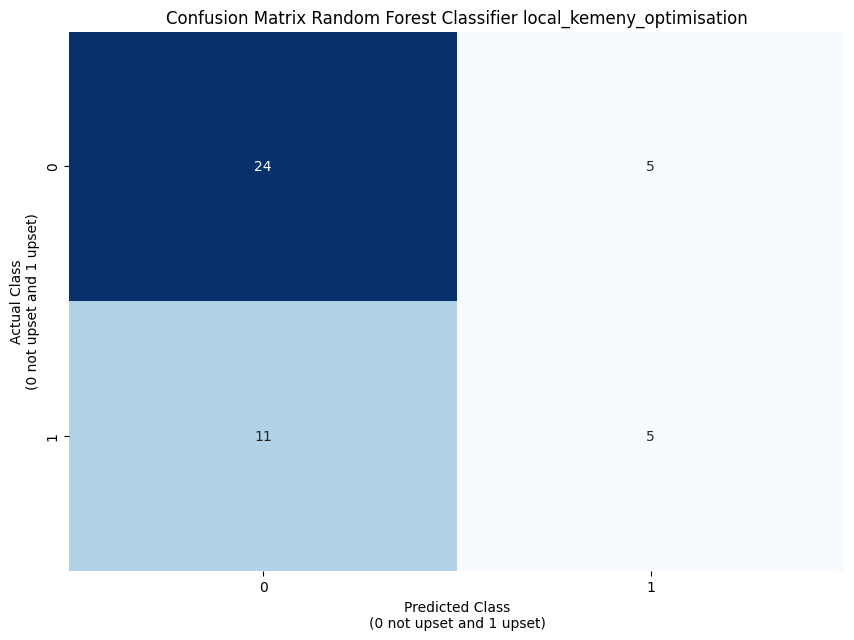

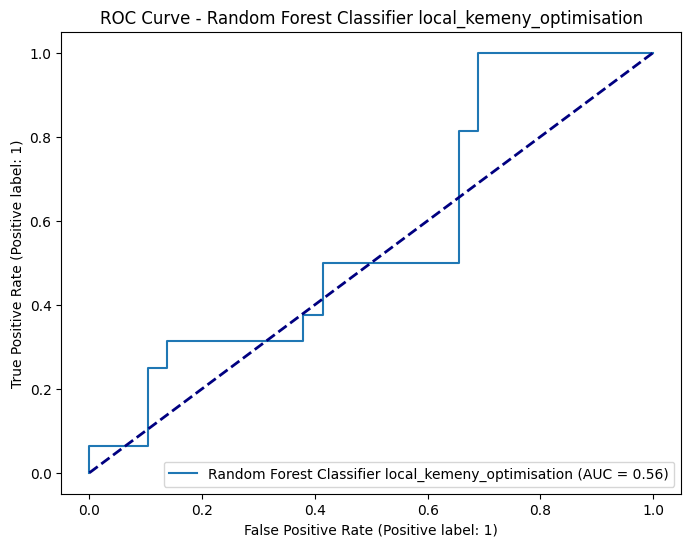

In [ ]:
# Random Forest Classifier
model_name = "Random Forest Classifier"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

all_results_df, fold_results_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)


all_results_df_rf = all_results_df
display(all_results_df_rf)

fold_results_df_rf = fold_results_df
display(fold_results_df_rf)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rf.to_excel("all_rf_results.xlsx")
fold_results_df_rf.to_excel("fold_results_rf.xlsx")


Random Forest Classifier with home advantage no_ranking
Updated model parameters:
  bootstrap: True
  ccp_alpha: 0.0
  class_weight: None
  criterion: gini
  max_depth: None
  max_features: sqrt
  max_leaf_nodes: None
  max_samples: None
  min_impurity_decrease: 0.0
  min_samples_leaf: 1
  min_samples_split: 2
  min_weight_fraction_leaf: 0.0
  n_estimators: 200
  n_jobs: None
  oob_score: False
  random_state: 47
  verbose: 0
  warm_start: False
numeric features ['home_win_factor', 'arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_league_form_home_and_away', 'home_team_league_promotion_relegation', 'away_lineup_strength', 'away_team_league_form', 'away_team_league_form_home_and_away', 'away_team_league_promotion_relegation', 'rivalry_flag', 'match_weather_data_hours_feelslike', 'match_weather_data_hours_humidity', 'match_weather_data_hours_dew', 'match_weather_data_hours_precip', 'match_weather_data_hours_snow', 'match_weather_data_hours_snowdepth', 

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2                    Unseen Standard Deviation   
2           3                         Unseen Accuracy Mean   
3           4           Unseen Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6        Unseen rain Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   Random Forest Classifier with home advantage local_kemeny_optimisation  
0                                               1.000                      
1                                               0.000                      
2                                               0.600                      
3                                               0.000                      
4                                               1.000                      
5                                               0.000                      
6                                               0.250                      
7                                               0.000                      
8                                               0.140                      
9                                               0.663                      
10                                              0.600                      
11                                             23.000                      
12                                              6.000                      
13                                             12.000                      
14                                              4.000                      
15                                              0.657                      
16                                              0.793                      
17                                              0.719                      
18                                              0.400                      
19                                              0.250                      
20                                              0.308                      
21                                              0.529                      
22                                              0.522                      
23                                              0.513                      
24                                              0.566                      
25                                              0.600                      
26                                              0.573                      
27                                              0.582

Actual  Predicted  arena_stadium_capacity  home_lineup_strength  \
0        0          0                   53394                  0.69   
1        0          0                   41837                  0.67   
2        0          0                   62850                   NaN   
3        0          0                   62850                  0.88   
4        0          0                   32050                  0.88   
5        1          0                   42682                  0.82   
6        0          1                   39460                  0.82   
7        1          1                   11700                  0.82   
8        1          0                   52409                  0.72   
9        1          0                   21944                  0.81   
10       0          1                   18500                  0.77   
11       0          0                   26445                  0.85   
12       0          0                   34988                  0.89   
13       0          1                   26445                  0.87   
14       0          0                   10226                  0.79   
15       0          0                   30089                  0.73   
16       1          0                   30445                  0.81   
17       0          0                   20146                  0.71   
18       1          0                   32609                  0.83   
19       0          0                   25400                  0.82   
20       0          0                    <NA>                  0.79   
21       1          0                   29409                  0.61   
22       0          0                   25400                  0.76   
23       0          0                   15314                  0.83   
24       1          0                   17338                  0.83   
25       0          0                   23287                  0.76   
26       1          1                   25138                  0.82   
27       1          0                   39732                  0.76   
28       1          0                   29673                  0.78   
29       0          0                   27111                  0.69   
30       0          0                   12500                  0.72   
31       0          0                    9875                  0.82   
32       1          1                    5327                  0.79   
33       0          0                   15728                  0.85   
34       0          0                    5057                  0.76   
35       0          1                   10000                  0.69   
36       0          0                   18947                  0.78   
37       0          1                    5140                  0.75   
38       1          0                    7691                  0.76   
39       1          0                    9546                  0.75   
40       0          0                   11582                   NaN   
41       0          1                    7691                  0.62   
42       1          0                    4502                  0.70   
43       0          0                    9527                  0.72   
44       1          1                    6238                   NaN   

    home_team_league_form  home_team_league_form_home_and_away  \
0                    0.83                                 0.44   
1                    0.39                                 0.39   
2                    0.00                                 0.39   
3                    0.56                                 0.39   
4                    0.00                                 0.72   
5                    0.39                                 0.56   
6                    0.00                                 0.11   
7                    0.00                                 0.17   
8                    0.00                                 0.28   
9                    0.22                                 0.17   
10         

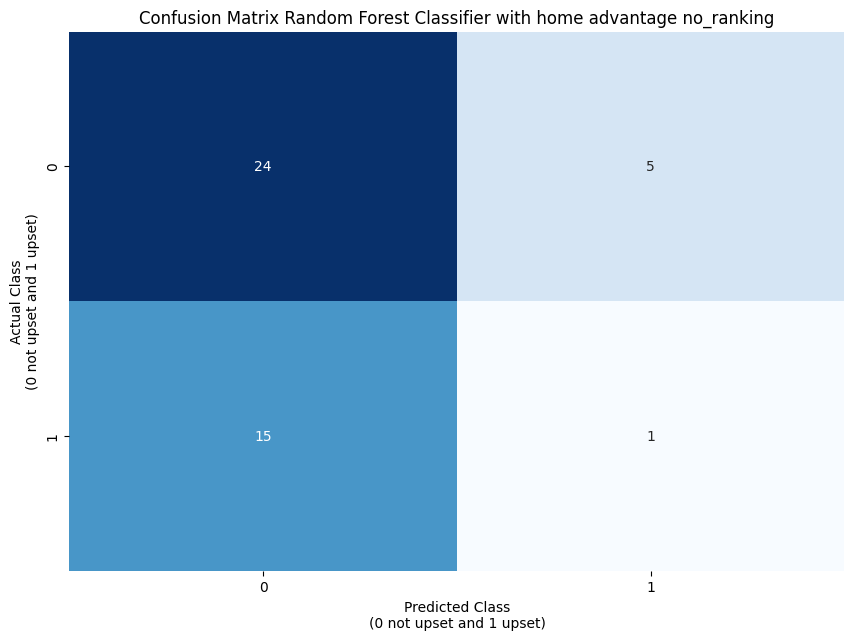

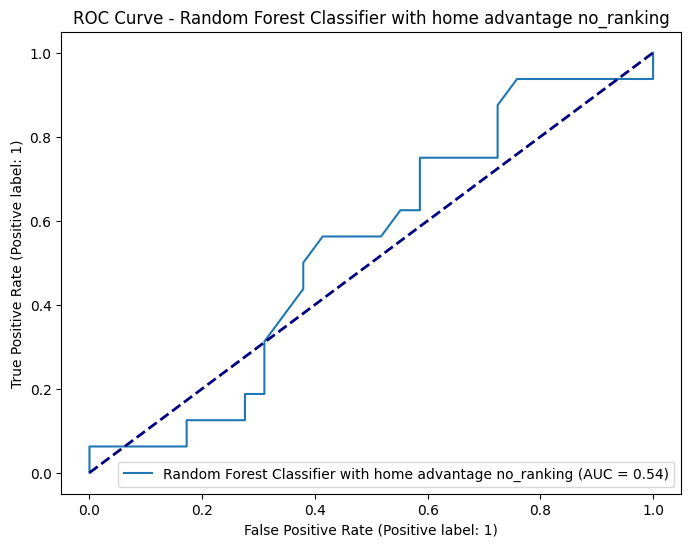

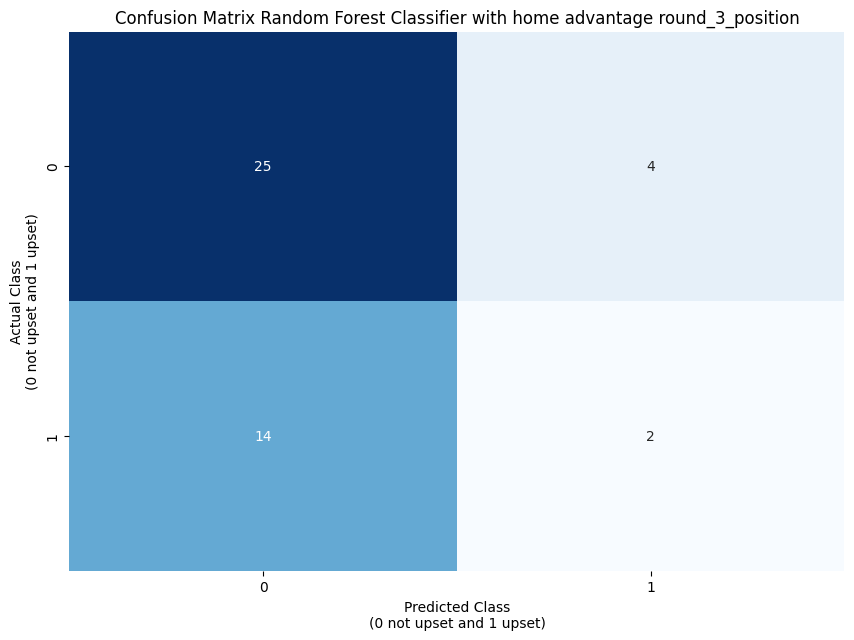

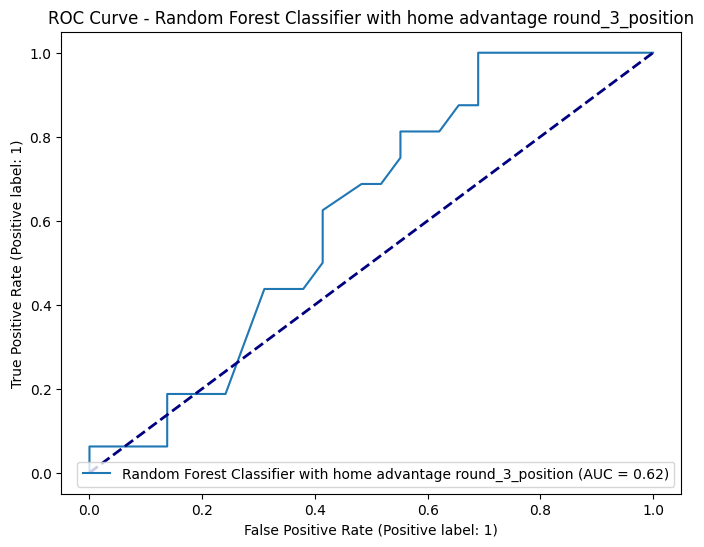

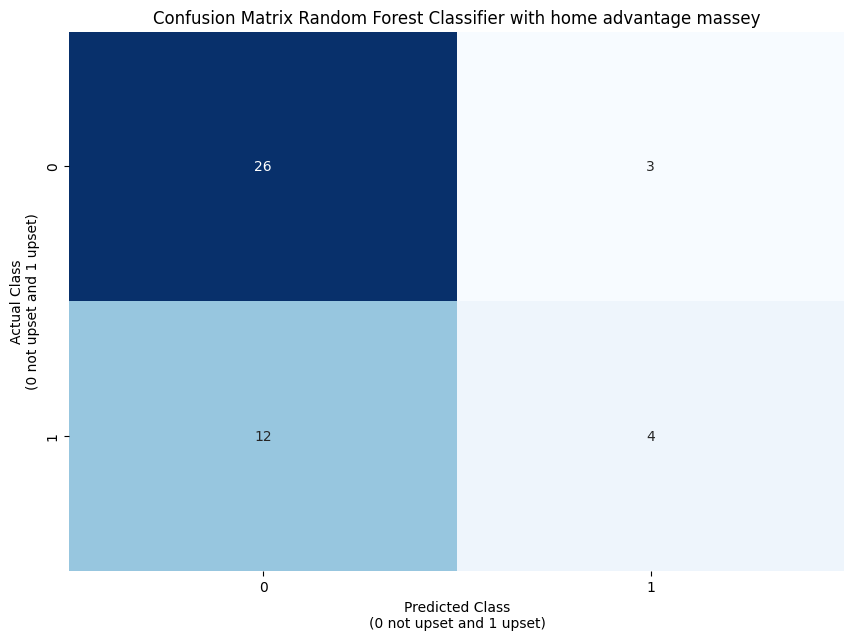

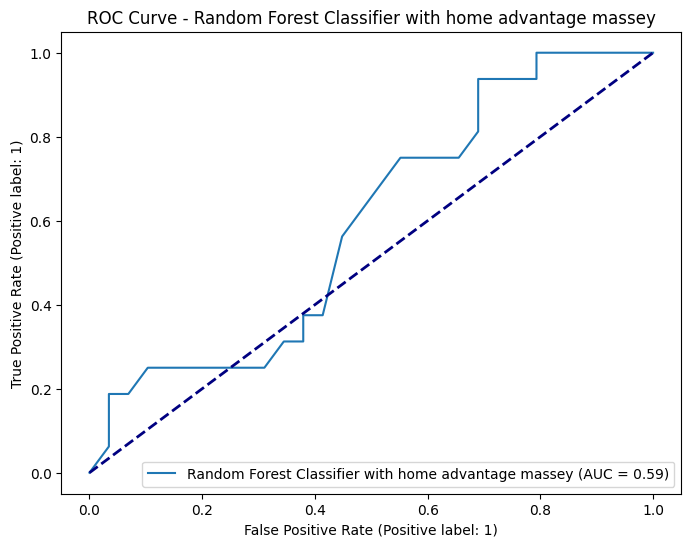

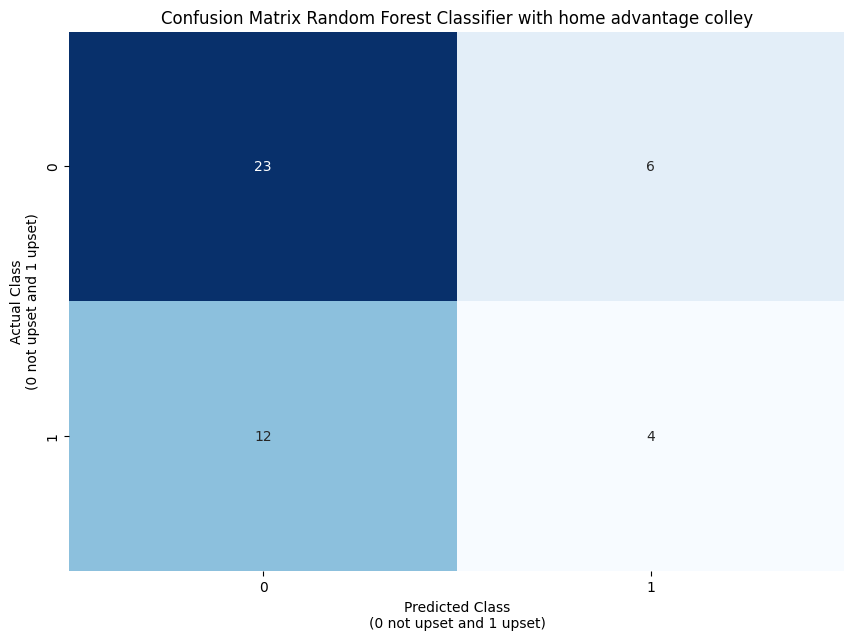

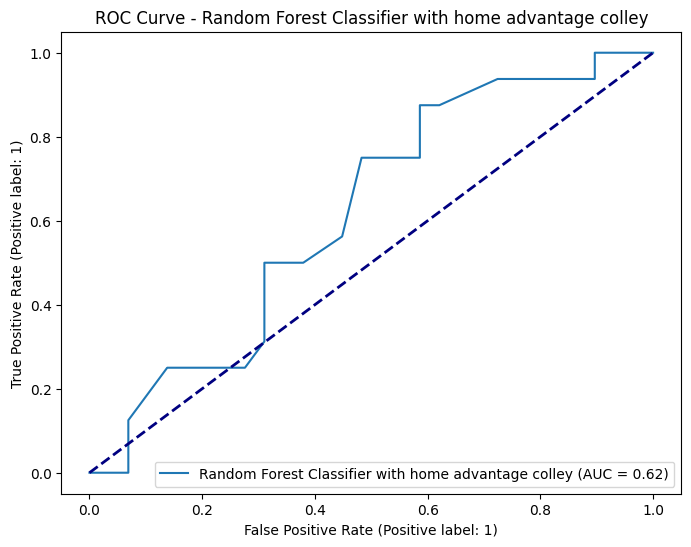

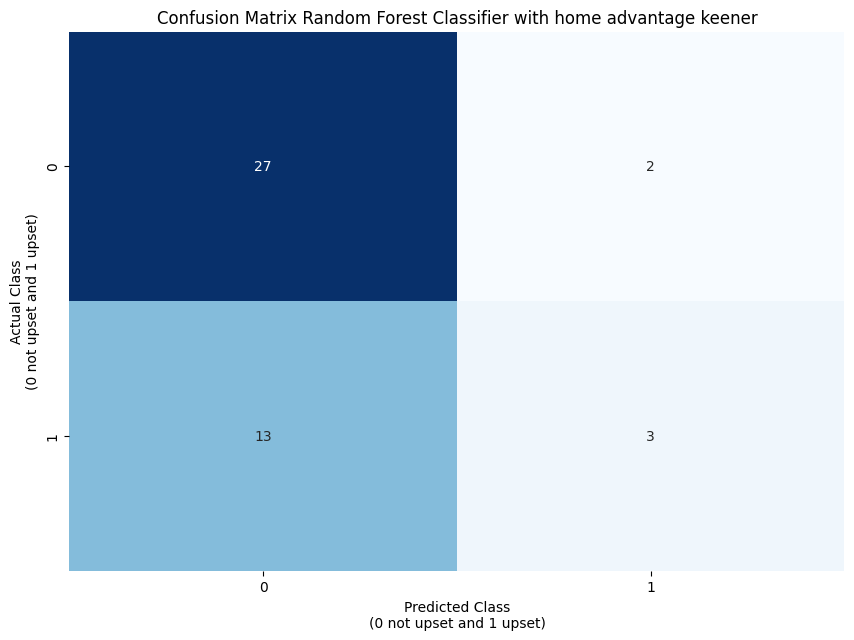

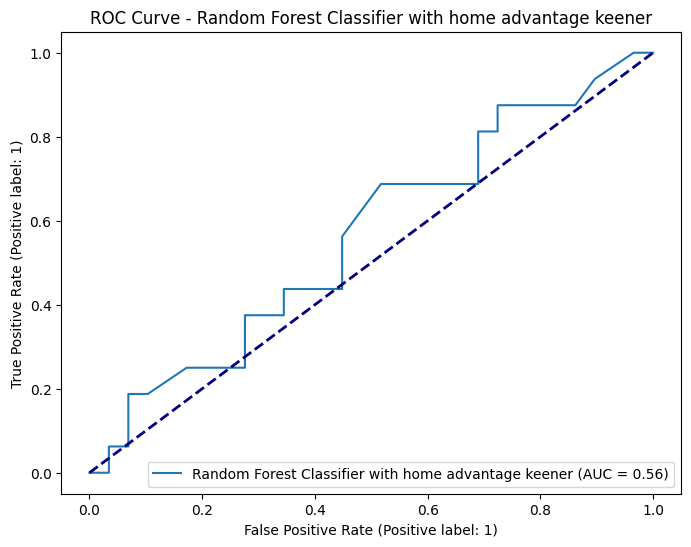

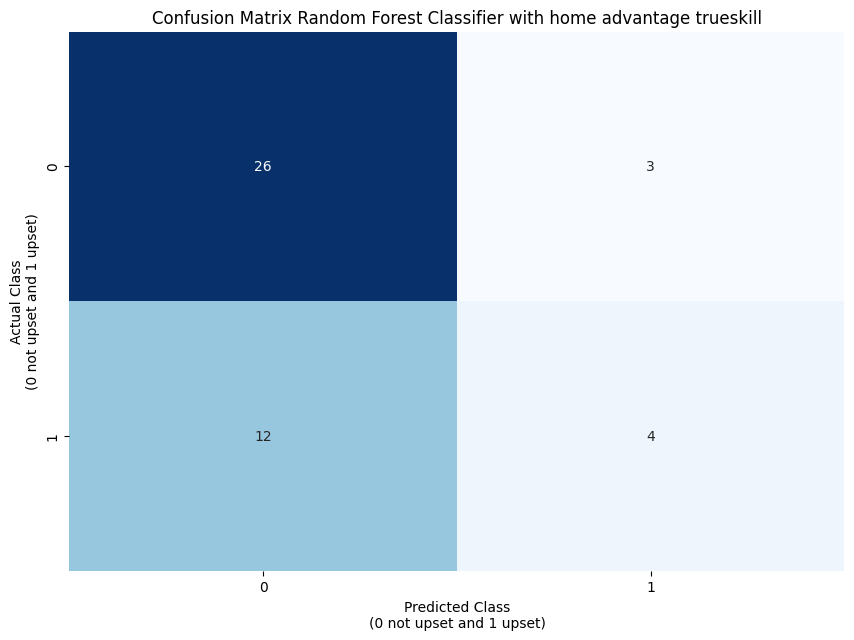

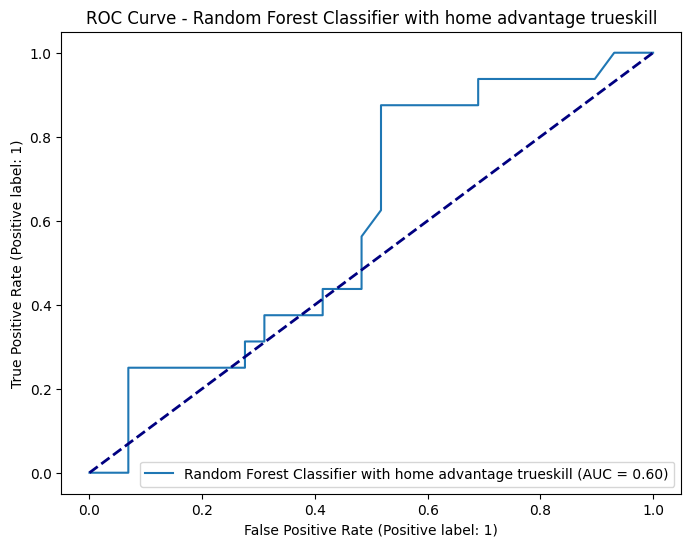

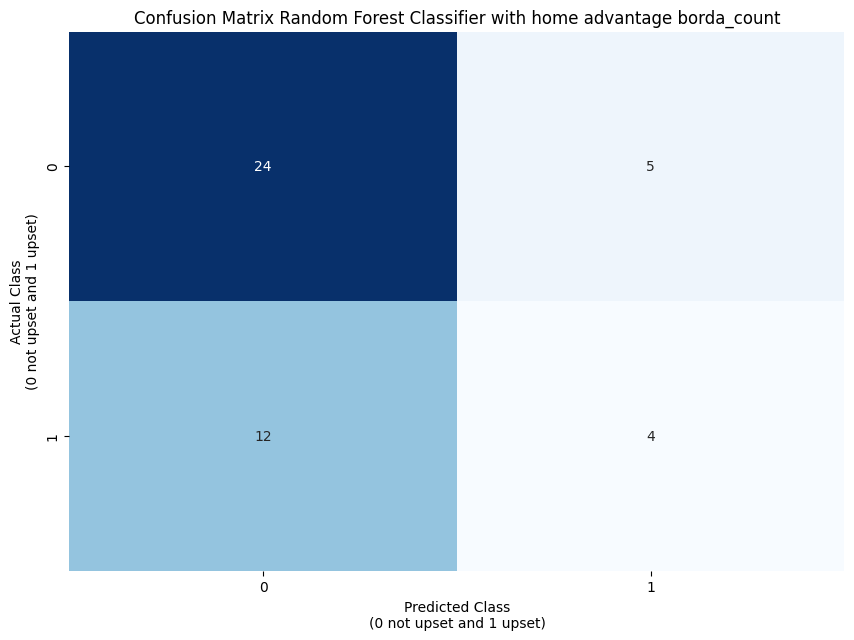

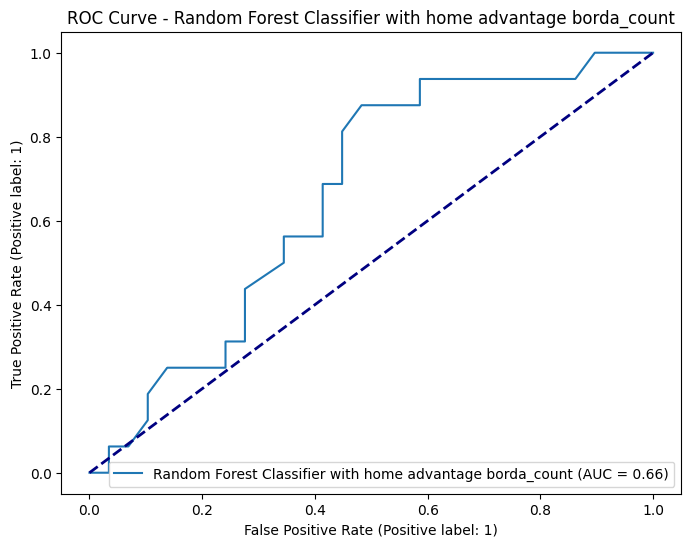

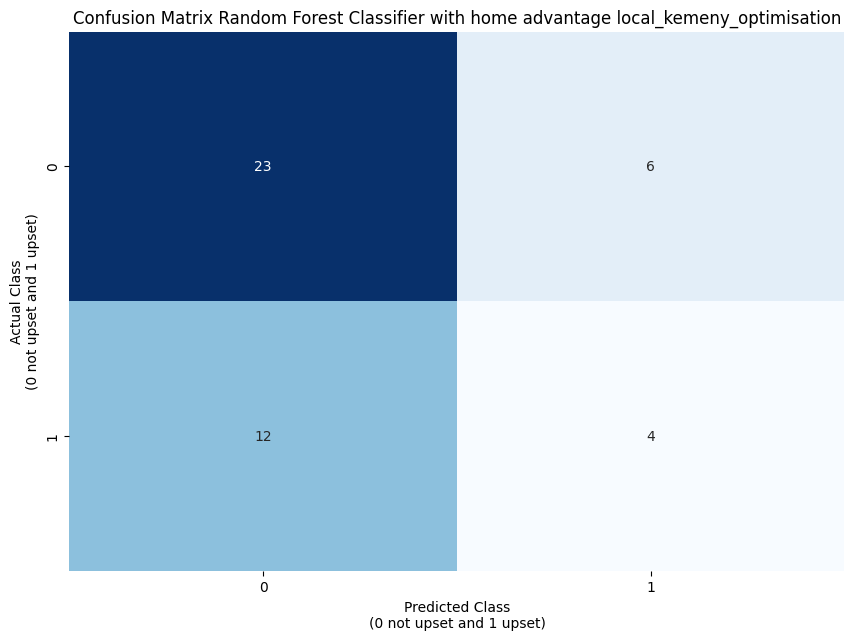

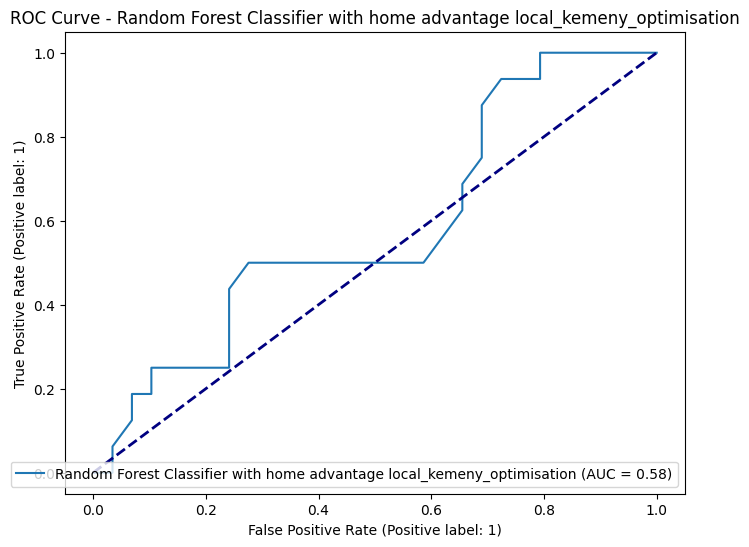

In [ ]:
# Random Forest Classifier with home advantage
model_name = "Random Forest Classifier with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

all_results_df, fold_results_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_rfh = all_results_df
display(all_results_df_rfh)

fold_results_df_rfh = fold_results_df
display(fold_results_df_rfh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rfh.to_excel("all_rfh_results.xlsx")
fold_results_df_rfh.to_excel("fold_results_rfh.xlsx")

XG Boost no_ranking
Updated model parameters:
  objective: binary:logistic
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: 1.0
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.1
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 5
  max_leaves: None
  min_child_weight: 1
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: None
  n_jobs: None
  num_parallel_tree: None
  random_state: 47
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: 0.8
  tree_method: None
  validate_parameters: None
  verbosity: None
numeric features ['arena_stadium_capacity', 'home_lineup_strength', 'home_team_league_form', 'home_team_lea

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2                    Unseen Standard Deviation   
2           3                         Unseen Accuracy Mean   
3           4           Unseen Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6        Unseen rain Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   XG Boost local_kemeny_optimisation  
0                               0.993  
1                               0.000  
2                               0.600  
3                               0.000  
4                               0.976  
5                               0.000  
6                               0.312  
7                               0.000  
8                               0.140  
9                               0.782  
10                              0.600  
11                             22.000  
12                              7.000  
13                             11.000  
14                              5.000  
15                              0.667  
16                              0.759  
17                              0.710  
18                              0.417  
19                              0.312  
20                              0.357  
21                              0.542  
22                              0.536  
23                              0.533  
24                              0.578  
25                              0.600  
26                              0.584  
27                              0.578

Actual  Predicted  arena_stadium_capacity  home_lineup_strength  \
0        0          0                   53394                  0.69   
1        0          0                   41837                  0.67   
2        0          0                   62850                   NaN   
3        0          0                   62850                  0.88   
4        0          0                   32050                  0.88   
5        1          0                   42682                  0.82   
6        0          0                   39460                  0.82   
7        1          0                   11700                  0.82   
8        1          1                   52409                  0.72   
9        1          0                   21944                  0.81   
10       0          0                   18500                  0.77   
11       0          0                   26445                  0.85   
12       0          0                   34988                  0.89   
13       0          0                   26445                  0.87   
14       0          1                   10226                  0.79   
15       0          1                   30089                  0.73   
16       1          0                   30445                  0.81   
17       0          0                   20146                  0.71   
18       1          0                   32609                  0.83   
19       0          0                   25400                  0.82   
20       0          0                    <NA>                  0.79   
21       1          0                   29409                  0.61   
22       0          1                   25400                  0.76   
23       0          0                   15314                  0.83   
24       1          0                   17338                  0.83   
25       0          0                   23287                  0.76   
26       1          0                   25138                  0.82   
27       1          0                   39732                  0.76   
28       1          0                   29673                  0.78   
29       0          0                   27111                  0.69   
30       0          0                   12500                  0.72   
31       0          0                    9875                  0.82   
32       1          1                    5327                  0.79   
33       0          0                   15728                  0.85   
34       0          0                    5057                  0.76   
35       0          1                   10000                  0.69   
36       0          1                   18947                  0.78   
37       0          1                    5140                  0.75   
38       1          0                    7691                  0.76   
39       1          1                    9546                  0.75   
40       0          0                   11582                   NaN   
41       0          1                    7691                  0.62   
42       1          1                    4502                  0.70   
43       0          0                    9527                  0.72   
44       1          1                    6238                   NaN   

    home_team_league_form  home_team_league_form_home_and_away  \
0                    0.83                                 0.44   
1                    0.39                                 0.39   
2                    0.00                                 0.39   
3                    0.56                                 0.39   
4                    0.00                                 0.72   
5                    0.39                                 0.56   
6                    0.00                                 0.11   
7                    0.00                                 0.17   
8                    0.00                                 0.28   
9                    0.22                                 0.17   
10         

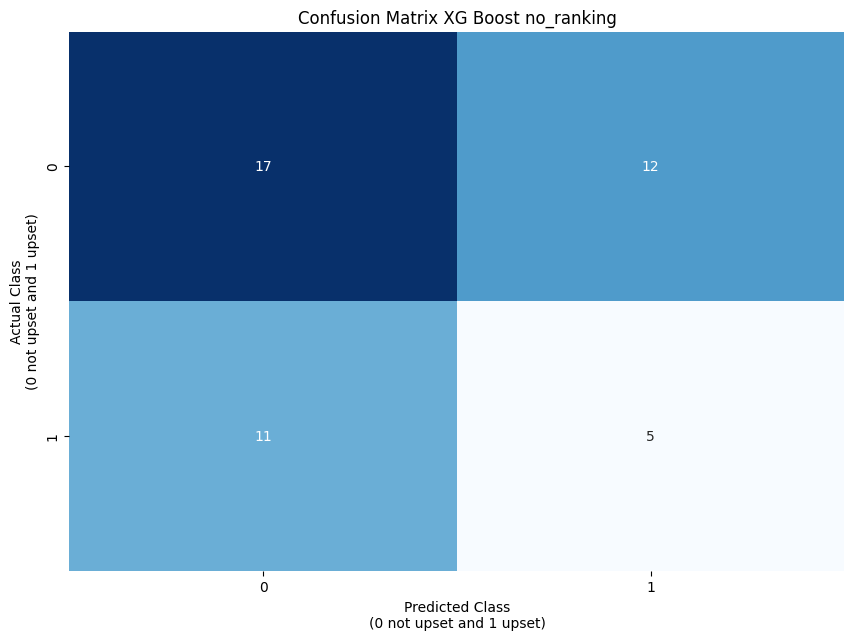

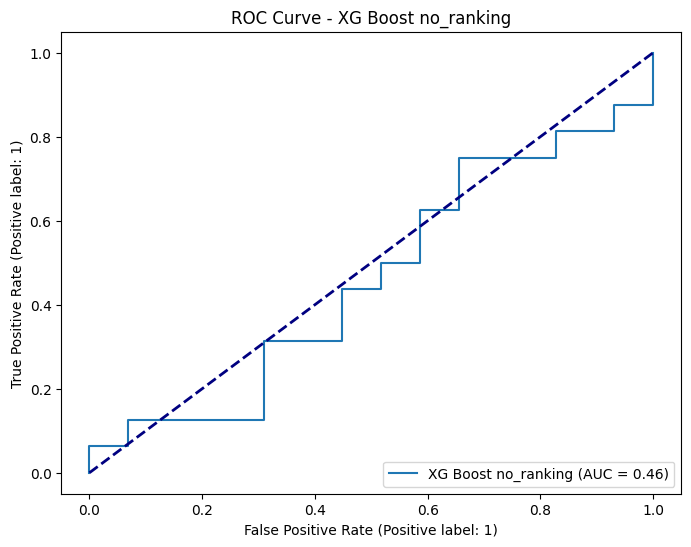

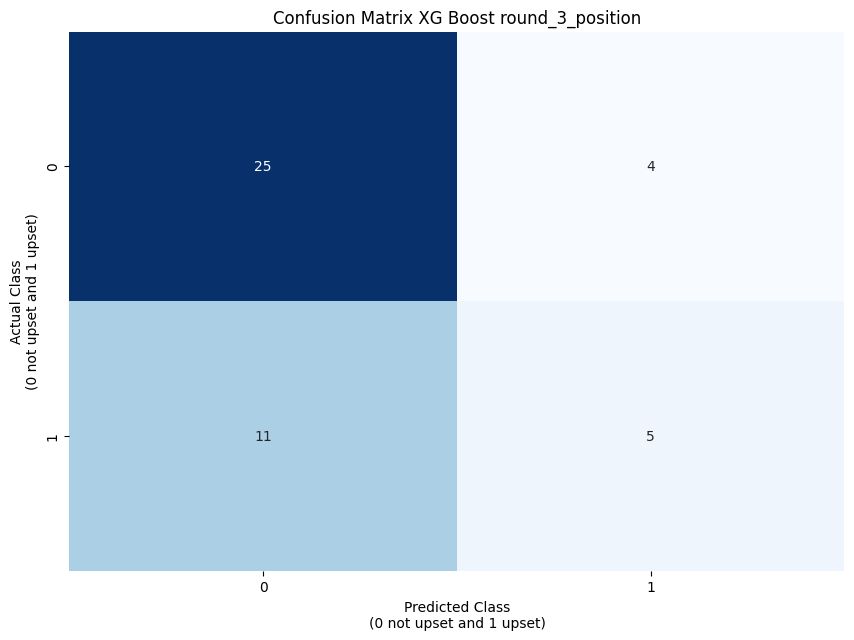

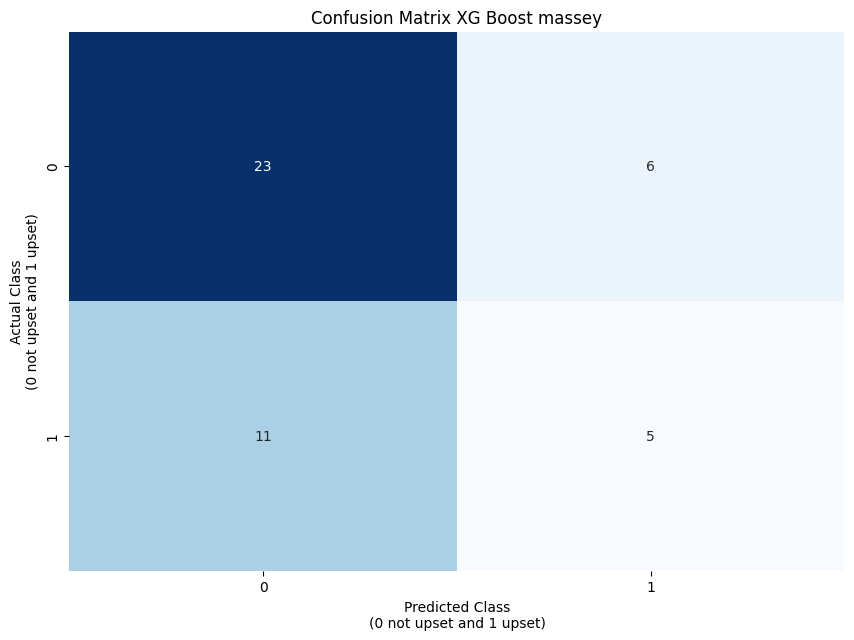

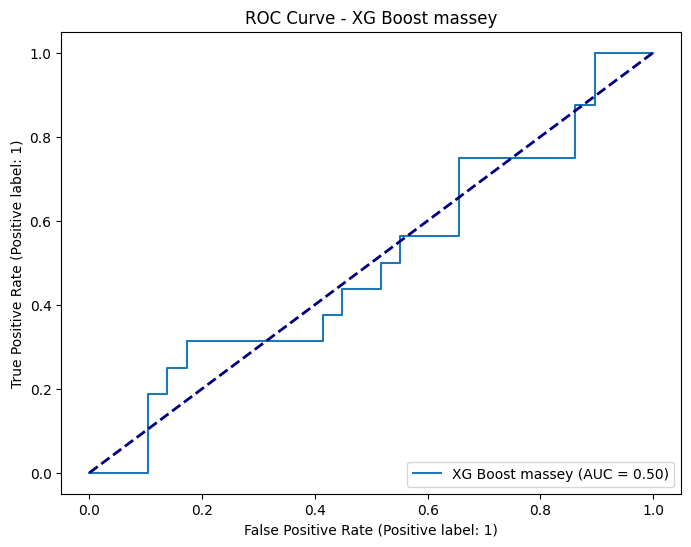

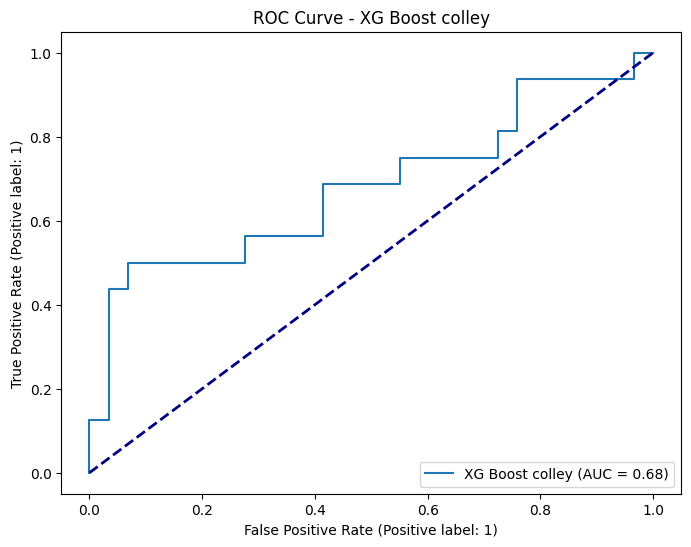

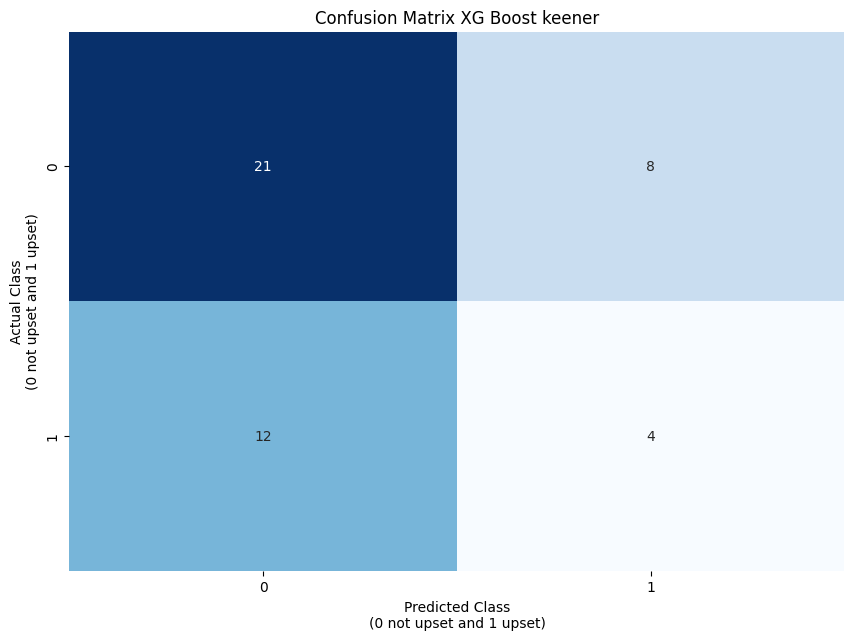

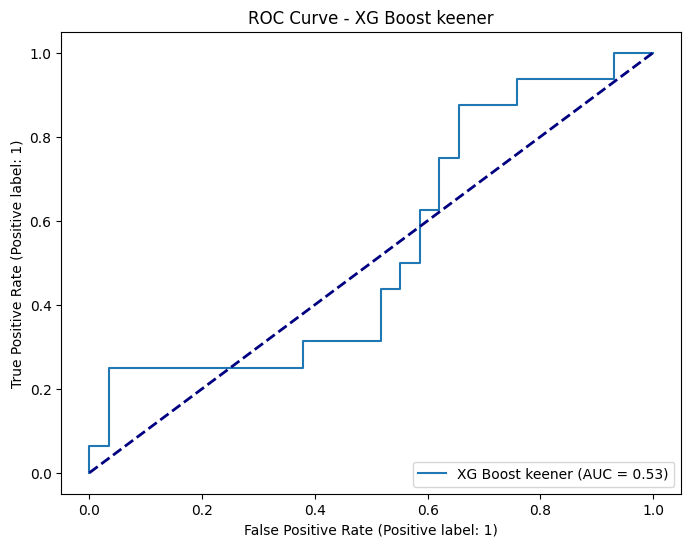

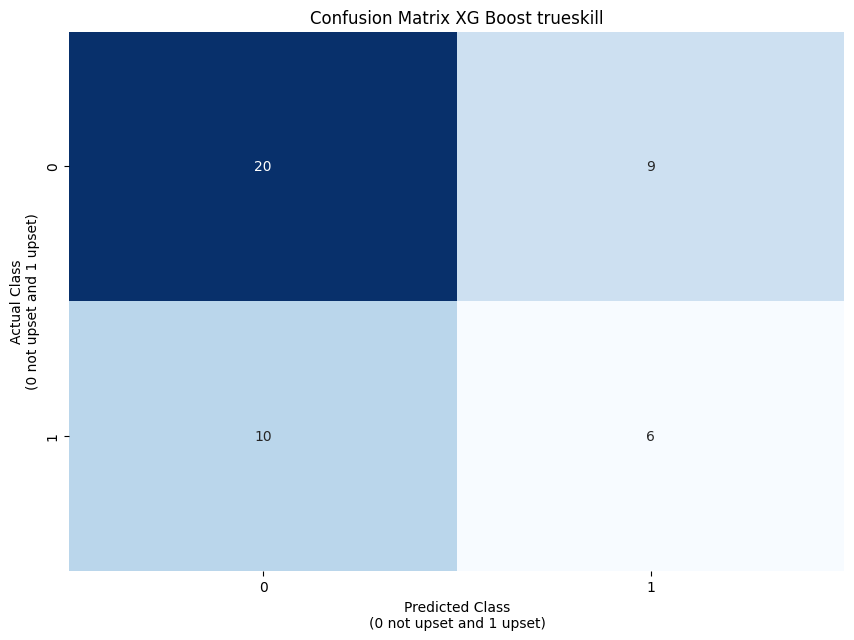

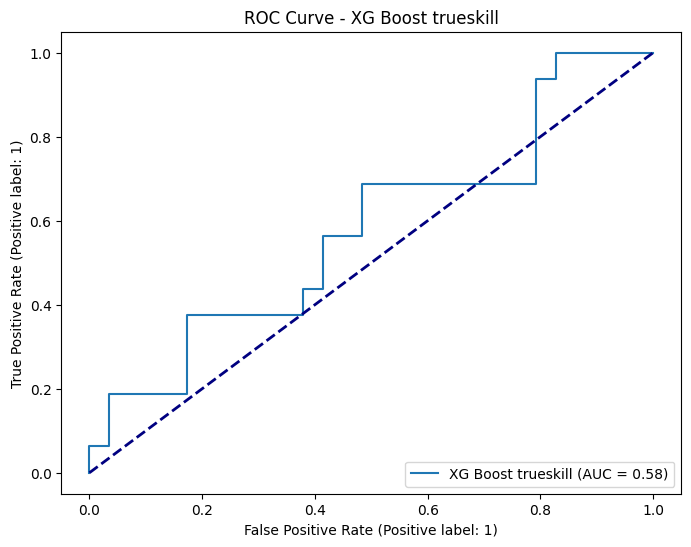

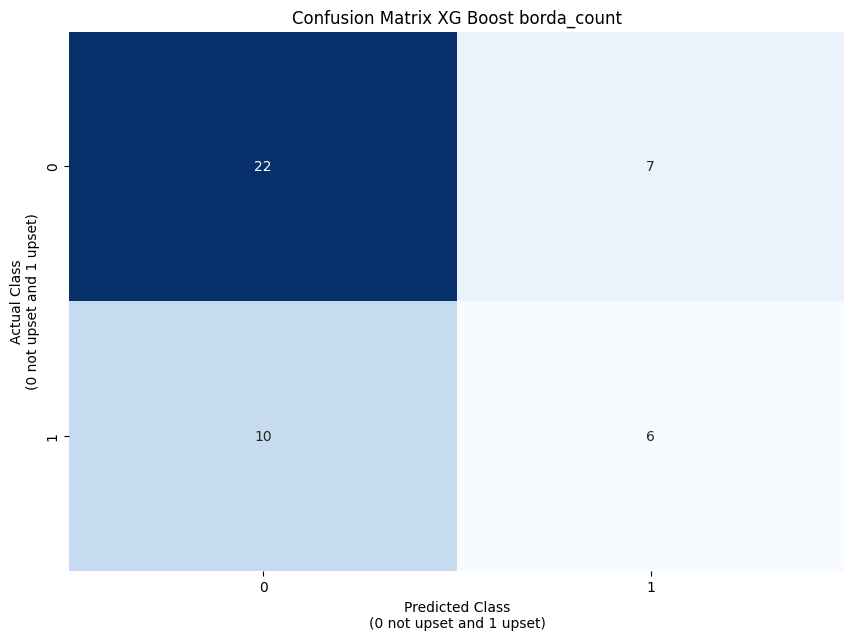

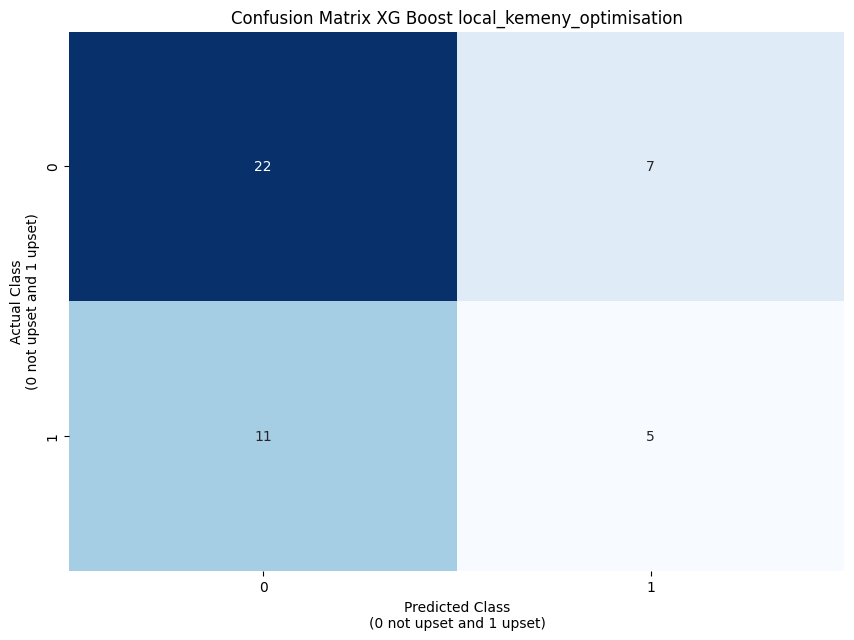

In [ ]:
# XG Boost
model_name = "XG Boost"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

all_results_df, fold_results_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_xg = all_results_df
display(all_results_df_xg)

fold_results_df_xg = fold_results_df
display(fold_results_df_xg)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xg.to_excel("all_xg_results.xlsx")
fold_results_df_xg.to_excel("fold_results_xg.xlsx")

XG Boost with home advantage no_ranking
Updated model parameters:
  objective: binary:logistic
  base_score: None
  booster: None
  callbacks: None
  colsample_bylevel: None
  colsample_bynode: None
  colsample_bytree: 0.6
  device: None
  early_stopping_rounds: None
  enable_categorical: False
  eval_metric: None
  feature_types: None
  gamma: None
  grow_policy: None
  importance_type: None
  interaction_constraints: None
  learning_rate: 0.1
  max_bin: None
  max_cat_threshold: None
  max_cat_to_onehot: None
  max_delta_step: None
  max_depth: 5
  max_leaves: None
  min_child_weight: 2
  missing: nan
  monotone_constraints: None
  multi_strategy: None
  n_estimators: None
  n_jobs: None
  num_parallel_tree: None
  random_state: 47
  reg_alpha: None
  reg_lambda: None
  sampling_method: None
  scale_pos_weight: None
  subsample: 1.0
  tree_method: None
  validate_parameters: None
  verbosity: None
numeric features ['home_win_factor', 'arena_stadium_capacity', 'home_lineup_strength', 

metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2                    Unseen Standard Deviation   
2           3                         Unseen Accuracy Mean   
3           4           Unseen Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6        Unseen rain Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   XG Boost with home advantage local_kemeny_optimisation  
0                                               0.997      
1                                               0.000      
2                                               0.667      
3                                               0.000      
4                                               0.988      
5                                               0.000      
6                                               0.188      
7                                               0.000      
8                                               0.115      
9                                               0.785      
10                                              0.667      
11                                             27.000      
12                                              2.000      
13                                             13.000      
14                                              3.000      
15                                              0.675      
16                                              0.931      
17                                              0.783      
18                                              0.600      
19                                              0.188      
20                                              0.286      
21                                              0.637      
22                                              0.559      
23                                              0.534      
24                                              0.648      
25                                              0.667      
26                                              0.606      
27                                              0.588

Actual  Predicted  arena_stadium_capacity  home_lineup_strength  \
0        0          0                   53394                  0.69   
1        0          0                   41837                  0.67   
2        0          0                   62850                   NaN   
3        0          0                   62850                  0.88   
4        0          0                   32050                  0.88   
5        1          0                   42682                  0.82   
6        0          0                   39460                  0.82   
7        1          0                   11700                  0.82   
8        1          1                   52409                  0.72   
9        1          0                   21944                  0.81   
10       0          0                   18500                  0.77   
11       0          0                   26445                  0.85   
12       0          0                   34988                  0.89   
13       0          0                   26445                  0.87   
14       0          0                   10226                  0.79   
15       0          1                   30089                  0.73   
16       1          0                   30445                  0.81   
17       0          0                   20146                  0.71   
18       1          0                   32609                  0.83   
19       0          0                   25400                  0.82   
20       0          0                    <NA>                  0.79   
21       1          0                   29409                  0.61   
22       0          0                   25400                  0.76   
23       0          0                   15314                  0.83   
24       1          0                   17338                  0.83   
25       0          0                   23287                  0.76   
26       1          1                   25138                  0.82   
27       1          0                   39732                  0.76   
28       1          0                   29673                  0.78   
29       0          0                   27111                  0.69   
30       0          0                   12500                  0.72   
31       0          0                    9875                  0.82   
32       1          1                    5327                  0.79   
33       0          0                   15728                  0.85   
34       0          0                    5057                  0.76   
35       0          0                   10000                  0.69   
36       0          0                   18947                  0.78   
37       0          1                    5140                  0.75   
38       1          0                    7691                  0.76   
39       1          0                    9546                  0.75   
40       0          0                   11582                   NaN   
41       0          0                    7691                  0.62   
42       1          0                    4502                  0.70   
43       0          0                    9527                  0.72   
44       1          0                    6238                   NaN   

    home_team_league_form  home_team_league_form_home_and_away  \
0                    0.83                                 0.44   
1                    0.39                                 0.39   
2                    0.00                                 0.39   
3                    0.56                                 0.39   
4                    0.00                                 0.72   
5                    0.39                                 0.56   
6                    0.00                                 0.11   
7                    0.00                                 0.17   
8                    0.00                                 0.28   
9                    0.22                                 0.17   
10         

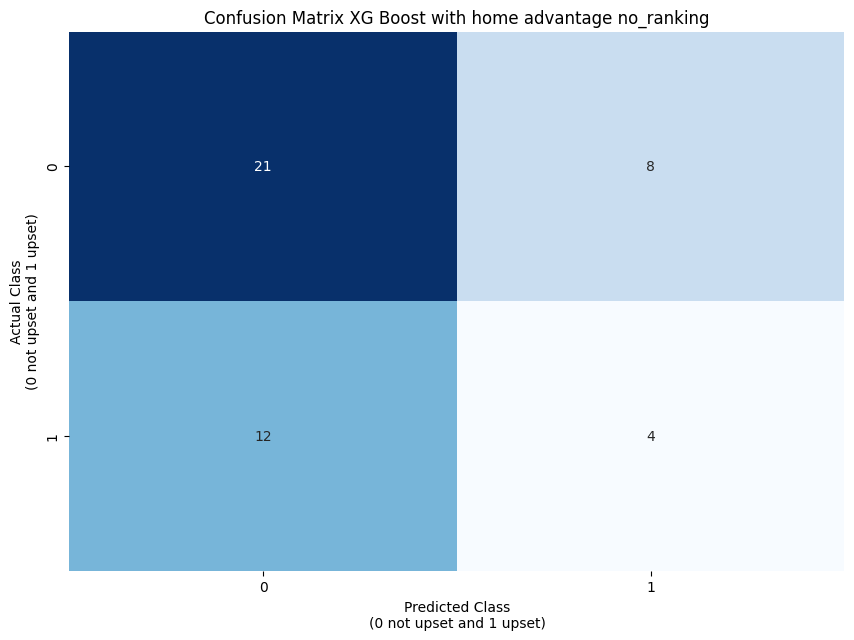

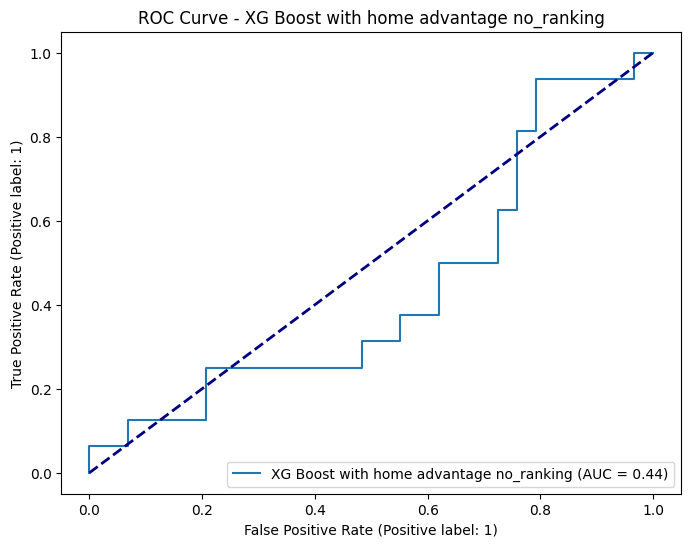

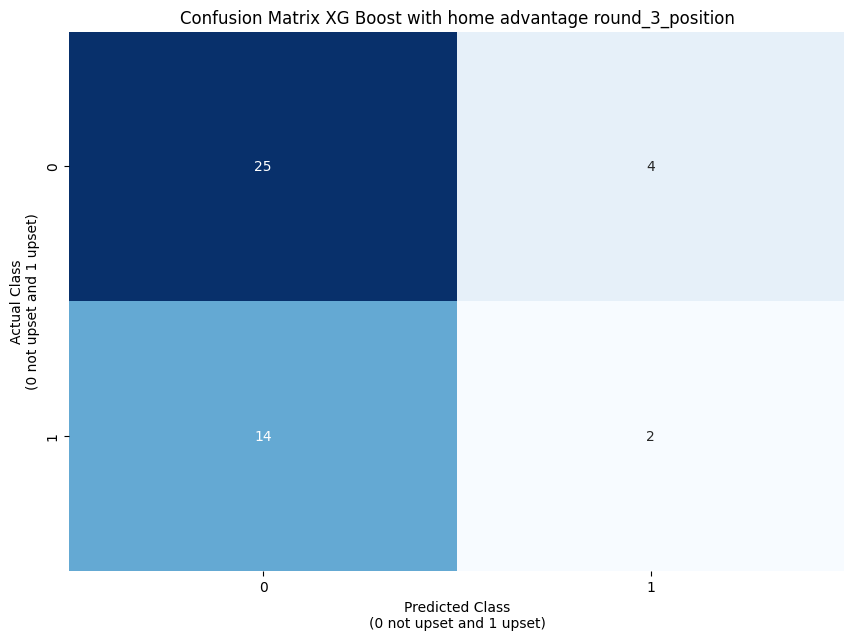

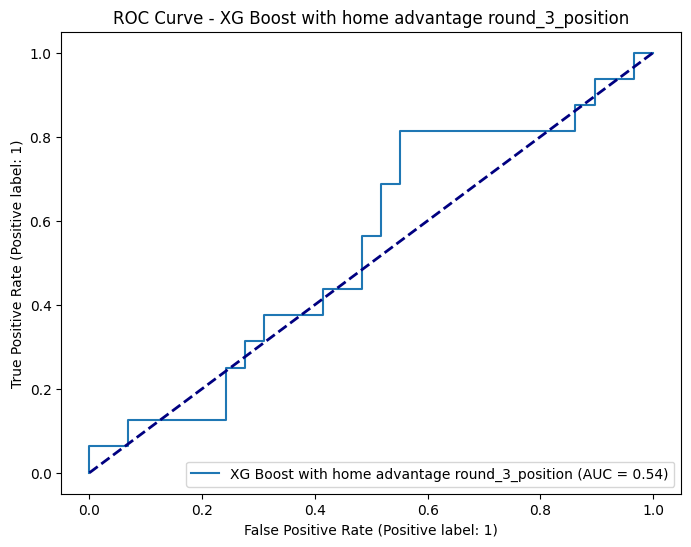

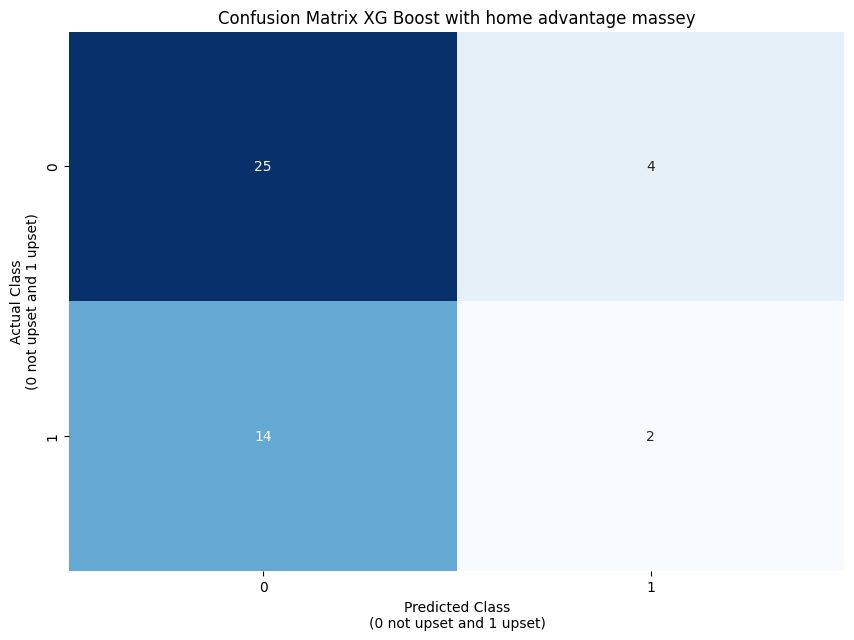

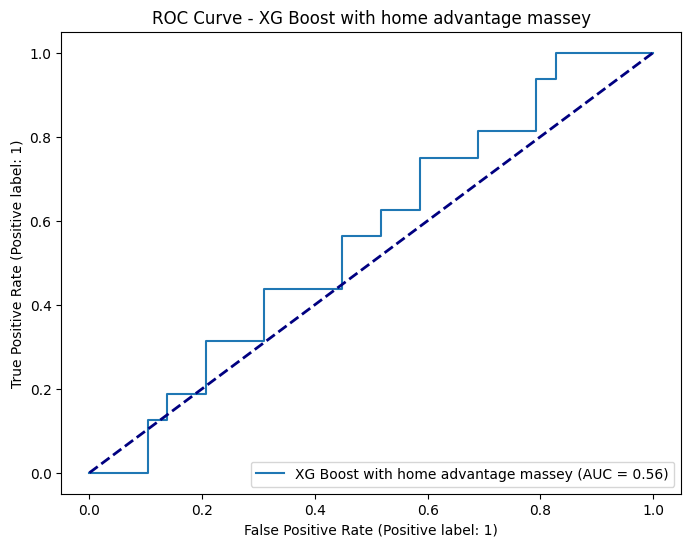

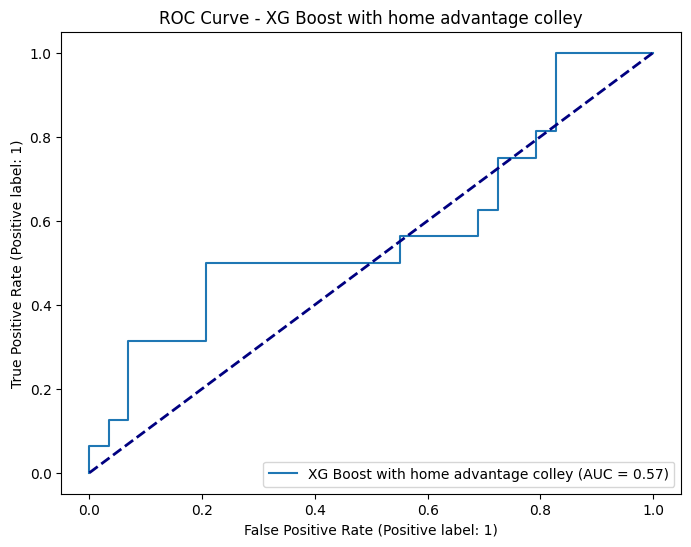

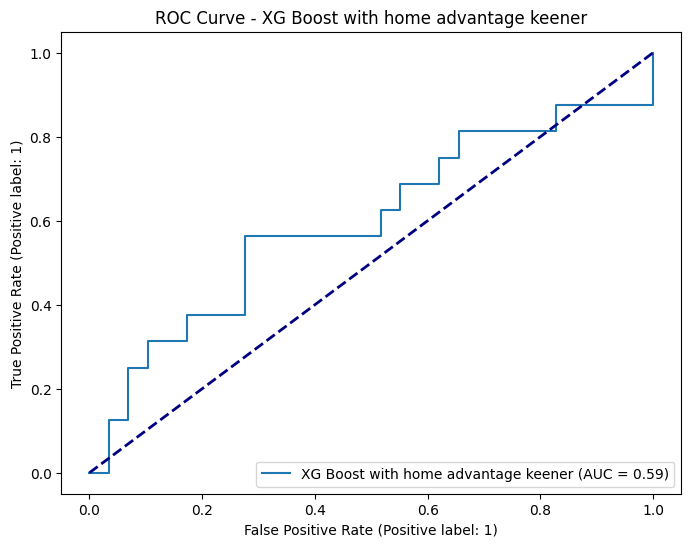

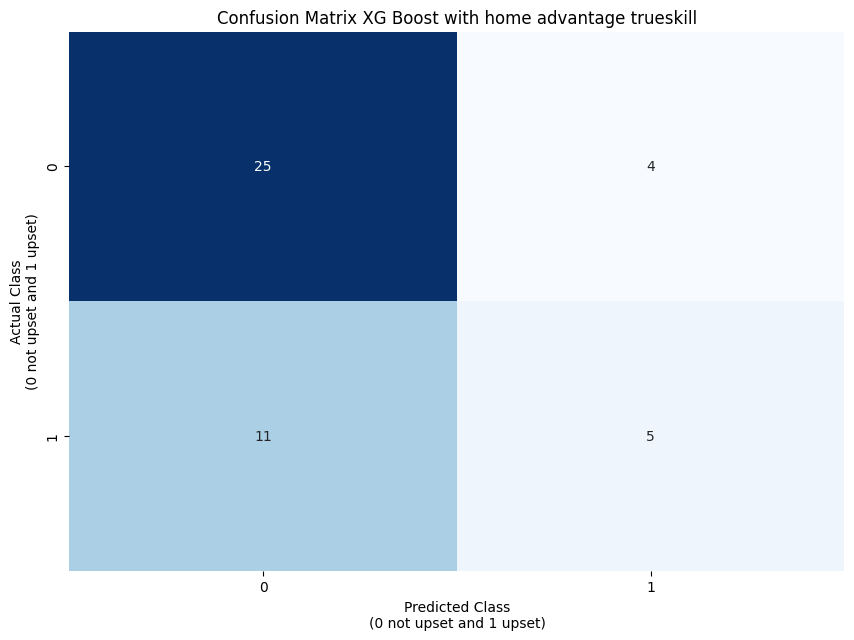

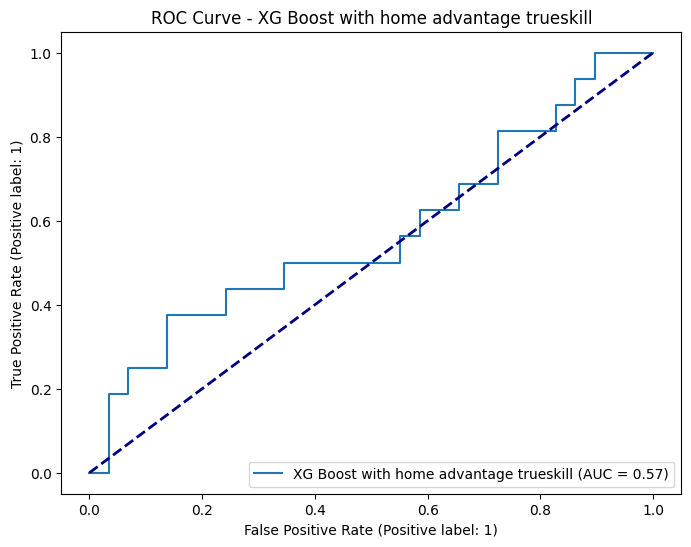

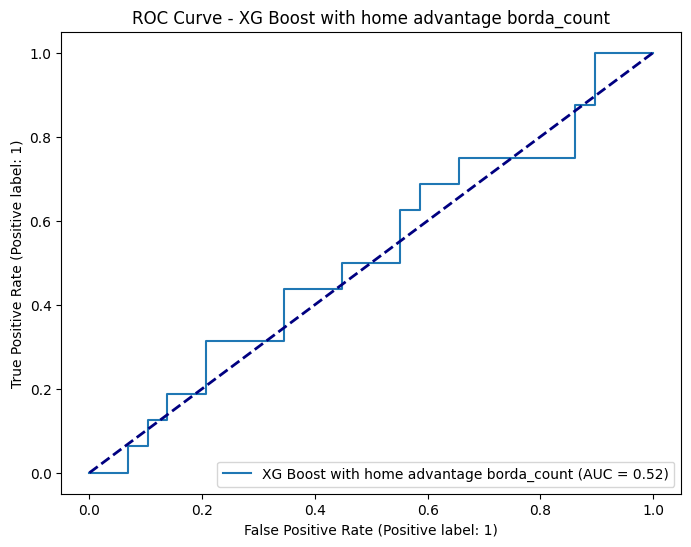

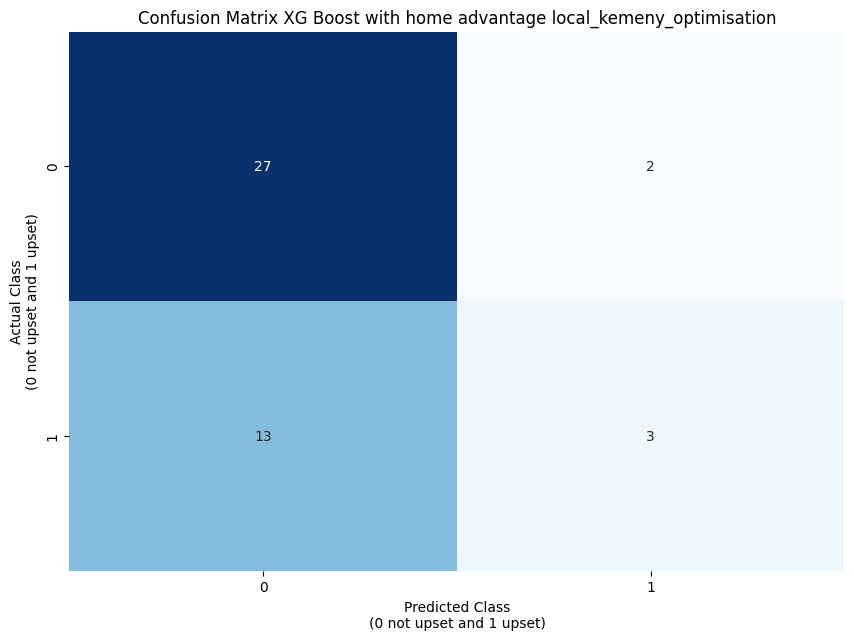

In [ ]:
# XG Boost with home advantage
model_name = "XG Boost with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

all_results_df, fold_results_df  = classifer_models_optimisation_single_split (fa_cup_features_all_df,model_name, home_advt, weighted, model_classifier, random_state)

all_results_df_xgh = all_results_df
display(all_results_df_xgh)

fold_results_df_xgh = fold_results_df
display(fold_results_df_xgh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xgh.to_excel("all_xgh_results.xlsx")
fold_results_df_xgh.to_excel("fold_results_xgh.xlsx")

In [ ]:
all_results_df = all_results_df_xg.merge(all_results_df_xgh, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rfh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rf.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nnh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nn.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_slrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_slr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')

all_results_df = all_results_df.rename(columns=lambda x: x.lower().replace(' ','(_)').replace('(', '').replace(')', ''))
display(all_results_df)
all_results_df.to_excel("ml_model_confusion_matrix_results_unseen.xlsx")

# Load data from Excel to Google BigQuery
all_results_from_excel = pd.read_excel("ml_model_confusion_matrix_results_unseen.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_confusion_matrix_results_unseen'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(all_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


metric_id                                       metric  \
0           1                   Unseen Train Accuracy Mean   
1           2                    Unseen Standard Deviation   
2           3                         Unseen Accuracy Mean   
3           4           Unseen Accuracy Standard Deviation   
4           5                     Unseen Train Recall Mean   
5           6        Unseen rain Recall Standard Deviation   
6           7                     Unseen  Test Recall Mean   
7           8       Unseen  Test Recall Standard Deviation   
8           9                        Unseen Train Log Loss   
9          10                         Unseen Test Log Loss   
10         11                             Overall Accuracy   
11         12   Confusion Matrix - True Negative (Class 0)   
12         13  Confusion Matrix - False Positive (Class 1)   
13         14  Confusion Matrix - False Negative (Class 0)   
14         15   Confusion Matrix - True Positive (Class 1)   
15         16                          Precision (Class 0)   
16         17                             Recall (Class 0)   
17         18                           F1-score (Class 0)   
18         19                          Precision (Class 1)   
19         20                             Recall (Class 1)   
20         21                           F1-score (Class 1)   
21         22                          Macro avg Precision   
22         23                             Macro avg Recall   
23         24                           Macro avg F1-score   
24         25                       Weighted avg Precision   
25         26                          Weighted avg Recall   
26         27                        Weighted avg F1-score   
27         28                                      AUC-ROC   

   standard_logisticregression_local_kemeny_optimisation  \
0                                               0.757      
1                                               0.000      
2                                               0.622      
3                                               0.000      
4                                               0.280      
5                                               0.000      
6                                               0.250      
7                                               0.000      
8                                               0.480      
9                                               1.108      
10                                              0.622      
11                                             24.000      
12                                              5.000      
13                                             12.000      
14                                              4.000      
15                                              0.667      
16                                              0.828      
17                                              0.738      
18                                              0.444      
19                                              0.250      
20                                              0.320      
21                                              0.556      
22                                              0.539      
23                                              0.529      
24                                              0.588      
25                                              0.622      
26                                              0.590      
27                                              0.494      

   standard_logisticregression_with_home_advantage_local_kemeny_optimisation  \
0                                               0.774                          
1                                               0.000                          
2                                               0.578                          
3                                               0.000                          
4                                               0.317           

100%|██████████| 1/1 [00:00<00:00, 7410.43it/s]


Data loaded to BigQuery table: analysis_layer.ml_model_confusion_matrix_results


In [ ]:
# Load updated Fold results to Google Big Query

# Merge fold results from each model
fold_results_df = pd.concat([fold_results_df_slr, fold_results_df_slrh, fold_results_df_wlr, fold_results_df_wlrh, fold_results_df_nn, fold_results_df_nnh, fold_results_df_rf, fold_results_df_rfh, fold_results_df_xg, fold_results_df_xgh])
fold_results_df = fold_results_df.rename(columns=lambda x: x.lower().replace(' ','(_)').replace('(', '').replace(')', ''))
display(fold_results_df)

# Write to Excel
fold_results_df.to_excel("ml_model_fold_results_unseen.xlsx")

# Load fold results data from Excel to Google BigQuery
fold_results_from_excel = pd.read_excel("ml_model_fold_results_unseen.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_fold_results_unseen'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(fold_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


actual  predicted  arena_stadium_capacity  home_lineup_strength  \
0        0          0                   53394                  0.69   
1        0          0                   41837                  0.67   
2        0          0                   62850                   NaN   
3        0          0                   62850                  0.88   
4        0          0                   32050                  0.88   
..     ...        ...                     ...                   ...   
40       0          0                   11582                   NaN   
41       0          0                    7691                  0.62   
42       1          0                    4502                  0.70   
43       0          0                    9527                  0.72   
44       1          0                    6238                   NaN   

    home_team_league_form  home_team_league_form_home_and_away  \
0                    0.83                                 0.44   
1                    0.39                                 0.39   
2                    0.00                                 0.39   
3                    0.56                                 0.39   
4                    0.00                                 0.72   
..                    ...                                  ...   
40                   0.00                                 0.33   
41                   0.00                                 0.39   
42                   0.00                                 0.61   
43                   0.39                                 0.17   
44                    NaN                                  NaN   

    home_team_league_promotion_relegation  away_lineup_strength  \
0                                       0                  0.81   
1                                       0                  0.82   
2                                       0                   NaN   
3                                       0                  0.78   
4                                       1                  0.71   
..                                    ...                   ...   
40                                      0                   NaN   
41                                      0                  0.73   
42                                      0                  0.85   
43                                      1                  0.75   
44                                      0                  0.69   

    away_team_league_form  away_team_league_form_home_and_away  ...  \
0                    0.00                                 0.56  ...   
1                    0.56                                 0.56  ...   
2                    0.28                                 0.39  ...   
3                    0.22                                 0.28  ...   
4                    0.56                                 0.56  ...   
..                    ...                                  ...  ...   
40                   0.00                                 0.33  ...   
41                   0.00                                 0.28  ...   
42                   0.28                                 0.17  ...   
43                   0.28                                 0.33  ...   
44                   0.00                                 0.06  ...   

    match_weather_data_hours_visibility  match_weather_data_hours_cloudcover  \
0                                  6.80                                38.15   
1                                 12.65                                62.20   
2                                  7.05                               100.00   
3                                 16.60                                32.30   
4                                 18.00                                45.70   
..                                  ...                                  ...   
40                                 8.10                                97.30   
41                                20.75                     

100%|██████████| 1/1 [00:00<00:00, 6017.65it/s]


Data loaded to BigQuery table: analysis_layer.ml_model_fold_results
